In [1]:
# import whatever needed 

import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import camb
import astropy.units as u
import astropy.constants as cu
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad
from scipy import integrate


import sys
from LIM_b7 import *
import main as m
sys.path.append('/home/gali/Codes/lim_b7')

import hmvec.ksz as ksz
import hmvec.hod as hod
import hmvec.hmvec as hm

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import getdist
from getdist import plots, MCSamples
import IPython
# The plotting scripts also let you plot Gaussian (or Gaussian mixture) contours 
from getdist.gaussian_mixtures import GaussianND

print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True

from matplotlib import pyplot as plt
palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#5f685f','#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00',
            '#3f91d9', '#d93d42']
#palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [6, 5]
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"})

GetDist Version: 1.4.3, Matplotlib version: 3.7.0


In [43]:
cosmo_camb = dict(
         H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=1, mnu=0.06, nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')


astro_a = 1.0
astro_b = 6.9647


def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    Delta_nu = abs(nu_zmin-nu_zmax)
    return nuObs, Delta_nu

def lim_params(line, downgrade):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    if line=='CII':
        if not downgrade:
            cosmo_model_params = dict(cosmo_input_camb=cosmo_camb,
                                    model_name='SilvaCII',
                                    nu=1900.539*u.GHz,nuObs=(1900.539/(1+1))*u.GHz,
                                model_par={'SFR_file':os.getcwd() + '/LIM_b7/modelling/SFR_tables/silva15_sfr.dat','a':astro_a,'b':astro_b},
                                sigma_scatter=0., do_Jysr=True, Mmin=1e9*u.Msun,Mmax=1e15*u.Msun, do_onehalo=False,
                                do_RSD=True, smooth=True, kmin=3e-4*u.Mpc**-1, kmax=1e3*u.Mpc**-1, nk=300 , nmu=200,
                                nM=200, bv_par=1., bv_perp=1., Acip=0., bT_up=False, bT_down=False)

            obs_params = dict(Delta_nu=317*u.GHz, Nfeeds=1,
                                  beam_FWHM=2.*np.sqrt(8*np.log(2))*u.arcsec, tobs=10000*u.hr,
                                  Omega_field=7500*u.deg**2, Nfield=1, dnu = 0.76*u.GHz, sigma_pix=15.*1e3*u.Jy/u.sr*u.s**0.5,
                                  input_sigmaN = -1*u.Jy/u.sr*u.s**0.5)
                                  #Tsys_NEFD=1.4e-6*u.Jy*u.s**0.5)
        else:
            cosmo_model_params = dict(cosmo_input_camb=cosmo_camb,
                                    model_name='SilvaCII',
                                    nu=1900.539*u.GHz,nuObs=(1900.539/(1+1))*u.GHz,
                                model_par={'SFR_file':os.getcwd() + '/LIM_b7/modelling/SFR_tables/silva15_sfr.dat','a':astro_a,'b':astro_b},
                                sigma_scatter=0., do_Jysr=True, Mmin=1e9*u.Msun,Mmax=1e15*u.Msun, do_onehalo=False,
                                do_RSD=True, smooth=True, kmin=3e-4*u.Mpc**-1, kmax=1e3*u.Mpc**-1, nk=300 , nmu=200,
                                nM=200, bv_par=1., bv_perp=1., Acip=0., bT_up=False, bT_down=False)

            obs_params = dict(Delta_nu=317*u.GHz, Nfeeds=1,
                                  beam_FWHM=2.*u.arcsec, tobs=3000*u.hr,
                                  Omega_field=1000*u.deg**2, Nfield=1, dnu = 0.76*u.GHz, sigma_pix=15.*1e3*u.Jy/u.sr*u.s**0.5,
                                  input_sigmaN = -1*u.Jy/u.sr*u.s**0.5)
                                  #Tsys_NEFD=1.4e-6*u.Jy*u.s**0.5)
    return cosmo_model_params, obs_params

R = 1000
zs = np.arange(1.5, 4.51, 1)
beam = np.array([2., 2.8, 3.6, 4.4])*u.arcsec
sigmaN = np.array([3.9, 1.4, 0.7, 0.4])*1e5*u.Jy/u.sr # from 2012.00771
sigpix = np.array([15., 7.54, 4.85, 3.39])*1e3*u.Jy/u.sr*u.s**0.5 # calculated using Jose's table sigma_pix=sigma_N*t_pix**0.5

down = False
cosmo_model_params, obs_params = lim_params('CII',down)
m = update_Pkline(obs_params,cosmo_model_params)[0]

nu, Dnu = Dnu_from_Dz(m.nu, zs[0], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
obs_params['sigma_pix'] = sigpix[0]
#obs_params['input_sigmaN'] = sigmaN[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]

#### Check $\sigma_N$ value as computed by the code
Here we set $T_{sys}$ to some fixed value to match, along with the other parameters, to the $\sigma_N$ value in Jose's paper (2012.00771)

In [3]:
m.nuObs

<Quantity 760.2156 GHz>

In [4]:
print('sigma_N / 1e5 = ')
m.sigma_N / 1e5
#((m.sigma_N**2/m.tpix).to(u.Jy**2/u.sr**2))**0.5 / 1e5


sigma_N / 1e5 = 


<Quantity 3.8971 Jy / sr>

In [5]:
print('White noise = ')
m.Pnoise

White noise = 
Note: redshifts have been re-sorted (earliest first)


<Quantity 1.34888503e+09 Jy2 Mpc3 / sr2>

In [6]:
cosmo1 = dict(
         H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=1, mnu=0.06, nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')

cosmo2 = dict(
         H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=0, mnu=0., nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')



down = False
cosmo_model_params, obs_params = lim_params('CII',down)
cosmo_model_params['kmin'] = 1e-4*u.Mpc**-1
cosmo_model_params['kmax'] = 1e0*u.Mpc**-1
m = update_Pkline(obs_params,cosmo_model_params)[0]


zs_VRO10 = np.array([0.2,0.7,1.3,1.9,2.6])



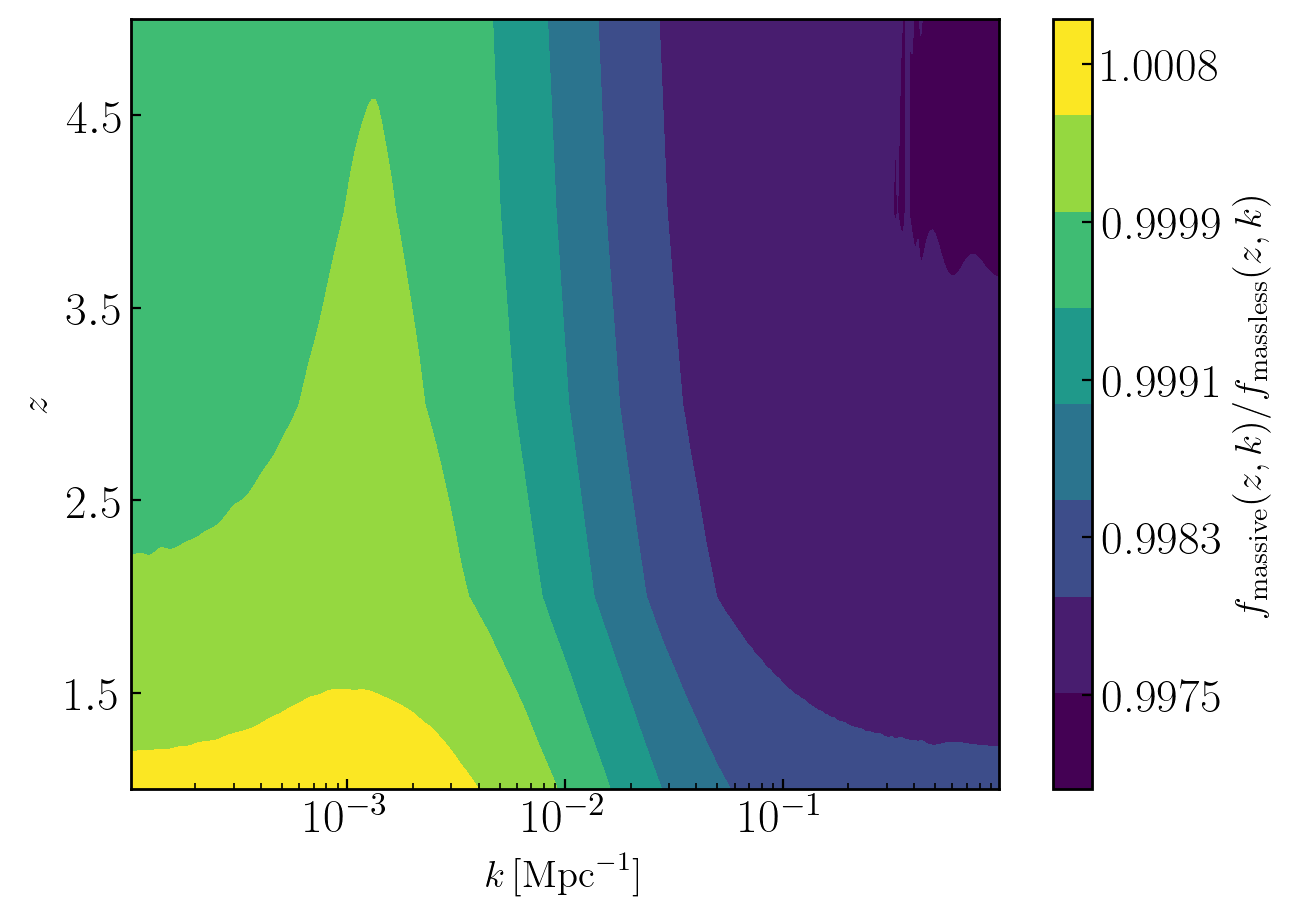

In [8]:
zs2 = np.linspace(1.,5.,5)

f_zk = np.zeros((len(zs2),len(m.k)))

for i in range(len(zs2)):
    cosmo_model_params['cosmo_input_camb'] = cosmo1
    nu, Dnu = Dnu_from_Dz(m.nu, zs2[i], 0.5)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    f1 = m.f_eff[-1]    
    cosmo_model_params['cosmo_input_camb'] = cosmo2
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    f2 = m.f_eff[-1]
    f_zk[i] = f1/f2

# Create a meshgrid for plotting
Z, K = np.meshgrid(zs2, m.k.value, indexing='ij')

# Plotting the 2D contour plot
plt.figure(figsize=(7, 5))
cp = plt.contourf(K, Z, f_zk, cmap='viridis', vmin=np.min(f_zk), vmax=np.max(f_zk))
cbar = plt.colorbar(cp, label=r'$f_\mathrm{massive}(z,k)/f_\mathrm{massless}(z,k)$')
# Set colorbar ticks
tick_values = np.linspace(f_zk.min(), f_zk.max(), num=5)  # Example: 5 ticks from min to max
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{val:.4f}' for val in tick_values])  # Format tick labels

# Add y-axis ticks
y_ticks = np.arange(1.5,5.5,1)
plt.yticks(y_ticks)
plt.xscale('log')
plt.xlabel(r'$k\,[\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$z$')

plt.show()

# Functions

In [9]:
#%% Calculate the reconstructed noise N_vv
def Rec_noise(M, k_large, mu_L, Delta_T):
    Z = M.z
    nkS = 200
    nkL = len(k_large)
    nz = 101
    k_small = np.linspace(1,5,nkS)/u.Mpc # Mpc^-1
    mu_S = -(k_large[np.newaxis,:,np.newaxis]*np.ones((nkS,nkL,nmu))/k_small[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu))) * mu_L[np.newaxis,np.newaxis,:]*np.ones((nkS,nkL,nmu))
    Mh = np.logspace(8,15,200) # Msun
    zcosmo = np.linspace(0.,15.,nz)
    cosmo1 = (M.cosmo_input_camb).copy()
    cosmo1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value /u.Mpc # 1/Mpc    
    a = lambda z: 1/(1+z)
    T_CMB = ((camb_pars.TCMB* u.K).to(u.uK))#.value # muK
    chi_star = lambda z: cosmo.comoving_radial_distance(z)*u.Mpc # Mpc
    ell = lambda z,kS: chi_star(z) * kS
    
#     TT_total_for_S4 = np.loadtxt('/home/gali/Codes/kSZ coding/C_ells_kSZ_noise_Gabi.txt')
#     lvec = TT_total_for_S4[:,0]
#     Cl_TT = interp1d(lvec,TT_total_for_S4[:,1],bounds_error=False,fill_value=0.) # muK^2
    # kSZ
    xe = 1 # ionization fraction
    gasfrac = 0.9 # fraction of baryons in gas form, use default
    Yp = camb_pars.YHe # primordial He abundance
    ne0 = ksz.ne0_shaw(ombh2=cosmo_params['ombh2'],gasfrac=gasfrac,Yp=Yp) # m^-3 # mean free electron density at z = 0
    Kstar = lambda z: -ksz.ksz_radial_function(z, camb_pars.ombh2, Yp) * u.uK/u.Mpc # muK / Mpc
    
    pxx = (M.Pk_onehalo + M.Pk_twohalo)[0] #Mpc^3 uK^2
    pxe = (M.Pke_onehalo + M.Pke_twohalo)[0] #Mpc^3 uK
    pxx_unit = pxx.unit
    pxe_unit = pxe.unit
    pxx_interp = interp1d(k_fid,pxx,bounds_error=False,fill_value='extrapolate')
    pxx_ksmall = pxx_interp(k_small)*pxx_unit #Mpc^3 uK^2 or Mpc^3 Jy^2/sr^2
    pxe_interp = interp1d(k_fid,pxe,bounds_error=False,fill_value='extrapolate')
    pxe_ksmall = pxe_interp(k_small)*pxe_unit #Mpc^3 uK or Mpc^3 Jy/sr
    kS_ind = np.argmin(np.abs(M.k - k_small[0]))
    fgrowth = M.f_eff[0,kS_ind]
    b_lim = (M.bavg)[0]
    T_lim = M.CLT
    T_mean = M.Tmean
    pshot_ksmall = (M.Pshot) * np.ones(pxx_ksmall.shape)
    pnoise_ksmall = (M.Pnoise) * np.ones(pxx_ksmall.shape)
    resize_ksmall = k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pxx = pxx_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_ell_ksmall = chi_star(Z) * k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pxe = pxe_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pshot = pshot_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pnoise = pnoise_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    sig_par = M.sigma_par
    sig_perp = M.sigma_perp
    W_res = np.exp(-resize_ksmall**2*(sig_par**2*mu_S**2 + sig_perp**2*(1-mu_S**2)))
    kmin_par = 2*np.pi/M.Lfield
    kmin_perp = 2*np.pi/(M.Sfield)**0.5
    W_vol = (1.-np.exp(-(resize_ksmall/kmin_par)**2*mu_S**2))*(1.-np.exp(-(resize_ksmall/kmin_perp)**2*(1-mu_S**2)))
    W_ksmall = W_res * W_vol
    P_xx_ksmall = (1 + mu_S**2*fgrowth/b_lim)**2 * (resize_pxx) # Mpc^3
    P_xx_obs_ksmall = W_ksmall * (P_xx_ksmall + resize_pshot) + resize_pnoise # Mpc^3
    P_xe_ksmall = W_ksmall**0.5 * (1 + mu_S**2*fgrowth/b_lim) * (resize_pxe) # Mpc^3 -> with W(k)
    s = Delta_T *u.arcmin.to(u.radian)
    fwhm = 1.4 *u.arcmin.to(u.radian)
    N_ell=CMB_noise(resize_ell_ksmall, s, fwhm)
    Cltot_noise=(Cl_tot(resize_ell_ksmall)+N_ell)*u.uK**2
    itgrnd = resize_ksmall * (P_xe_ksmall**2 / P_xx_obs_ksmall) / Cltot_noise # Mpc^-1 muK^-2
    mask = np.isinf(itgrnd)
    itgrnd[mask] = 0.
    integral = np.trapz(itgrnd, x=k_small, axis=0) # Mpc / muK^2
    Nvv_par = (chi_star(Z)/ Kstar(Z))**2 * 2*np.pi / integral # Mpc^3
    N_vv = (mu_L[np.newaxis,:]*np.ones((nkL,nmu)))**-2 * Nvv_par
    
    #Nmm = k_large**2/(fgrowth*a(Z)*H(Z))**2 * N_vv[:,-1]
    
    # get potential Pk (non linearities included) - CAMB results is already multiplied by k^4
    interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(k_small.value), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                        k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^-1
    omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
    rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2
    # potential Pk , change of units
    use_Pphiphi_ksmall = (interp_Pphiphi(Z,k_small.value)/u.Mpc/k_small**4)[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu)) # Mpc^3
    # noise on the potential
    noise_pot = ((1+Z)*rhoM0/2)**2/((resize_ksmall)**4 * (b_lim*T_mean)**2)*(pnoise_ksmall+pshot_ksmall*W_ksmall)  # Mpc^3
    # observed potential
    use_Ppot_ob = use_Pphiphi_ksmall + noise_pot # Mpc^3
    itgrnd_ML = (resize_ksmall)**3 * (use_Pphiphi_ksmall**2 / use_Ppot_ob) / Cltot_noise # muK^-2
    mask = np.isinf(itgrnd_ML)
    itgrnd_ML[mask] = 0
    integral_ML = np.trapz(itgrnd_ML, x=k_small, axis=0) # 1 / Mpc / muK^2
    new_resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    new_resize_kL = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    # noise on the transverse velocity potential (T_CMB factor to cancel the uK units from Cls)
    N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
    Nvv_perp = (new_resize_kL)**2 * N_perp_Vpot # v = grad pot so in Fourier you get v = k*pot
    N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3
    
    return Nvv_par, Nvv_perp
    

#%% Calculate power spectra
def get_powers(M, k_large):
    k = M.k
    pk_line = M.Pk.T
    pk_line_velocity_par = M.Pkv_par.T
    pk_line_velocity_perp = M.Pkv_perp.T
    pk_velocity_par = M.Pvv_par.T
    pk_velocity_perp = M.Pvv_perp.T
    pk_velocity_par_perp = M.Pvv_par_perp.T

    P_XX = pk_line[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_Xv_par = pk_line_velocity_par[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_Xv_perp = pk_line_velocity_perp[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_vv_par = pk_velocity_par[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_vv_perp = pk_velocity_perp[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_vv_par_perp = pk_velocity_par_perp[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]

    return P_XX, P_Xv_par, P_Xv_perp, P_vv_par, P_vv_perp, P_vv_par_perp

#%% Calculate noise power spectra
def get_noises(M, k_large, Delta_T):
    nkS = 300
    nkL = len(k_large)
    nz = 101    
    nmu = M.nmu
    N_XX = (M.Pnoise) * np.ones((nkL,nmu))
    Nvv_par, Nvv_perp = Rec_noise(M, k_large, M.mu, Delta_T)
    
    return N_XX, Nvv_par, Nvv_perp



#%% Calculate derivatives of power spectra
def derivs(M, cosmo0, bias0, free_params, deltas, k_large):
    nmu = M.nmu
    nk = len(k_large)
    d_PXX = np.zeros((len(free_params), nk, nmu))
    d_PXv_par = np.zeros((len(free_params), nk, nmu))
    d_PXv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par = np.zeros((len(free_params), nk, nmu))
    d_Pvv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par_perp = np.zeros((len(free_params), nk, nmu))
    param_values = np.zeros(len(free_params))
    for free_param_ind, free_param in enumerate(free_params):
        if free_param in cosmo0:
            param_values[free_param_ind] = cosmo0[free_param]
        elif free_param in bias0:
            param_values[free_param_ind] = bias0[free_param]
        else:
            raise KeyError(f"{free_param} is not a valid parameters for this code!")
    for i, param in enumerate(free_params):
        delta = deltas[i]
        param_value = param_values[i]
        cosmo_model_params['bv_par'] = bias0['bv_par']
        cosmo_model_params['bv_perp'] = bias0['bv_perp']
        cosmo_model_params['bT_up'] = False
        cosmo_model_params['bT_down'] = False
        if param in cosmo0:
            cosmo_p = cosmo0.copy()
            cosmo_n = cosmo0.copy()
            if not cosmo0[param] == 0.:
                cosmo_p[param] = cosmo0[param]*(1.+delta)
                cosmo_n[param] = cosmo0[param]*(1.-delta)
            else:
                cosmo_p[param] = delta
                cosmo_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo_p
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_p, PXv_par_p, PXv_perp_p, Pvv_par_p, Pvv_perp_p, Pvv_par_perp_p = get_powers(M, k_large)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo_n
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_n, PXv_par_n, PXv_perp_n, Pvv_par_n, Pvv_perp_n, Pvv_par_perp_n = get_powers(M, k_large)
        else:
            bias_p = bias0.copy()
            bias_n = bias0.copy()
            if not bias0[param] == 0.:
                bias_p[param] = bias0[param]*(1.+delta)
                bias_n[param] = bias0[param]*(1.-delta)
            else:
                bias_p[param] = delta
                bias_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo0
            if param=='bT':
                cosmo_model_params['bT_up'] = True
            else:
                cosmo_model_params[param] = bias_p[param]
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_p, PXv_par_p, PXv_perp_p, Pvv_par_p, Pvv_perp_p, Pvv_par_perp_p = get_powers(M, k_large)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo0
            if param=='bT':
                cosmo_model_params['bT_up'] = False
                cosmo_model_params['bT_down'] = True
            else:
                cosmo_model_params[param] = bias_n[param]
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_n, PXv_par_n, PXv_perp_n, Pvv_par_n, Pvv_perp_n, Pvv_par_perp_n = get_powers(M, k_large)
        if not param_value == 0.:
            d_PXX[i] = (PXX_p - PXX_n)/(2*param_value*delta)
            d_PXv_par[i] = (PXv_par_p - PXv_par_n)/(2*param_value*delta)
            d_PXv_perp[i] = (PXv_perp_p - PXv_perp_n)/(2*param_value*delta)
            d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*param_value*delta)
            d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*param_value*delta)
            d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*param_value*delta)
        else:
            d_PXX[i] = (PXX_p - PXX_n)/(2*delta)
            d_PXv_par[i] = (PXv_par_p - PXv_par_n)/(2*delta)
            d_PXv_perp[i] = (PXv_perp_p - PXv_perp_n)/(2*delta)
            d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*delta)
            d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*delta)
            d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*delta)
    return d_PXX, d_PXv_par, d_PXv_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp
             
    
    
def Fisher_mat(M, cosmo0, bias0, free_params, deltas, k, vol, Delta_T):
    mu = M.mu
    k_grid=np.meshgrid(mu, k)[1]
    PXX, PXv_par, PXv_perp, Pvv_par, Pvv_perp, Pvv_par_perp = get_powers(M, k)
    cosmo_model_params['do_onehalo'] = True
    M = update_Pkline(obs_params,cosmo_model_params)[0]
    NXX, Nvv_par, Nvv_perp = get_noises(M, k, Delta_T)
    cosmo_model_params['do_onehalo'] = False
    M = update_Pkline(obs_params,cosmo_model_params)[0]
    d_PXX, d_PXv_par, d_PXv_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp = derivs(M, cosmo0, bias0, free_params, deltas, k)
    S=np.zeros((len(k),len(mu),4,4))
    S[:,:,0,0]=Pvv_par; S[:,:,0,1]=Pvv_par_perp; S[:,:,1,0]=Pvv_par_perp; S[:,:,1,1]=Pvv_perp;
    S[:,:,0,3]=PXv_par; S[:,:,3,0]=PXv_par; S[:,:,1,3]=PXv_perp; S[:,:,3,1]=PXv_perp; S[:,:,3,3]=PXX;
    N=np.zeros((len(k),len(mu),4,4))
    N[:,:,0,0]=Nvv_par; N[:,:,1,1]=Nvv_perp; N[:,:,2,2]=Nvv_perp; N[:,:,3,3]=NXX;
    C = S+N
    C_inv = np.linalg.inv(C)
    F_XX=np.zeros((len(free_params), len(free_params)))
    F_Xv=np.zeros((len(free_params), len(free_params)))
    for a in range(len(free_params)):
        d_PXX_a=d_PXX[a,:,:]; d_PXv_par_a=d_PXv_par[a,:,:]; d_PXv_perp_a=d_PXv_perp[a,:,:]
        d_Pvv_par_a=d_Pvv_par[a,:,:]; d_Pvv_perp_a=d_Pvv_perp[a,:,:]; d_Pvv_par_perp_a=d_Pvv_par_perp[a,:,:]
        for b in range(len(free_params)):
            d_PXX_b=d_PXX[b,:,:]; d_PXv_par_b=d_PXv_par[b,:,:]; d_PXv_perp_b=d_PXv_perp[b,:,:]
            d_Pvv_par_b=d_Pvv_par[b,:,:]; d_Pvv_perp_b=d_Pvv_perp[b,:,:]; d_Pvv_par_perp_b=d_Pvv_par_perp[b,:,:]
            
            dC_a=np.zeros((len(k),len(mu),4,4))
            dC_a[:,:,0,0]=d_Pvv_par_a; dC_a[:,:,0,1]=d_Pvv_par_perp_a; dC_a[:,:,1,0]=d_Pvv_par_perp_a; dC_a[:,:,1,1]=d_Pvv_perp_a;
            dC_a[:,:,0,3]=d_PXv_par_a; dC_a[:,:,3,0]=d_PXv_par_a; dC_a[:,:,1,3]=d_PXv_perp_a; dC_a[:,:,3,1]=d_PXv_perp_a; dC_a[:,:,3,3]=d_PXX_a;
            dC_b=np.zeros((len(k),len(mu),4,4))
            dC_b[:,:,0,0]=d_Pvv_par_b; dC_b[:,:,0,1]=d_Pvv_par_perp_b; dC_b[:,:,1,0]=d_Pvv_par_perp_b; dC_b[:,:,1,1]=d_Pvv_perp_b;
            dC_b[:,:,0,3]=d_PXv_par_b; dC_b[:,:,3,0]=d_PXv_par_b; dC_b[:,:,1,3]=d_PXv_perp_b; dC_b[:,:,3,1]=d_PXv_perp_b; dC_b[:,:,3,3]=d_PXX_b;
    
            int_F_Xv=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(dC_a, np.matmul(C_inv, np.matmul(dC_b, C_inv))), axis1=2, axis2=3))
            #int_F_hv=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(C_inv, np.matmul(dC_a, np.matmul(C_inv, dC_b))), axis1=2, axis2=3))
            F_Xv[a,b]=integrate.simps(integrate.simps(int_F_Xv, mu, axis=1), k)
            F_Xv[b,a]=F_Xv[a,b]
            
            int_F_XX=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_PXX_a*d_PXX_b)*((1./(PXX+NXX))**2)
            F_XX[a,b]=integrate.simps(integrate.simps(int_F_XX, mu, axis=1), k)
            F_XX[b,a]=F_XX[a,b]
    
    return F_XX, F_Xv



#%% Calculate the covariance matrix, including fixing
def covariance_mat(F,
                   free_params,
                   fixed_params,
                   priors):
    F1 = np.copy(F)
    # Add priors to the Fisher matrix
    sigma_priors = np.inf*np.ones(len(free_params))
    for prior in priors:
        sigma_priors[free_params.index(prior)] = priors[prior]
    F1 += np.diag(1./sigma_priors**2.)
    # Find the fixed parameters indices within the free parameters list
    fixed_inds = []
    if len(fixed_params)>0:
        for i in range(len(fixed_params)):
            for j in range(len(free_params)):
                if fixed_params[i] == free_params[j]:
                    fixed_inds.append(j)
    # Omit the fixed parameters from the Fisher matrix
    F1 = np.delete(F1,fixed_inds,0)
    F1 = np.delete(F1,fixed_inds,1)
    # Keep only the remaining free parameters (that weren't fixed)
    cov_inds = [ind for ind in np.arange(len(free_params)) if ind not in fixed_inds]
    cov_params = [free_params[i] for i in cov_inds]
    # Calculate the covariance matrix
    cov_mat = np.linalg.inv(F1)
    # Return covariance matrix and its corresponding parameters
    return cov_mat, cov_params


#%% Print the 1-sigmas of the parameters
def print_1_sigmas(cov_mat,
                   cov_params):
    print('\n')
    sigmas = {}
    for ind, param in enumerate(cov_params):
        sigmas[param] = np.sqrt(cov_mat[ind,ind])
        print('1-sigma of '+param+f' is {sigmas[param]}')
    
    
#%% Define latex names for Fisher plot
def latex_gen(parameters_list):
    names_list = []
    for element in parameters_list:
        if element == 'h':
            names_list.append('h')
        elif element == 'Omb' or element == 'ombh2' :
            names_list.append('\\Omega_b')
        elif element == 'Omc' or element == 'omch2':
            names_list.append('\\Omega_m')
        elif element == 'As':
            names_list.append('A_s')
        elif element == 'ns':
            names_list.append('n_s')
        elif element == 'tau':
            names_list.append('\\tau')
        elif element == 'H0':
            names_list.append('H_0')
        elif element == 'bv':
            names_list.append('b_v')
        elif element == 'mnu':
            names_list.append('\\Sigma m_\\nu')
        elif element == 'f_NL':
            names_list.append('f_{NL}')
        elif element == 'Acip':
            names_list.append('A_{CIP}')
    return(names_list)


### Insert here the CMB+BAO Fisher matrix used in the analysis

In [10]:
fisher_root = '/media/HostShared/Fisher matrices/'
F_planck_lowell = np.loadtxt(fisher_root+'Fisher_planck_lowell')
F_bao = np.loadtxt(fisher_root+'Fisher_desi_bao')

import pickle

with open(fisher_root+'fisher_8p_varyDT_theta14.pkl', "rb") as f:
    F_CMB_DT = pickle.load(f)
    
F_CMB_DT


{'cmbNoiseSpectra': {0: {'l': array([   2,    3,    4, ..., 8498, 8499, 8500]),
   'cl_TT': array([8.46159651e-10, 8.46159803e-10, 8.46160006e-10, ...,
          7.33802907e-09, 7.34176054e-09, 7.34549436e-09]),
   'cl_EE': array([1.69231930e-09, 1.69231961e-09, 1.69232001e-09, ...,
          1.46760581e-08, 1.46835211e-08, 1.46909887e-08]),
   'cl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'cl_BB': array([1.69231930e-09, 1.69231961e-09, 1.69232001e-09, ...,
          1.46760581e-08, 1.46835211e-08, 1.46909887e-08]),
   'dl_TT': array([8.08022947e-10, 1.61604618e-09, 2.69341095e-09, ...,
          8.43498113e-02, 8.44125660e-02, 8.44753701e-02]),
   'dl_EE': array([1.61604589e-09, 3.23209237e-09, 5.38682190e-09, ...,
          1.68699623e-01, 1.68825132e-01, 1.68950740e-01]),
   'dl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'dl_BB': array([1.61604589e-09, 3.23209237e-09, 5.38682190e-09, ...,
          1.68699623e-01, 1.68825132e-01, 1.68950740e-01])},
  1: {'l': array([   2,    

In [11]:
fsky=0.4
F_S4 = F_CMB_DT['fisherGaussian'][4]['lensed']*fsky
F_S4 = np.delete(F_S4, -1, axis=0)
F_S4 = np.delete(F_S4, -1, axis=1)
F_bao_CMB = F_bao + F_planck_lowell + F_S4

free_params2 = ['H0','ombh2','omch2','ns','As','tau','mnu']
cov, covp = covariance_mat(F_bao_CMB, free_params2, [], {})#{'tau':0.01})
print_1_sigmas(cov,covp)




1-sigma of H0 is 0.237391741088818
1-sigma of ombh2 is 2.9684104956761868e-05
1-sigma of omch2 is 0.0006197914119473331
1-sigma of ns is 0.0021403579565732397
1-sigma of As is 4.2975759167736186e-11
1-sigma of tau is 0.010740754534574326
1-sigma of mnu is 0.03797450871621998


# CMB power spectrum - late time kSZ + noise

In [12]:
#Primary CMB
T_CMB=2.7260 #K
T_CMB_uK=T_CMB*1e6
ell_max_CMB = 10000
m.camb_pars.set_for_lmax(ell_max_CMB, lens_potential_accuracy=0)
m.camb_pars.Reion.set_tau(0.056)
powers =m.cosmo.get_cmb_power_spectra(m.camb_pars, CMB_unit='muK', raw_cl=True)
cl_TT_camb=powers['unlensed_scalar'][:,0]
ls = np.arange(cl_TT_camb.shape[0])
cl_TT=interp1d(ls, cl_TT_camb, fill_value='extrapolate')

kSZ_outroot = '/home/gali/Codes/kSZ coding/output/'
output = np.loadtxt(kSZ_outroot+'kSZ_PS_kSZ_Cells.txt')
ls_kSZ2 = output[:,0]
ClTT_kSZ = output[:,1] * T_CMB_uK**2

ls_kSZ=np.logspace(3, 6, 1000)
Cl_kSZ=interp1d(ls_kSZ2, ClTT_kSZ, fill_value='extrapolate')

ls_tot = np.arange(0, 1e6)
cl_TT_tot = np.zeros((len(ls_tot)))
cl_TT_tot[:len(ls)] = cl_TT(ls)

Cl_tot=interp1d(ls_tot, (cl_TT_tot+Cl_kSZ(ls_tot)), fill_value='extrapolate')

def CMB_noise(ell, s, th_FWHM):
    return s**2*np.exp((ell*(ell+1)*(th_FWHM**2))/(8*np.log(2)))

### First entry is for SO, second for CMB-S4
theta_FWHM = np.array([1.4, 1.4]) *u.arcmin.to(u.radian)
s = np.array([6.,  1.])*u.arcmin.to(u.radian) #in micro-Kelvin
#sigma_b = theta_FWHM*u.arcmin.to(u.radian)
N_exp = len(s)
noise_TT = np.zeros([N_exp,len(ls_tot)])
for j in range(N_exp):
    noise_TT[j] = CMB_noise(ls_tot, s[j], theta_FWHM[j])


Note: redshifts have been re-sorted (earliest first)


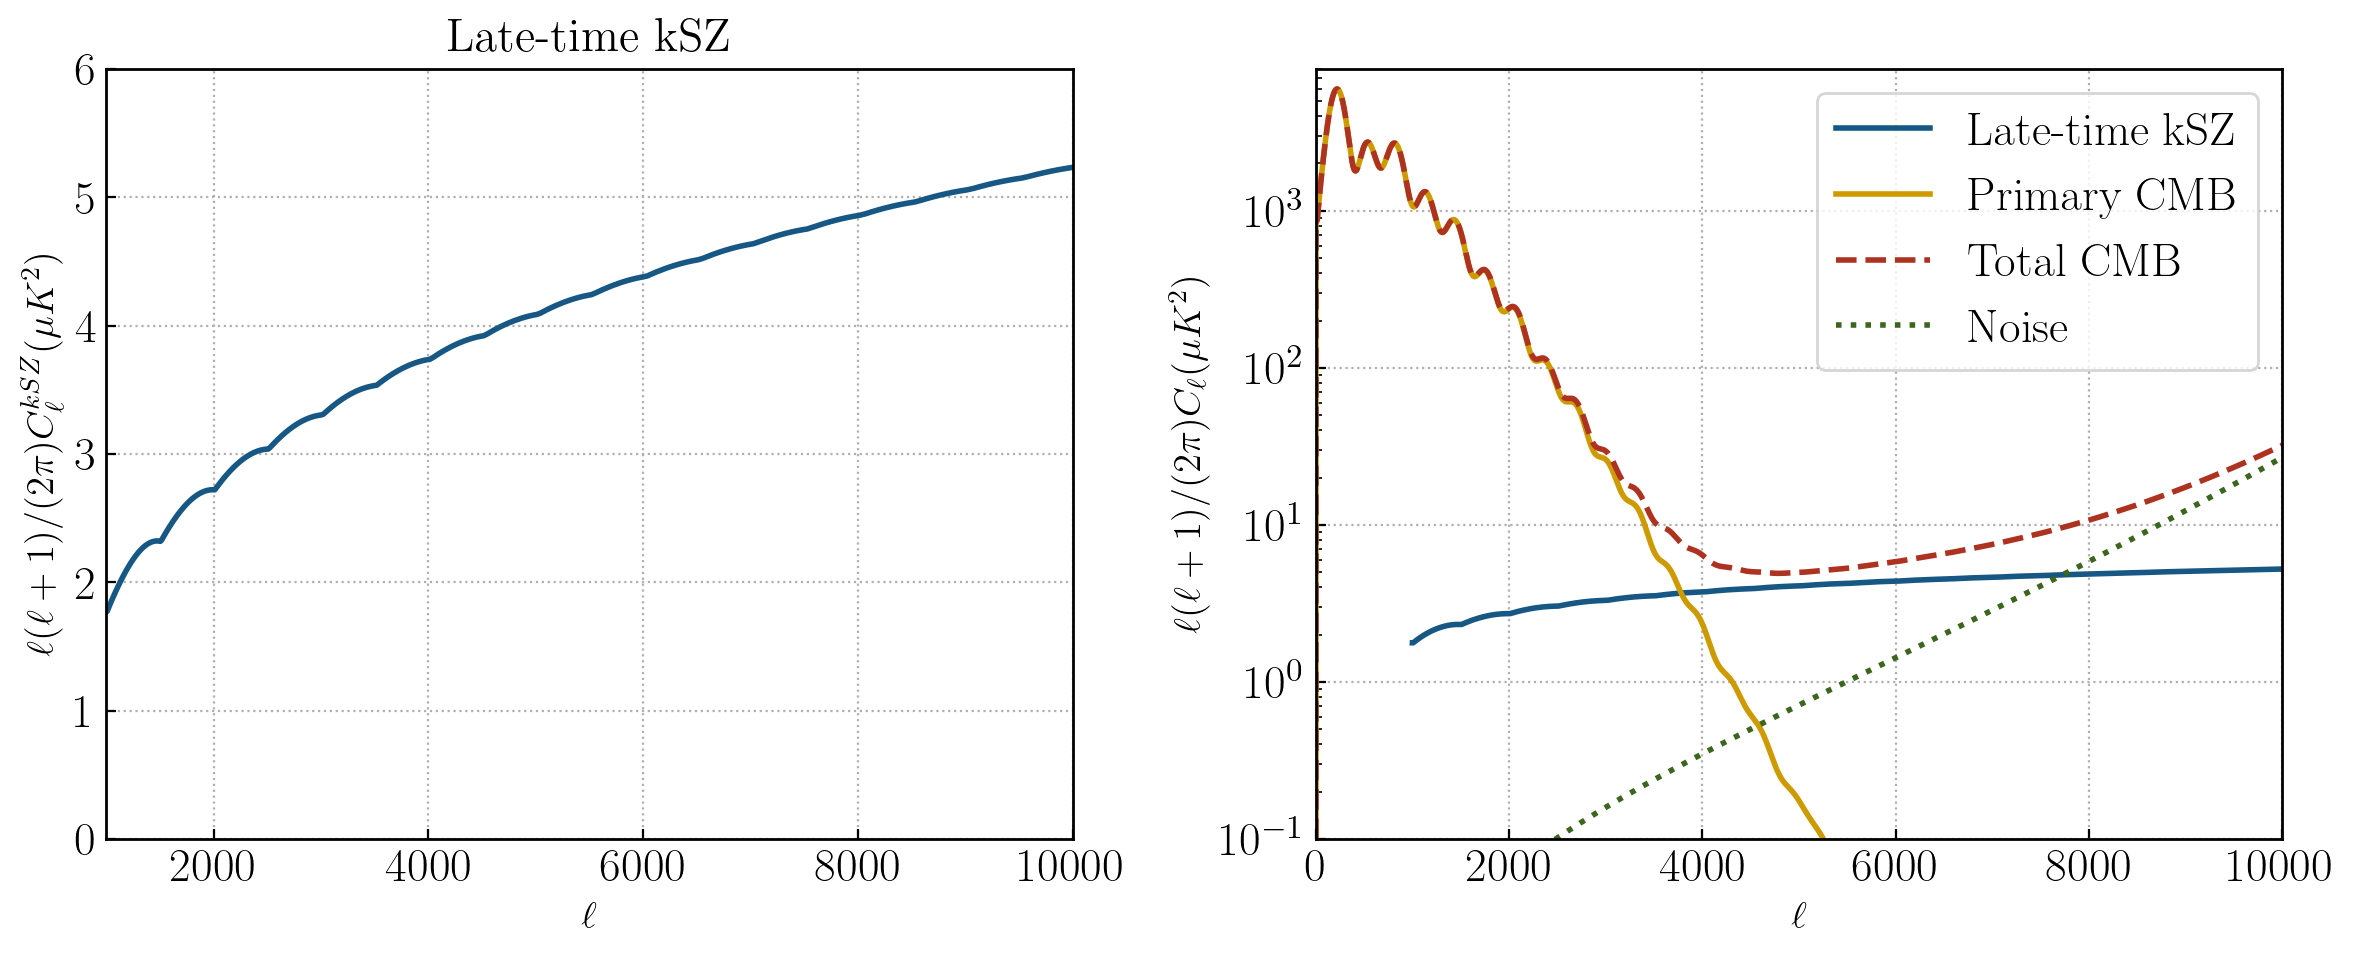

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(ls_kSZ, Cl_kSZ(ls_kSZ)*(ls_kSZ*(ls_kSZ+1))/(2.*np.pi))
plt.ylabel('$\ell(\ell +1)/(2\pi) C^{kSZ}_{\ell} (\mu K^2)$')
plt.xlabel('$\ell$')
plt.xlim(1000, 10000)
plt.ylim(0,6)
plt.title('Late-time kSZ')
plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.plot(ls_kSZ, Cl_kSZ(ls_kSZ)*(ls_kSZ*(ls_kSZ+1))/(2.*np.pi), label='Late-time kSZ')
plt.plot(ls[1:], cl_TT(ls[1:])*(ls[1:]*(ls[1:]+1))/(2*np.pi), label='Primary CMB')
plt.plot(ls_tot, Cl_tot(ls_tot)*(ls_tot*(ls_tot+1))/(2.*np.pi)+noise_TT[1]*(ls_tot*(ls_tot+1))/(2.*np.pi), '--', label='Total CMB')
plt.plot(ls_tot, noise_TT[1]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise')

plt.xlim(0, 10000)
plt.ylim(1e-1, 8e3)
plt.yscale('log')
plt.ylabel('$\ell(\ell +1)/(2\pi) C_{\ell} (\mu K^2)$')
plt.xlabel('$\ell$')
plt.legend(loc='upper right')
plt.grid(linestyle='dotted')
plt.tight_layout()

# Line Intensity Mapping

In [20]:
cosmo_params = dict(
         H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=1, mnu=0.06, nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')


bias_params = dict(
        bv_par=1., bv_perp=1., bT=(m.bavg[0]*m.Tmean).value)#, a=astro_a, b=astro_b, bT=(m.bavg[0]*m.Tmean).value)

# cosmo_model_params, obs_params = lim_params('CII')
# use_z = m.z
# nu, Dnu = Dnu_from_Dz(m.nu, use_z, 1)
# cosmo_model_params['nuObs'] = nu
# obs_params['Delta_nu'] = Dnu
# obs_params['dnu'] = (nu/R).to(u.MHz)
# cosmo_model_params['bv_par'] = bias_params['bv_par']
# cosmo_model_params['bv_perp'] = bias_params['bv_perp']
# m = update_Pkline(obs_params,cosmo_model_params)[0]

k_fid = m.k
k_large = (k_fid[(k_fid >= np.pi/m.Vfield**(1/3))&(k_fid.value <= 0.1)])
mu_L = m.mu

nkL = len(k_large)
nmu = m.nmu

# halo masses
Mh = np.logspace(8,15,200) # Msun
bg = 1.6
bh = 1.6

vol = m.Vfield
delta=0.01
bv_par = m.bv_par
bv_perp = m.bv_perp

Delta_T_S4 = 1.4

Note: redshifts have been re-sorted (earliest first)


In [21]:
_,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
Pvv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
_,Nvv_par,Nvv_perp = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par
Nvv_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.0004, 0.05, '$\\mu=0.9$')

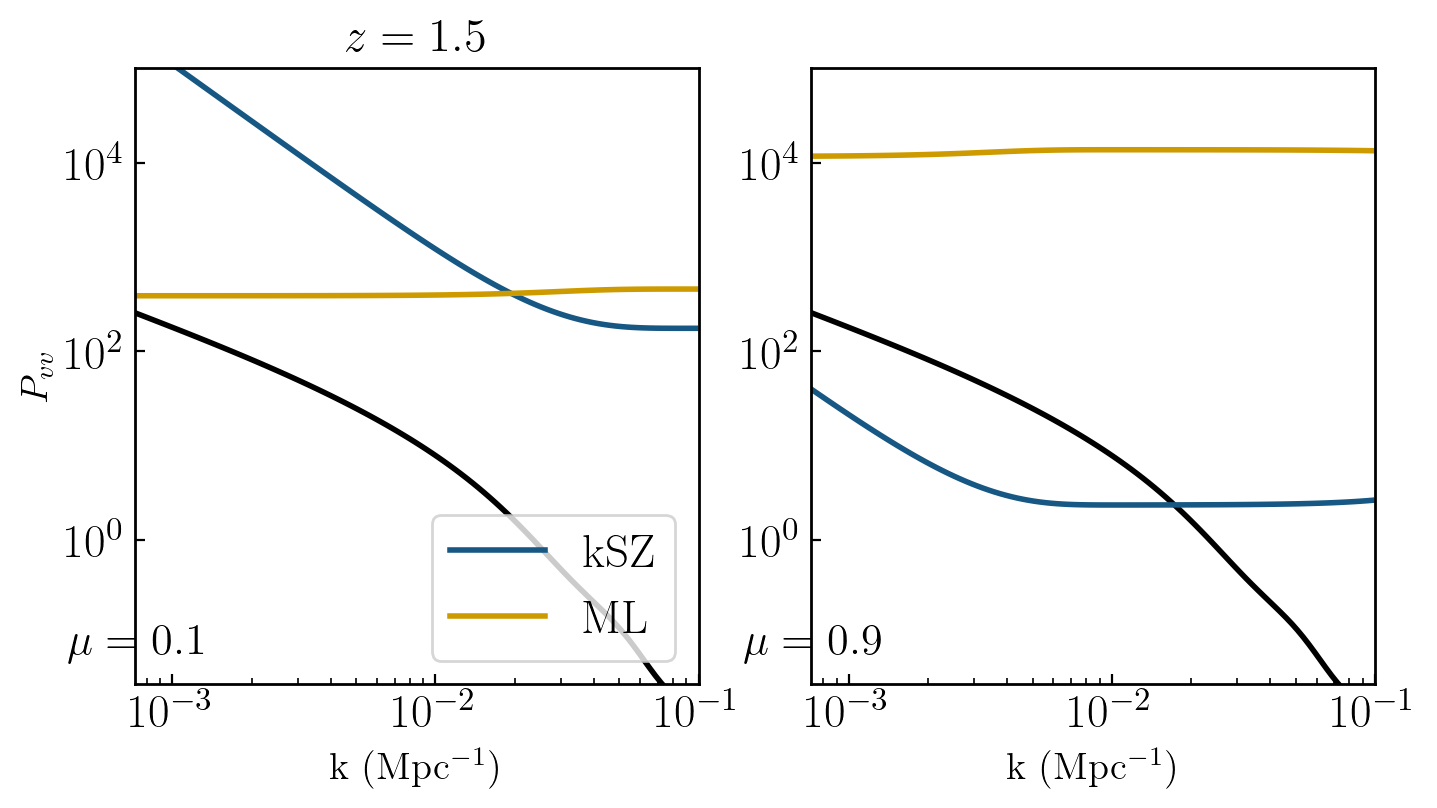

In [22]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='kSZ')
plt.loglog(k_large, Nvv_ML[:,110], color=palette[1], label='ML')
plt.title(r'$z=%g$'%m.z)
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(3e-2,1e5)
#plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.legend(loc='lower right')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel(r'$P_{vv}$')
plt.text(4e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0])
plt.loglog(k_large, Nvv_ML[:,190], color=palette[1])
#plt.title(r'$\mu=0.9$')
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(3e-2,1e5)
plt.xlabel('k (Mpc$^{-1}$)')
plt.text(4e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

#### Test only moving-lens part

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


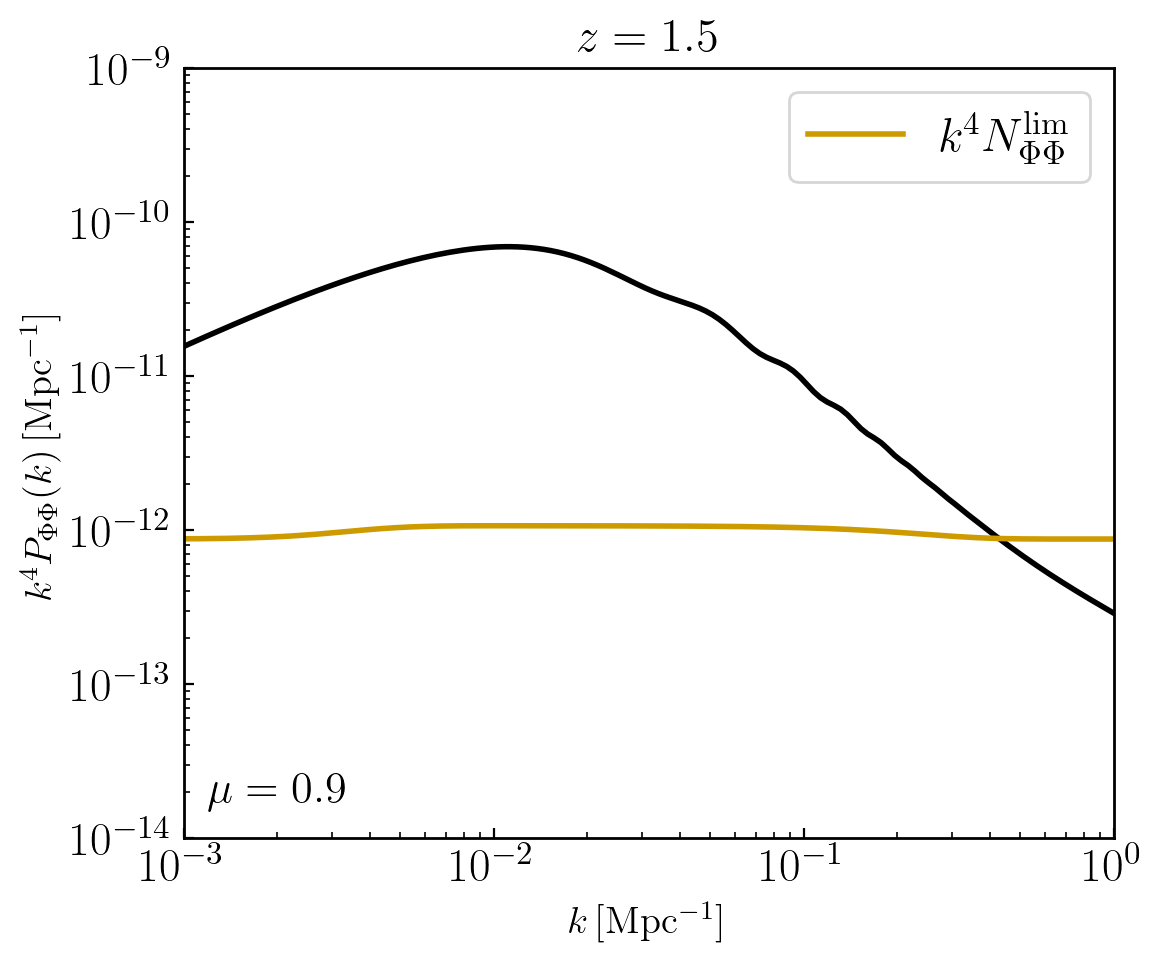

In [14]:

N_xx = m.Pshot*m.Wk + m.Pnoise

zcosmo = np.linspace(0.,15.,101)
cosmo1 = (m.cosmo_input_camb).copy()
cosmo1.pop('f_NL')
camb_pars = camb.set_params(**cosmo1)
camb_pars.set_matter_power(redshifts=list(zcosmo))
cosmo = camb.get_results(camb_pars)
H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value  # 1/Mpc    
omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2

noise_pot = ((1+m.z)*rhoM0/2)**2/((m.k)**4 * (m.bavg[0]*m.Tmean)**2)*N_xx # Mpc^3

interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(m.k.value), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                    k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^-1


plt.loglog(m.k, interp_Pphiphi(m.z, m.k.value), 'k')
plt.loglog(m.k, m.k**4*noise_pot[190,:], label=r'$k^4 N_{\Phi\Phi}^{\mathrm{lim}}$', color=palette[1])
plt.xlim(1e-3,1e0)
plt.ylim(1e-14,1e-9)
#plt.ylim(1e-14,1e2)
plt.title(r'$z=%g$'%m.z)
plt.xlabel(r'$k\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k^4 P_{\Phi \Phi}(k)\,[{\rm Mpc^{-1}}]$')
plt.text(1.2e-3, 1.5e-14, r'$\mu=%g$'%np.round(m.mu[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
plt.legend()

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.0005, 0.05, '$\\mu=0.9$')

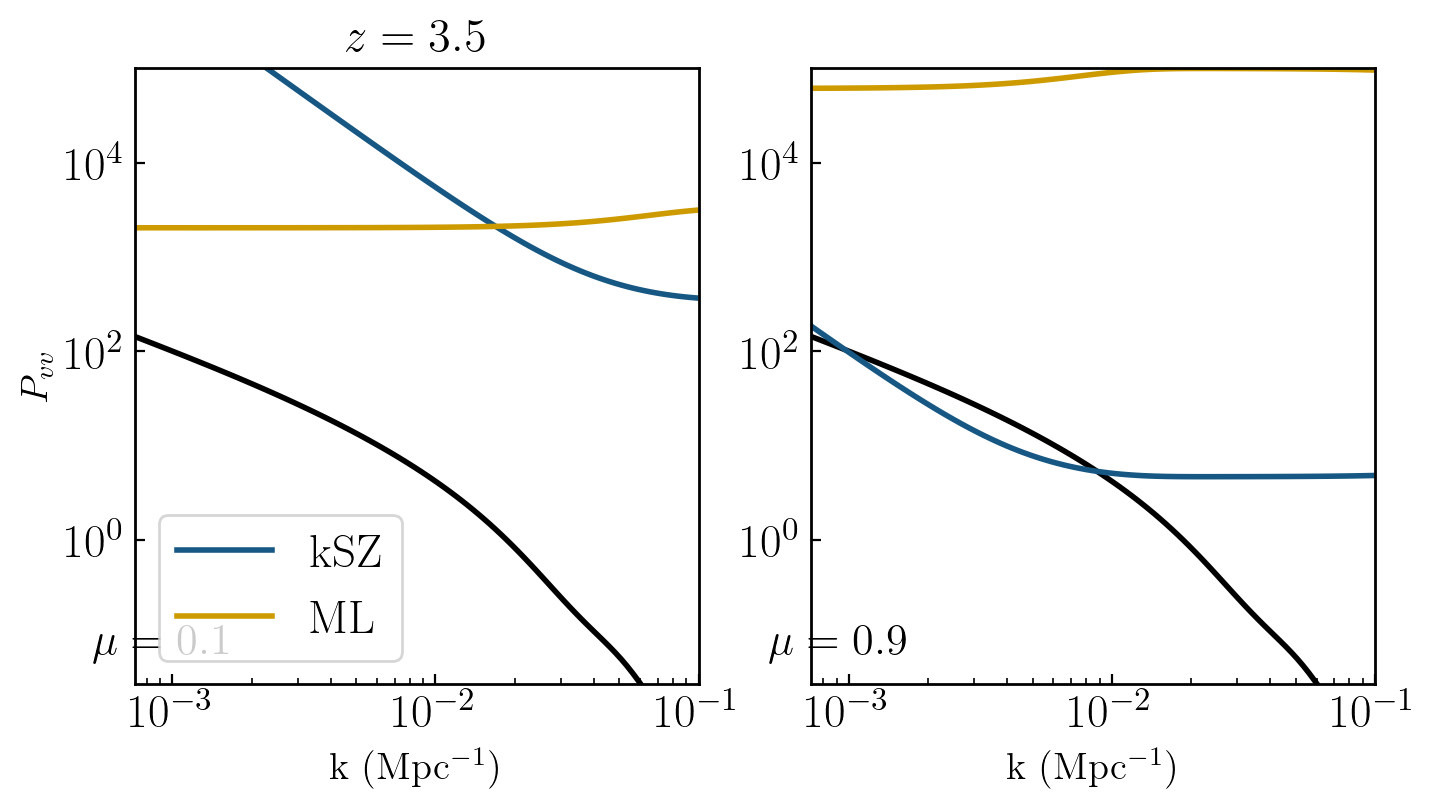

In [19]:
nu, Dnu = Dnu_from_Dz(m.nu, zs[2], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[2]
obs_params['sigma_pix'] = sigpix[2]
m = update_Pkline(obs_params,cosmo_model_params)[0]

_,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
Pvv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
_,Nvv_par,Nvv_perp = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par
Nvv_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp



plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='kSZ')
plt.loglog(k_large, Nvv_ML[:,110], color=palette[1], label='ML')
plt.title(r'$z=%g$'%m.z)
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(3e-2,1e5)
#plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.legend()
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel(r'$P_{vv}$')
plt.text(5e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0])
plt.loglog(k_large, Nvv_ML[:,190], color=palette[1])
#plt.title(r'$\mu=0.9$')
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(3e-2,1e5)
plt.xlabel('k (Mpc$^{-1}$)')
plt.text(5e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

In [17]:
deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']

deriv_PXX=np.zeros((len(free_params), nkL))
deriv_PvX_par=np.zeros((len(free_params), nkL))
deriv_PvX_perp=np.zeros((len(free_params), nkL))
deriv_Pvv_par=np.zeros((len(free_params), nkL))
deriv_Pvv_perp=np.zeros((len(free_params), nkL))
deriv_Pvv_par_perp=np.zeros((len(free_params), nkL))

d_PXX, d_PvX_par, d_PvX_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp = derivs(m, cosmo_params, bias_params, free_params, deltas, k_large)
deriv_PXX=d_PXX[:,:,-1]
deriv_PvX_par=d_PvX_par[:,:,-1]
deriv_PvX_perp=d_PvX_perp[:,:,-1]
deriv_Pvv_par=d_Pvv_par[:,:,-1]
deriv_Pvv_perp=d_Pvv_perp[:,:,-1]
deriv_Pvv_par_perp=d_Pvv_par_perp[:,:,-1]



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

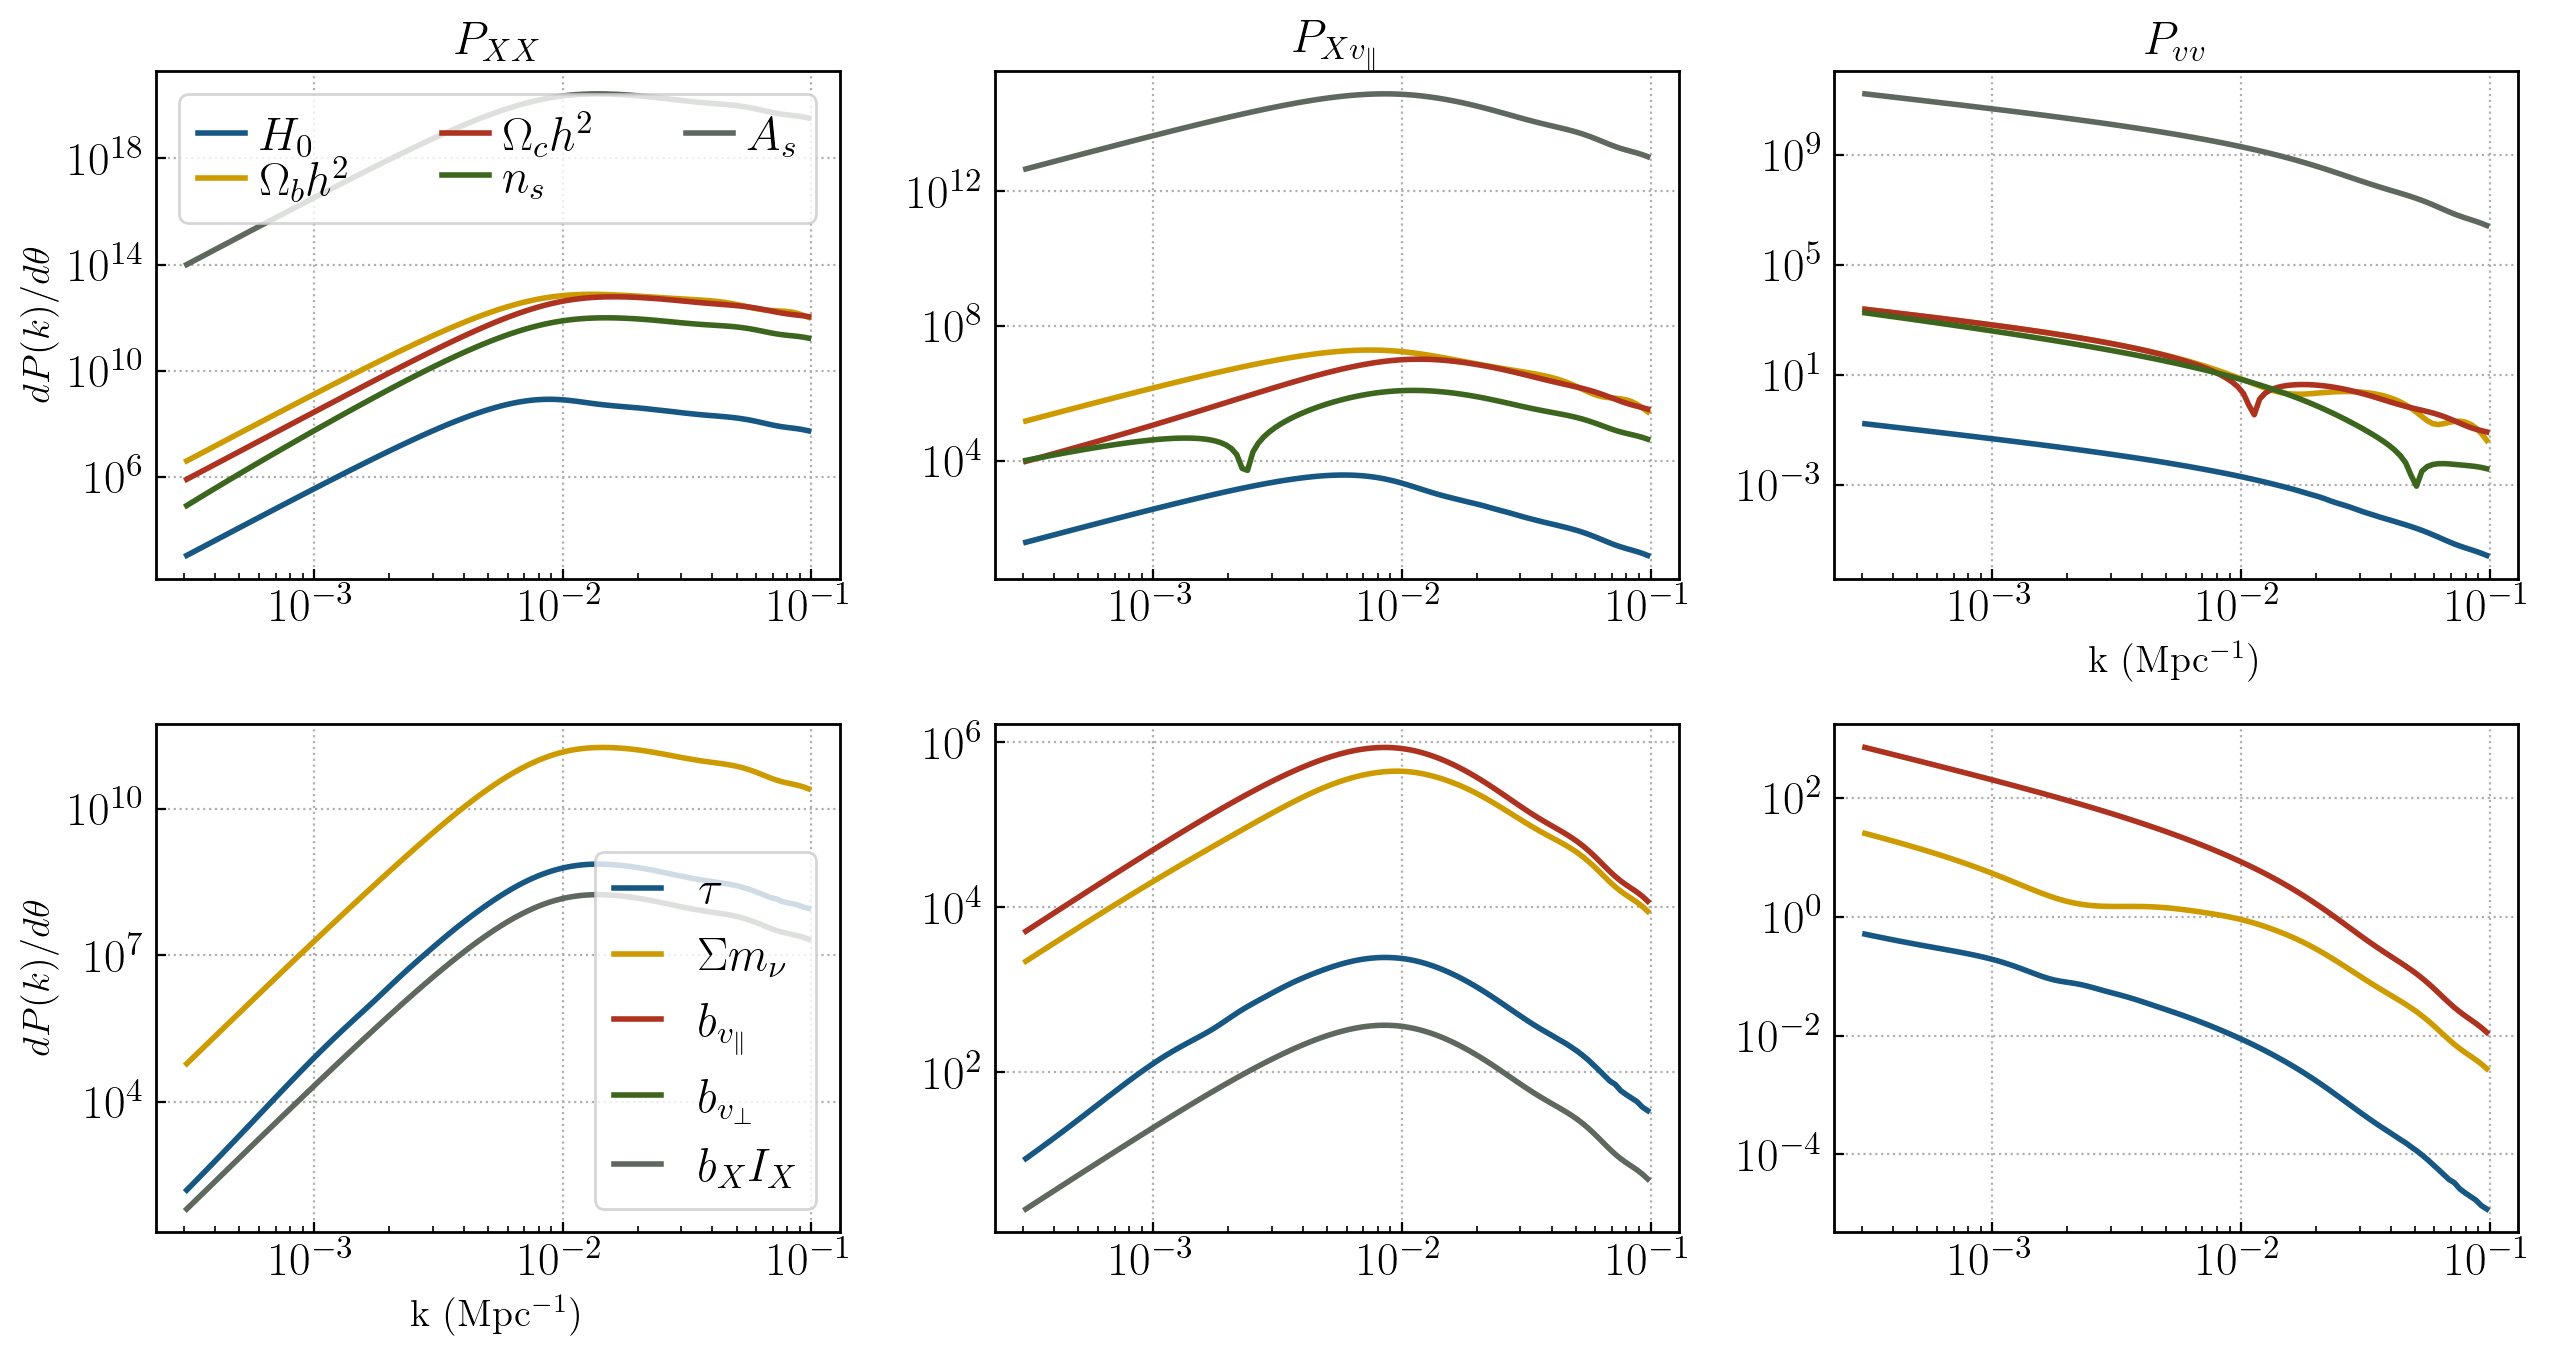

In [18]:
labels = ['$H_0$', r'$\Omega_{b}h^2$', r'$\Omega_{c}h^2$', '$n_s$', '$A_s$', r'$\tau$', r'$\Sigma m_\nu$', '$b_{v_{\parallel}}$', '$b_{v_{\perp}}$', '$b_X I_X$']

plt.figure(figsize=(13,7))
plt.subplot(2,3,1)

plt.loglog(k_large, abs(deriv_PXX[0,:]), color=palette[0], label='%s'%(labels[0]))
plt.loglog(k_large, abs(deriv_PXX[1,:]), color=palette[1], label='%s'%(labels[1]))
plt.loglog(k_large, abs(deriv_PXX[2,:]), color=palette[2], label='%s'%(labels[2]))
plt.loglog(k_large, abs(deriv_PXX[3,:]), color=palette[3], label='%s'%(labels[3]))
plt.loglog(k_large, abs(deriv_PXX[4,:]), color=palette[4], label='%s'%(labels[4]))

#plt.title('z = %g'%m.z)
plt.title(r'$P_{XX}$')
plt.legend(ncol=3, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.ylabel(r'$dP(k)/d \theta$')
plt.grid(linestyle='dotted')

plt.subplot(2,3,2)
plt.loglog(k_large, abs(deriv_PvX_par[0,:]), color=palette[0])
plt.loglog(k_large, abs(deriv_PvX_par[1,:]), color=palette[1])
plt.loglog(k_large, abs(deriv_PvX_par[2,:]), color=palette[2])
plt.loglog(k_large, abs(deriv_PvX_par[3,:]), color=palette[3])
plt.loglog(k_large, abs(deriv_PvX_par[4,:]), color=palette[4])
plt.title(r'$P_{Xv_\parallel}$')
plt.grid(linestyle='dotted')

plt.subplot(2,3,3)
plt.loglog(k_large, abs(deriv_Pvv_par[0,:]), color=palette[0])
plt.loglog(k_large, abs(deriv_Pvv_par[1,:]), color=palette[1])
plt.loglog(k_large, abs(deriv_Pvv_par[2,:]), color=palette[2])
plt.loglog(k_large, abs(deriv_Pvv_par[3,:]), color=palette[3])
plt.loglog(k_large, abs(deriv_Pvv_par[4,:]), color=palette[4])
plt.title(r'$P_{vv}$')

plt.xlabel('k (Mpc$^{-1}$)')
plt.grid(linestyle='dotted')

plt.subplot(2,3,4)
plt.loglog(k_large, abs(deriv_PXX[5,:]), color=palette[0], label='%s'%(labels[5]))
plt.loglog(k_large, abs(deriv_PXX[6,:]), color=palette[1], label='%s'%(labels[6]))
plt.loglog(k_large, abs(deriv_PXX[7,:]), color=palette[2], label='%s'%(labels[7]))
plt.loglog(k_large, abs(deriv_PXX[8,:]), color=palette[3], label='%s'%(labels[8]))
plt.loglog(k_large, abs(deriv_PXX[9,:]), color=palette[4], label='%s'%(labels[9]))
plt.legend(handlelength=1)
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel(r'$dP(k)/d \theta$')
plt.grid(linestyle='dotted')

plt.subplot(2,3,5)
plt.loglog(k_large, abs(deriv_PvX_par[5,:]), color=palette[0])
plt.loglog(k_large, abs(deriv_PvX_par[6,:]), color=palette[1])
plt.loglog(k_large, abs(deriv_PvX_par[7,:]), color=palette[2])
plt.loglog(k_large, abs(deriv_PvX_par[8,:]), color=palette[3])
plt.loglog(k_large, abs(deriv_PvX_par[9,:]), color=palette[4])

plt.grid(linestyle='dotted')

plt.subplot(2,3,6)
plt.loglog(k_large, abs(deriv_Pvv_par[5,:]), color=palette[0])
plt.loglog(k_large, abs(deriv_Pvv_par[6,:]), color=palette[1])
plt.loglog(k_large, abs(deriv_Pvv_par[7,:]), color=palette[2])
plt.loglog(k_large, abs(deriv_Pvv_par[8,:]), color=palette[3])
plt.loglog(k_large, abs(deriv_Pvv_par[9,:]), color=palette[4])


plt.grid(linestyle='dotted')

plt.tight_layout()


#### Some power spectra plots

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


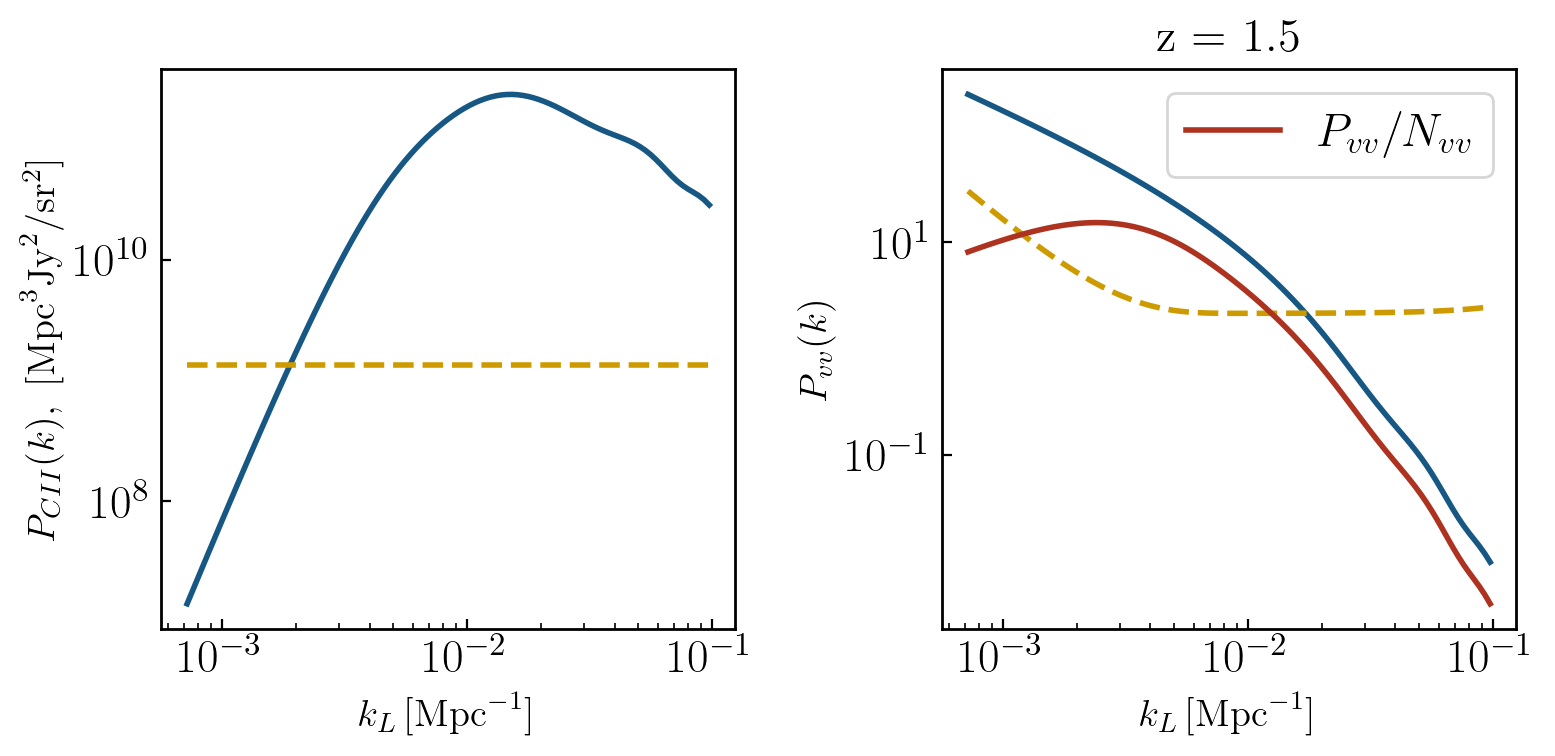

In [20]:
nu, Dnu = Dnu_from_Dz(m.nu, zs[0], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
obs_params['sigma_pix'] = sigpix[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]

P_XX,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
P_vv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
N_XX,Nvv_par,_ = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.loglog(k_large, P_XX[:,-1])
plt.loglog(k_large, N_XX[:,-1], ls='--')
plt.ylabel(r'$P_{CII}(k),\ [\mathrm{Mpc}^3 \mathrm{Jy}^2 / \mathrm{sr}^2]$')
plt.xlabel(r'$k_L \, [\mathrm{Mpc}^{-1}]$')

plt.subplot(1,2,2)
plt.loglog(k_large, P_vv[:,-1])
plt.loglog(k_large, Nvv_kSZ[:,-1], ls='--')
plt.loglog(k_large, (P_vv/Nvv_kSZ)[:,-1], label=r'$P_{vv}/N_{vv}$')
plt.ylabel(r'$P_{vv}(k)$')
plt.xlabel(r'$k_L \, [\mathrm{Mpc}^{-1}]$')
plt.legend()
plt.title('z = %g'%m.z)
plt.tight_layout()

# $\Sigma m_\nu$ analysis

In [21]:
down = False
cosmo_model_params, obs_params = lim_params('CII',down)
cosmo_model_params['cosmo_input_camb'] = cosmo_params
m = update_Pkline(obs_params,cosmo_model_params)[0]

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']


nu, Dnu = Dnu_from_Dz(m.nu, zs[0], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
obs_params['sigma_pix'] = sigpix[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]
bias_params['bT'] = (m.bavg[0]*m.Tmean).value
print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)

vol = m.Vfield
k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

print('LIM:')
covmat_lim, cov_params = covariance_mat(xx, free_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(vx, free_params, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)


Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 389710.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is

#### With redshift bins

In [24]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_LIM=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_LIM=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    Fz_XX_LIM[i,:,:]=xx
    Fz_vX_LIM[i,:,:]=vx



Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 389710.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

In [25]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_AtLAST = np.zeros((Nparams, Nparams))
F_vX_AtLAST = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bT_ind = free_params.index('bT')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_LIM):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_AtLAST[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_AtLAST[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_XX_AtLAST[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_AtLAST[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_LIM):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_AtLAST[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_AtLAST[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vX_AtLAST[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_AtLAST[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]


In [26]:
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_AtLAST, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_AtLAST, all_params, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 1.6903338018941663
1-sigma of ombh2 is 0.00016996525332216652
1-sigma of omch2 is 0.0005648953790533492
1-sigma of ns is 0.005426183566649054
1-sigma of As is 4.860379759393202e-11
1-sigma of tau is 3.095330937680521
1-sigma of mnu is 0.051019665531654455
1-sigma of bT0 is 12.466454270751084
1-sigma of bT1 is 20.837878498615673
1-sigma of bT2 is 35.8049651405164
1-sigma of bT3 is 61.027629434332674

 LIM+kSZ:


1-sigma of H0 is 1.66231487828526
1-sigma of ombh2 is 0.00016991574948453927
1-sigma of omch2 is 0.0005627187087024393
1-sigma of ns is 0.005403858791428064
1-sigma of As is 4.8209203148054246e-11
1-sigma of tau is 3.0863934350246507
1-sigma of mnu is 0.05051519609644598
1-sigma of bv_par is 0.005710562721245742
1-sigma of bv_perp is 0.05976576283551859
1-sigma of bT0 is 12.241665598669533
1-sigma of bT1 is 20.752064894751722
1-sigma of bT2 is 35.68274941412429
1-sigma of bT3 is 60.79638792604036


In [56]:
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_AtLAST, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_AtLAST, all_params, [], {'bv_par':0.01})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 1.6903338018941663
1-sigma of ombh2 is 0.00016996525332216652
1-sigma of omch2 is 0.0005648953790533492
1-sigma of ns is 0.005426183566649054
1-sigma of As is 4.860379759393202e-11
1-sigma of tau is 3.095330937680521
1-sigma of mnu is 0.051019665531654455
1-sigma of bT0 is 12.466454270751084
1-sigma of bT1 is 20.837878498615673
1-sigma of bT2 is 35.8049651405164
1-sigma of bT3 is 61.027629434332674

 LIM+kSZ:


1-sigma of H0 is 1.6570438163109202
1-sigma of ombh2 is 0.00016974449757283468
1-sigma of omch2 is 0.0005549022578679477
1-sigma of ns is 0.005212395613986714
1-sigma of As is 4.7942747459571946e-11
1-sigma of tau is 3.085849937403637
1-sigma of mnu is 0.04959675734071506
1-sigma of bv_par is 0.0049589520174088035
1-sigma of bv_perp is 0.05974760080504823
1-sigma of bT0 is 12.223302183865721
1-sigma of bT1 is 20.210694045554106
1-sigma of bT2 is 35.262086295242746
1-sigma of bT3 is 60.54044984613089


In [73]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
m = update_Pkline(obs_params,cosmo_model_params)[0]

for i in range(len(zs)):
    cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    print((m.bavg[0]*m.Tmean))

Note: redshifts have been re-sorted (earliest first)
2340.7669469925336 Jy / sr
Note: redshifts have been re-sorted (earliest first)
4790.0084831090235 Jy / sr
Note: redshifts have been re-sorted (earliest first)
4522.010528810185 Jy / sr
Note: redshifts have been re-sorted (earliest first)
4264.803105881976 Jy / sr


In [76]:
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_AtLAST, all_params, fixed_params, {'bT0':10,'bT1':10,'bT2':10,'bT3':10})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_AtLAST, all_params, [], {'bT0':10,'bT1':10,'bT2':10,'bT3':10})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 1.2506312769477095
1-sigma of ombh2 is 0.00016760922205643537
1-sigma of omch2 is 0.0004162346196625655
1-sigma of ns is 0.00348158692102229
1-sigma of As is 4.0459279394714645e-11
1-sigma of tau is 3.035758364357475
1-sigma of mnu is 0.046479471648253494
1-sigma of bT0 is 7.035466428486354
1-sigma of bT1 is 7.244650146940076
1-sigma of bT2 is 6.472233743324805
1-sigma of bT3 is 9.251125186614473

 LIM+kSZ:


1-sigma of H0 is 1.2421968466695918
1-sigma of ombh2 is 0.00016759659517066807
1-sigma of omch2 is 0.00041579530360754346
1-sigma of ns is 0.003477696255847432
1-sigma of As is 4.023074336112488e-11
1-sigma of tau is 3.026447629233503
1-sigma of mnu is 0.04617814412210446
1-sigma of bv_par is 0.004981216876016422
1-sigma of bv_perp is 0.05923040197990995
1-sigma of bT0 is 6.990460660600252
1-sigma of bT1 is 7.227300968904464
1-sigma of bT2 is 6.463029809276575
1-sigma of bT3 is 9.246042476141506


In [82]:
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_AtLAST, all_params, fixed_params, {'bT1':10})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_AtLAST, all_params, [], {'bT1':10})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 1.7628723879922028
1-sigma of ombh2 is 0.00016766300160381208
1-sigma of omch2 is 0.0006270030009392182
1-sigma of ns is 0.0046174768235308986
1-sigma of As is 6.369958969974595e-11
1-sigma of tau is 3.1170029941530255
1-sigma of mnu is 0.06352344098054068
1-sigma of bT0 is 11.969682228970159
1-sigma of bT1 is 8.986848964615067
1-sigma of bT2 is 24.335316264190332
1-sigma of bT3 is 52.383378640546134

 LIM+kSZ:


1-sigma of H0 is 1.736897716241996
1-sigma of ombh2 is 0.00016765189996073104
1-sigma of omch2 is 0.0006233522634340118
1-sigma of ns is 0.004600953516368641
1-sigma of As is 6.306626140458908e-11
1-sigma of tau is 3.1094177913438643
1-sigma of mnu is 0.06287522579970177
1-sigma of bv_par is 0.005056729593730836
1-sigma of bv_perp is 0.05923568697607271
1-sigma of bT0 is 11.756595452644323
1-sigma of bT1 is 8.978932322509557
1-sigma of bT2 is 24.13810707602149
1-sigma of bT3 is 51.887127811952


## Plots for paper

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

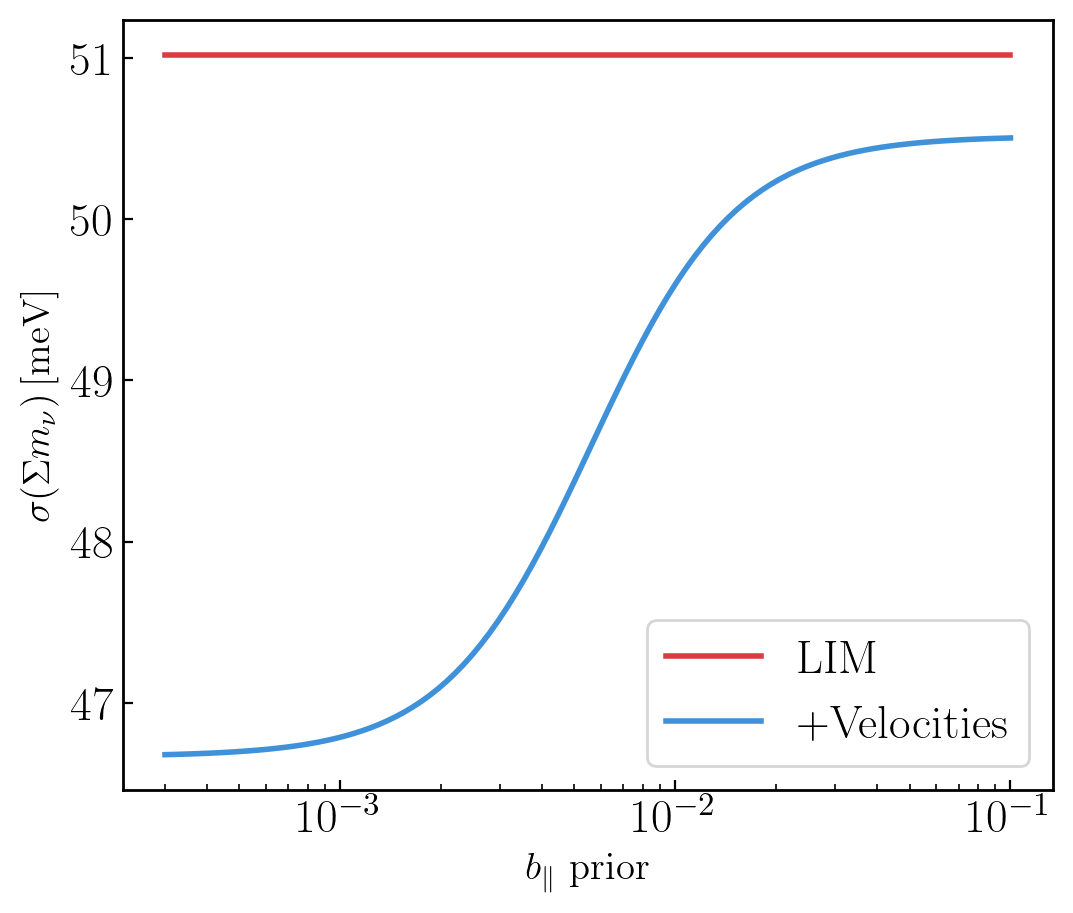

In [27]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
bpar_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_AtLAST, all_params, fixed_params, {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_AtLAST, all_params, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='LIM', color=palette[15])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

In [29]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
bpar_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

F_bao_CMB_lim = np.zeros((len(F_XX_LIM), len(F_XX_LIM)))
F_bao_CMB_lim[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

F_bao_CMB_lim_vel = np.zeros((len(F_vX_LIM), len(F_vX_LIM)))
F_bao_CMB_lim_vel[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_lim+F_XX_LIM, cov_params2, [], {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX_LIM, cov_params3, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='CMB+BAO+LIM', color=palette[15])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

NameError: name 'F_XX_LIM' is not defined

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

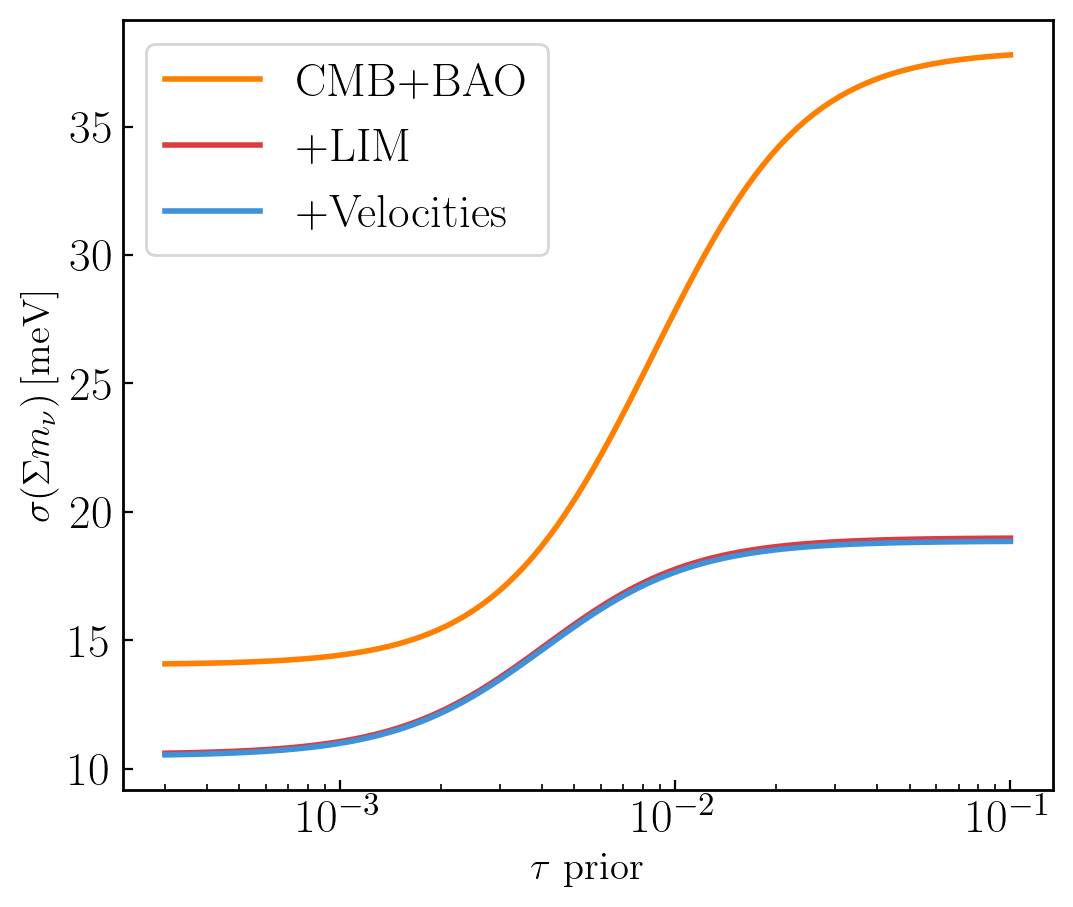

In [30]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
tau_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu = np.zeros(len(tau_pr))
sig_mnu_lim = np.zeros(len(tau_pr))
sig_mnu_lim_vel = np.zeros(len(tau_pr))

F_bao_CMB_lim = np.zeros((len(F_XX_AtLAST), len(F_XX_AtLAST)))
F_bao_CMB_lim[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

F_bao_CMB_lim_vel = np.zeros((len(F_vX_AtLAST), len(F_vX_AtLAST)))
F_bao_CMB_lim_vel[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

for i in range(len(tau_pr)):
    covmat, cov_params = covariance_mat(F_bao_CMB, free_params2, [], {'tau':tau_pr[i]})
    sig_mnu[i] = np.sqrt(covmat[mnu_ind,mnu_ind])
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_lim+F_XX_AtLAST, all_params, fixed_params, {'tau':tau_pr[i]})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX_AtLAST, all_params, [], {'tau':tau_pr[i], 'bv_par':0.01})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(tau_pr, sig_mnu*1e3, label='CMB+BAO', color=palette[6])
plt.plot(tau_pr, sig_mnu_lim*1e3, label='+LIM', color=palette[15])
plt.plot(tau_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\tau$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

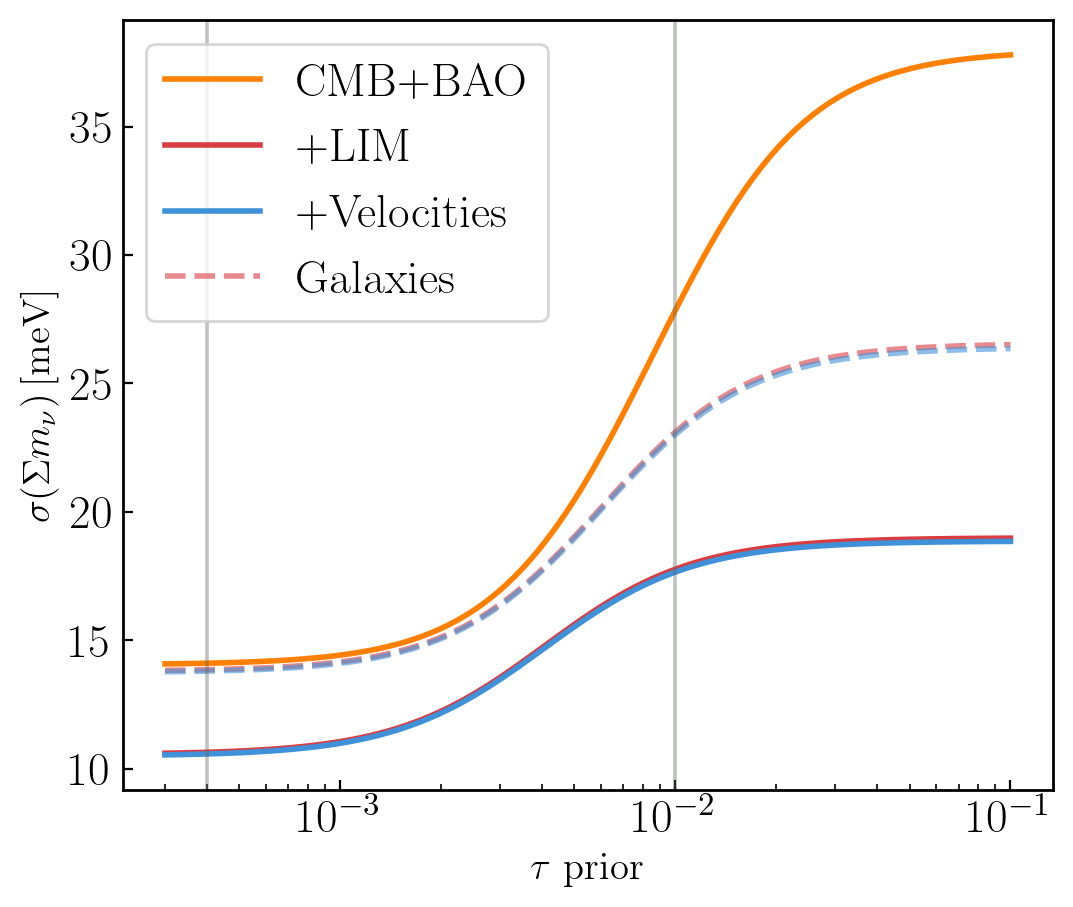

In [31]:
vm_root = '/media/HostShared/galaxies/'

sig_mnu_gal = np.loadtxt(vm_root+'sig_mnu_VRO10.txt')
sig_mnu_gal_vel = np.loadtxt(vm_root+'sig_mnu_VRO10_vel.txt')

tau_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu = np.zeros(len(tau_pr))
sig_mnu_lim = np.zeros(len(tau_pr))
sig_mnu_lim_vel = np.zeros(len(tau_pr))

F_bao_CMB_lim = np.zeros((len(F_XX_AtLAST), len(F_XX_AtLAST)))
F_bao_CMB_lim[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

F_bao_CMB_lim_vel = np.zeros((len(F_vX_AtLAST), len(F_vX_AtLAST)))
F_bao_CMB_lim_vel[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

for i in range(len(tau_pr)):
    covmat, cov_params = covariance_mat(F_bao_CMB, free_params2, [], {'tau':tau_pr[i]})
    sig_mnu[i] = np.sqrt(covmat[mnu_ind,mnu_ind])
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_lim+F_XX_AtLAST, all_params, fixed_params, {'tau':tau_pr[i]})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX_AtLAST, all_params, [], {'tau':tau_pr[i], 'bv_par':0.01})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(tau_pr, sig_mnu*1e3, label='CMB+BAO', color=palette[6])
plt.plot(tau_pr, sig_mnu_lim*1e3, label='+LIM', color=palette[15])
plt.plot(tau_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.plot(tau_pr, sig_mnu_gal*1e3, ls='--', color=palette[15], alpha=0.6, label='Galaxies')
plt.plot(tau_pr, sig_mnu_gal_vel*1e3, ls='--', color=palette[14], alpha=0.6)
plt.axvline(x = 0.01, color = palette[4], alpha=0.4, lw=1.3)
plt.axvline(x = 4e-4, color = palette[4], alpha=0.4, lw=1.3)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\tau$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

## 2D grid plot

In [ ]:
Omegas = np.logspace(np.log10(370), np.log10(20450), 5)
tobss = np.linspace(1000, 13000, 5)


cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
m = update_Pkline(obs_params,cosmo_model_params)[0]

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']


F_XX_om_tob = []
F_vX_om_tob = []

F_XX_om_tob = np.zeros((len(Omegas),len(tobss),len(free_params),len(free_params)))
F_vX_om_tob = np.zeros((len(Omegas),len(tobss),len(free_params),len(free_params)))

Fz_XX_LIM = np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_LIM = np.zeros((len(zs),len(free_params),len(free_params)))
for o in range(len(Omegas)):
    for t in range(len(tobss)):
        obs_params['Omega_field'] = Omegas[o]*u.deg**2
        obs_params['tobs'] = tobss[t]*u.h
        for i in range(len(zs)):  
            nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
            cosmo_model_params['nuObs'] = nu
            obs_params['Delta_nu'] = Dnu
            obs_params['dnu'] = (nu/R).to(u.MHz)
            obs_params['beam_FWHM'] = beam[i]
            obs_params['sigma_pix'] = sigpix[i]
            m = update_Pkline(obs_params,cosmo_model_params)[0]
            bias_params['bT'] = (m.bavg[0]*m.Tmean).value
            print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

            vol = m.Vfield
            xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
            
            Fz_XX_LIM[i,:,:] = xx
            Fz_vX_LIM[i,:,:] = vx

        F_XX_LIM = np.zeros((Nparams, Nparams))
        F_vX_LIM = np.zeros((Nparams, Nparams))
        
        # Add each individual Fisher matrix to the combined Fisher matrix
        for i, F in enumerate(Fz_XX_LIM):
            # Indices for the LCDM parameters
            for j, param1 in enumerate(lcdm_params):
                for k, param2 in enumerate(lcdm_params):
                    F_XX_LIM[param_indices[param1], param_indices[param2]] += F[j, k]

            # Indices for the LCDM parameters and bg parameter for this redshift bin
            bT_param = f'bT{i}'
            for j, param1 in enumerate(lcdm_params):
                F_XX_LIM[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
                F_XX_LIM[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

            # Index for the bg parameter for this redshift bin
            F_XX_LIM[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

        # Add each individual Fisher matrix to the combined Fisher matrix
        for i, F in enumerate(Fz_vX_LIM):
            # Indices for the LCDM parameters
            for j, param1 in enumerate(lcdm_params):
                for k, param2 in enumerate(lcdm_params):
                    F_vX_LIM[param_indices[param1], param_indices[param2]] += F[j, k]

            # Indices for the LCDM parameters and bg parameter for this redshift bin
            bT_param = f'bT{i}'
            for j, param1 in enumerate(lcdm_params):
                F_vX_LIM[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
                F_vX_LIM[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

            # Index for the bg parameter for this redshift bin
            F_vX_LIM[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

        
        F_vX_om_tob[o,t] = F_vX_LIM
        F_XX_om_tob[o,t] = F_XX_LIM
    
    

with open(fisher_root+'F_vX_omega_tobs_AtLAST_scale-dep-f.pkl', 'wb') as file: 
    pickle.dump(F_vX_om_tob, file)
    
with open(fisher_root+'F_XX_omega_tob_AtLAST_scale-dep-f.pkl', 'wb') as file: 
    pickle.dump(F_XX_om_tob, file)

In [ ]:
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']
cov_params2 = free_params.copy()
cov_params2.remove(fixed_params[0])
cov_params2.remove(fixed_params[1])
cov_params2.remove('bT')
cov_params3 = free_params.copy()
cov_params3.remove('bT')

sig_mnu_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_pr_grid = np.zeros((len(Omegas), len(tobss)))

mnu_ind = free_params.index('mnu')

for o in range(len(Omegas)):
    for t in range(len(tobss)):
        F_XX = F_XX_om_tob[o,t]
        F_vX = F_vX_om_tob[o,t]
        
        covmat_lim, cov_params = covariance_mat(F_XX, all_params, fixed_params, {})
        sig_mnu_grid[o,t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_vX, all_params, [], {'bv_par':0.01})
        sig_mnu_vel_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])


xx = sig_mnu_grid*1e3
vx = sig_mnu_vel_grid*1e3


plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

plt.contourf(tobss, Omegas, xx, cmap='plasma')#, vmin=50, vmax=400)
plt.colorbar(label=r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')#, ticks=np.linspace(50, 400, 5))

# Calculate the positions for the grid lines
tobs_midpoints = (tobss[:-1] + tobss[1:]) / 2
omega_midpoints = (Omegas[:-1] + Omegas[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints):
    for j, omega in enumerate(omega_midpoints):
        plt.text(tobs, omega, f'{xx[j, i]:.0f}', ha='center', va='center', color='white', fontsize=17)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{sky}$ [deg$^2$]')
plt.yscale('log')
plt.xlim(tobss[0], tobss[-1])
plt.ylim(Omegas[0], Omegas[-1])



plt.subplot(1,2,2)

plt.contourf(tobss, Omegas, (xx-vx)/xx*100, cmap='plasma', vmin=0, vmax=50)
plt.colorbar(label='Percentage improvement with velocities')

# Calculate the positions for the grid lines
tobs_midpoints = (tobss[:-1] + tobss[1:]) / 2
omega_midpoints = (Omegas[:-1] + Omegas[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints):
    for j, omega in enumerate(omega_midpoints):
        plt.text(tobs, omega, f'{((xx-vx)/xx*100)[j, i]:.0f}\%', ha='center', va='center', color='white', fontsize=17)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{sky}$ [deg$^2$]')
plt.title(r'with 1\% prior on $b_\parallel$')
plt.yscale('log')
plt.xlim(tobss[0], tobss[-1])
plt.ylim(Omegas[0], Omegas[-1])

Test how cconstraints change when increasing $\sigma_\mathrm{pix}$ and $\theta_\mathrm{FWHM}$

In [59]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_sigpix=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_sigpix=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]*10
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    Fz_XX_sigpix[i,:,:]=xx
    Fz_vX_sigpix[i,:,:]=vx


Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 3897100.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this i



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

In [60]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_sigpix = np.zeros((Nparams, Nparams))
F_vX_sigpix = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bT_ind = free_params.index('bT')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_sigpix):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_sigpix[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_sigpix[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_XX_sigpix[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_sigpix[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_sigpix):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_sigpix[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_sigpix[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vX_sigpix[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_sigpix[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

    
    
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_sigpix, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_sigpix, all_params, [], {'bv_par':0.01})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 6.297705318859303
1-sigma of ombh2 is 0.00033622449539024514
1-sigma of omch2 is 0.0011514467411764264
1-sigma of ns is 0.010312403150120256
1-sigma of As is 9.302524275674965e-11
1-sigma of tau is 6.143872072449958
1-sigma of mnu is 0.10568702045336491
1-sigma of bT0 is 49.443805262081945
1-sigma of bT1 is 48.73478740817102
1-sigma of bT2 is 71.39283530004872
1-sigma of bT3 is 120.82326648641384

 LIM+kSZ:


1-sigma of H0 is 6.275557894345903
1-sigma of ombh2 is 0.0003358556096623908
1-sigma of omch2 is 0.001141211933203445
1-sigma of ns is 0.010104394751311536
1-sigma of As is 9.267302769538442e-11
1-sigma of tau is 6.141605722835019
1-sigma of mnu is 0.10476891255739183
1-sigma of bv_par is 0.009507151993928337
1-sigma of bv_perp is 0.6621083727880333
1-sigma of bT0 is 49.32202793558381
1-sigma of bT1 is 48.12267778797205
1-sigma of bT2 is 70.67139237844403
1-sigma of bT3 is 120.17054805791489


In [61]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_beam=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_beam=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]*10
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    Fz_XX_beam[i,:,:]=xx
    Fz_vX_beam[i,:,:]=vx


Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 20.0 arcsec 38970.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

In [62]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_beam = np.zeros((Nparams, Nparams))
F_vX_beam = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bT_ind = free_params.index('bT')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_beam):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_beam[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_beam[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_XX_beam[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_beam[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_beam):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_beam[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_beam[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vX_beam[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_beam[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

    
    
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_beam, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_beam, all_params, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 1.718571111532002
1-sigma of ombh2 is 0.00016992548928551306
1-sigma of omch2 is 0.0005640876173310417
1-sigma of ns is 0.005442534160876276
1-sigma of As is 4.854165558199082e-11
1-sigma of tau is 3.0955086302847667
1-sigma of mnu is 0.05124172627308403
1-sigma of bT0 is 12.43205476455621
1-sigma of bT1 is 20.910441163766553
1-sigma of bT2 is 36.53708319111826
1-sigma of bT3 is 62.1570716565064

 LIM+kSZ:


1-sigma of H0 is 1.6998314566978634
1-sigma of ombh2 is 0.00016990436496214296
1-sigma of omch2 is 0.0005628391870740973
1-sigma of ns is 0.005431241288864167
1-sigma of As is 4.8343011372847626e-11
1-sigma of tau is 3.0923912065337396
1-sigma of mnu is 0.05099284671494652
1-sigma of bv_par is 0.00679930685128958
1-sigma of bv_perp is 0.05684646955272689
1-sigma of bT0 is 12.287406576854822
1-sigma of bT1 is 20.866813253067345
1-sigma of bT2 is 36.452221980610034
1-sigma of bT3 is 61.991953799745524


## Downgrade AtLAST experiment
The tests to determine which specs to use are below. We chose to use these specs so that the results are comparable with the ones for galaxy survey VRO10. This will give us an early-AtLAST experiment since the results will be available sooner (not necessarily less instrumental noise since we observe smaller sky area).

In [32]:

down = True
cosmo_model_params, obs_params = lim_params('CII',down)
m = update_Pkline(obs_params,cosmo_model_params)[0]

nu, Dnu = Dnu_from_Dz(m.nu, zs[0], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
obs_params['sigma_pix'] = sigpix[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]

k_large = (m.k[(m.k >= np.pi/m.Vfield**(1/3))&(m.k.value <= 0.1)])

print(m.Omega_field, m.tobs)
print(m.sigma_N, m.Pnoise)

Note: redshifts have been re-sorted (earliest first)
1000.0 deg2 3000.0 h
259803.06644328378 Jy / sr 600693409.963488 Jy2 Mpc3 / sr2


Note: redshifts have been re-sorted (earliest first)


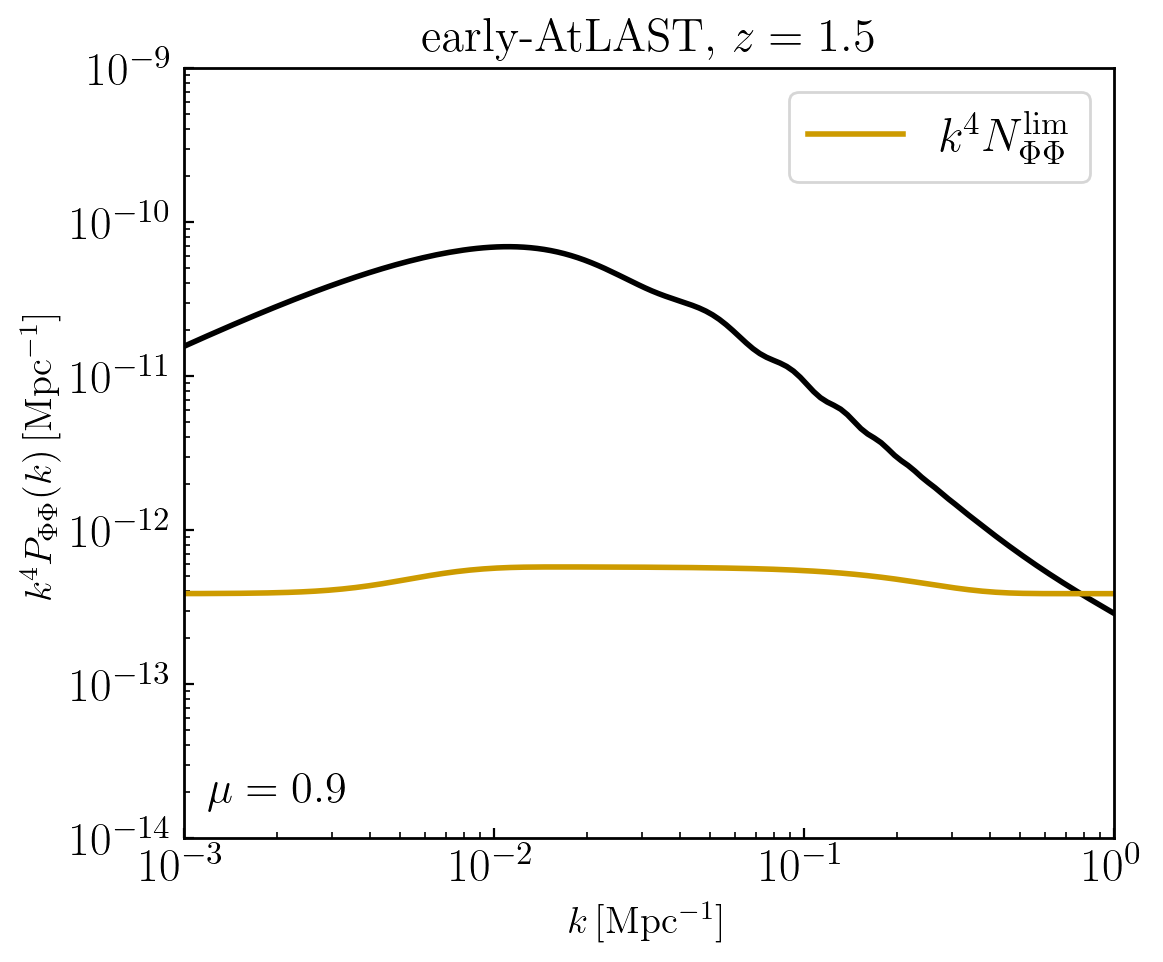

In [33]:
N_xx = m.Pshot*m.Wk + m.Pnoise

zcosmo = np.linspace(0.,15.,101)
cosmo1 = (m.cosmo_input_camb).copy()
cosmo1.pop('f_NL')
camb_pars = camb.set_params(**cosmo1)
camb_pars.set_matter_power(redshifts=list(zcosmo))
cosmo = camb.get_results(camb_pars)
H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value  # 1/Mpc    
omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2

noise_pot = ((1+m.z)*rhoM0/2)**2/((m.k)**4 * (m.bavg[0]*m.Tmean)**2)*N_xx # Mpc^3

interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(m.k.value), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                    k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^-1


plt.loglog(m.k, interp_Pphiphi(m.z, m.k.value), 'k')
plt.loglog(m.k, m.k**4*noise_pot[190,:], label=r'$k^4 N_{\Phi\Phi}^{\mathrm{lim}}$', color=palette[1])
plt.xlim(1e-3,1e0)
plt.ylim(1e-14,1e-9)
#plt.ylim(1e-14,1e2)
plt.title(r'early-AtLAST, $z=%g$'%m.z)
plt.xlabel(r'$k\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k^4 P_{\Phi \Phi}(k)\,[{\rm Mpc^{-1}}]$')
plt.text(1.2e-3, 1.5e-14, r'$\mu=%g$'%np.round(m.mu[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
plt.legend()

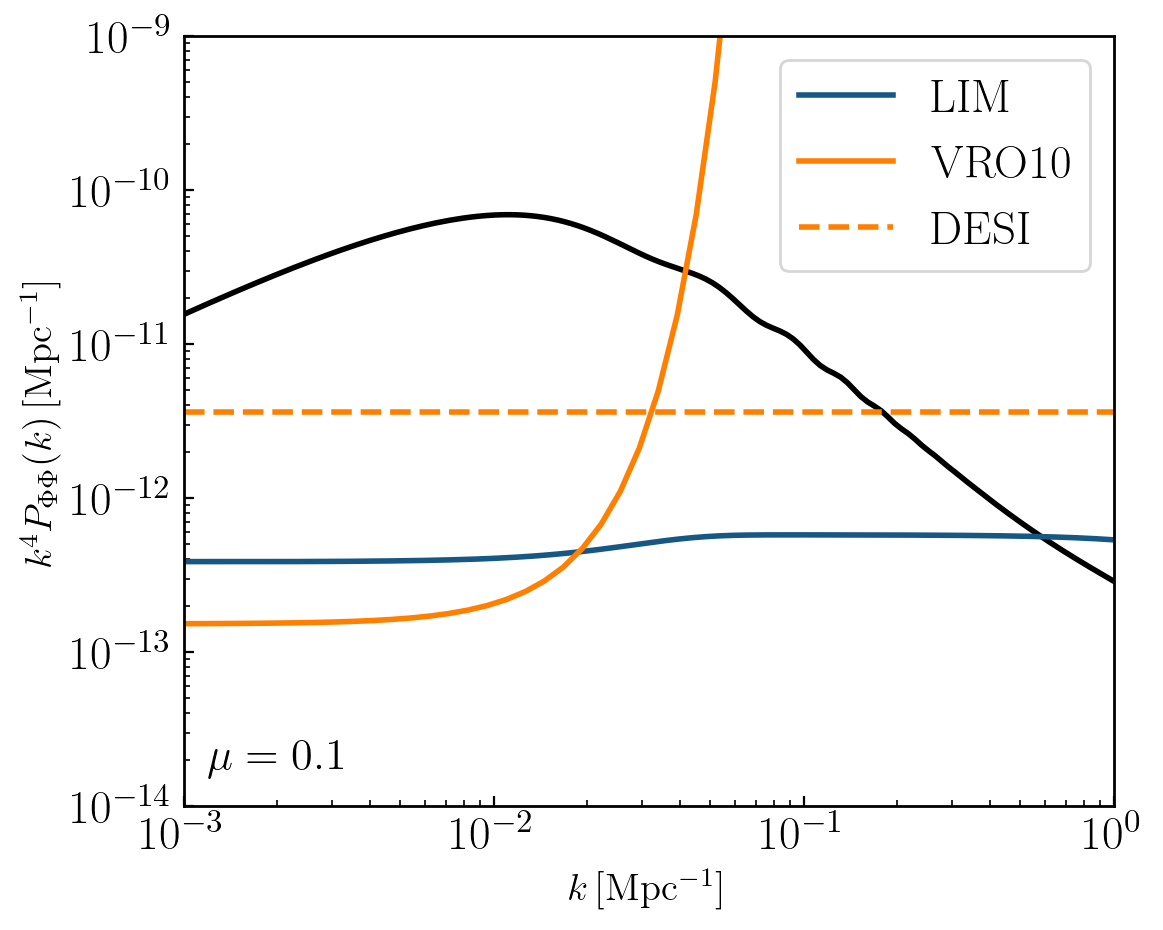

In [34]:
vm_root = '/media/HostShared/galaxies/'

noise_pot_VRO10 = np.loadtxt(vm_root+'noise_pot_VRO10_01.txt')
noise_pot_DESI = np.loadtxt(vm_root+'noise_pot_DESI_01.txt')
k_vec_VRO10 = np.loadtxt(vm_root+'kvec_noise_pot.txt')

plt.loglog(m.k, interp_Pphiphi(m.z, m.k.value), 'k')
plt.loglog(m.k, m.k**4*noise_pot[110,:], label=r'LIM', color=palette[0])
plt.loglog(k_vec_VRO10, noise_pot_VRO10, label=r'VRO10', color=palette[6])
plt.loglog(k_vec_VRO10, noise_pot_DESI, ls='--', label=r'DESI', color=palette[6])


plt.xlim(1e-3,1e0)
plt.ylim(1e-14,1e-9)
plt.xlabel(r'$k\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k^4 P_{\Phi \Phi}(k)\,[{\rm Mpc^{-1}}]$')
plt.text(1.2e-3, 1.5e-14, r'$\mu=%g$'%np.round(m.mu[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
plt.legend()

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.0004, 0.05, '$\\mu=0.9$')

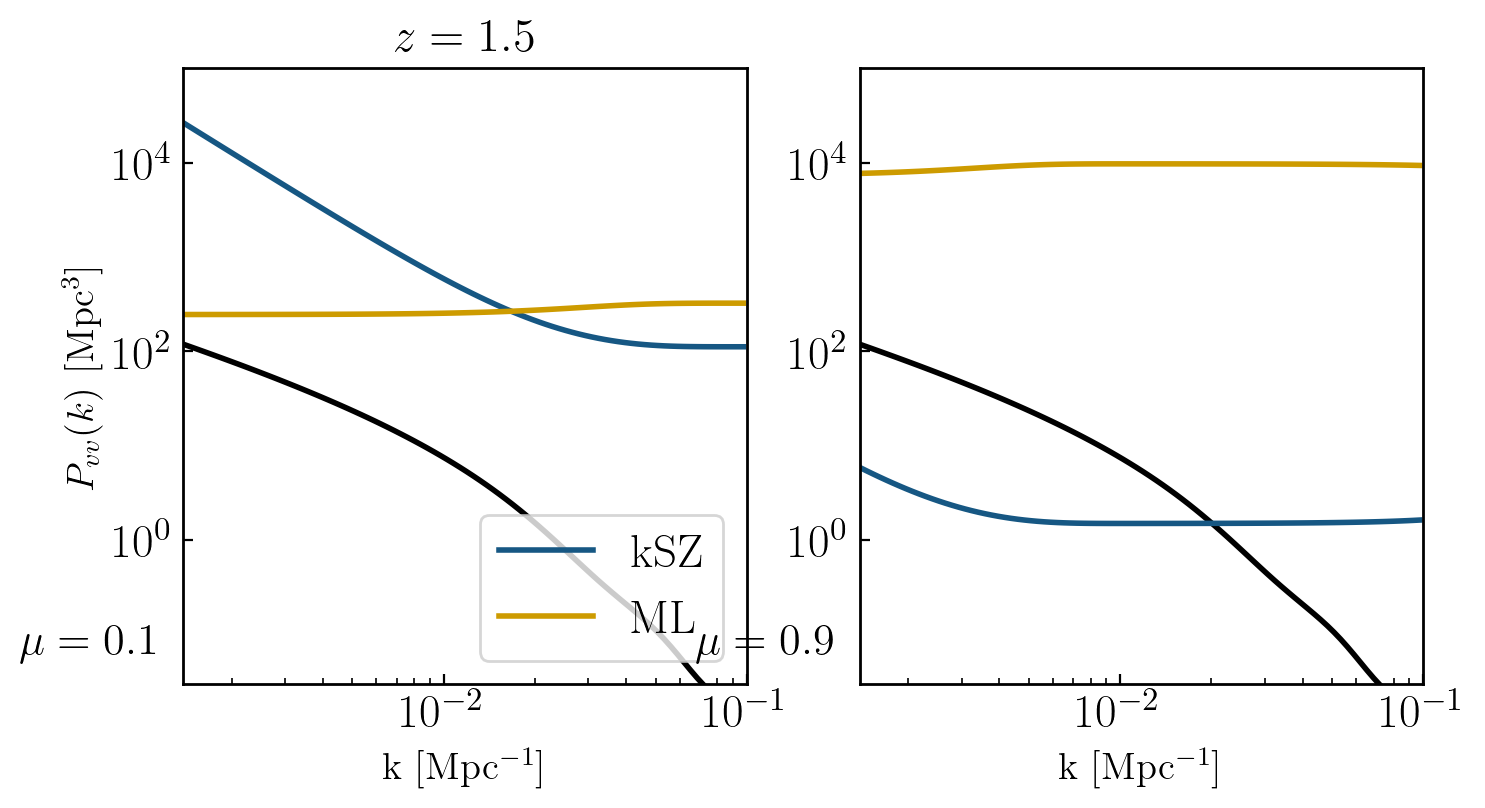

In [35]:
_,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
Pvv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
_,Nvv_par,Nvv_perp = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par
Nvv_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp



plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='kSZ')
plt.loglog(k_large, Nvv_ML[:,110], color=palette[1], label='ML')
plt.title(r'$z=%g$'%m.z)
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(3e-2,1e5)
#plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.legend(loc='lower right')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_{vv}(k)$ [Mpc$^3$]')
plt.text(4e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0])
plt.loglog(k_large, Nvv_ML[:,190], color=palette[1])
#plt.title(r'$\mu=0.9$')
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(3e-2,1e5)
plt.xlabel('k [Mpc$^{-1}$]')
plt.text(4e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

In [36]:
vm_root = '/media/HostShared/galaxies/'

Nvv_VRO10_kSZ = np.loadtxt(vm_root+'Nvv_VRO10_kSZ.txt')
Nvv_DESI_kSZ = np.loadtxt(vm_root+'Nvv_DESI_kSZ.txt')
k_large_VRO10 = np.loadtxt(vm_root+'k_large_VRO10.txt')
mu_L_VRO10 = np.loadtxt(vm_root+'mu_L_VRO10.txt')

Text(0.0016, 0.02, '$\\mu=0.9$')

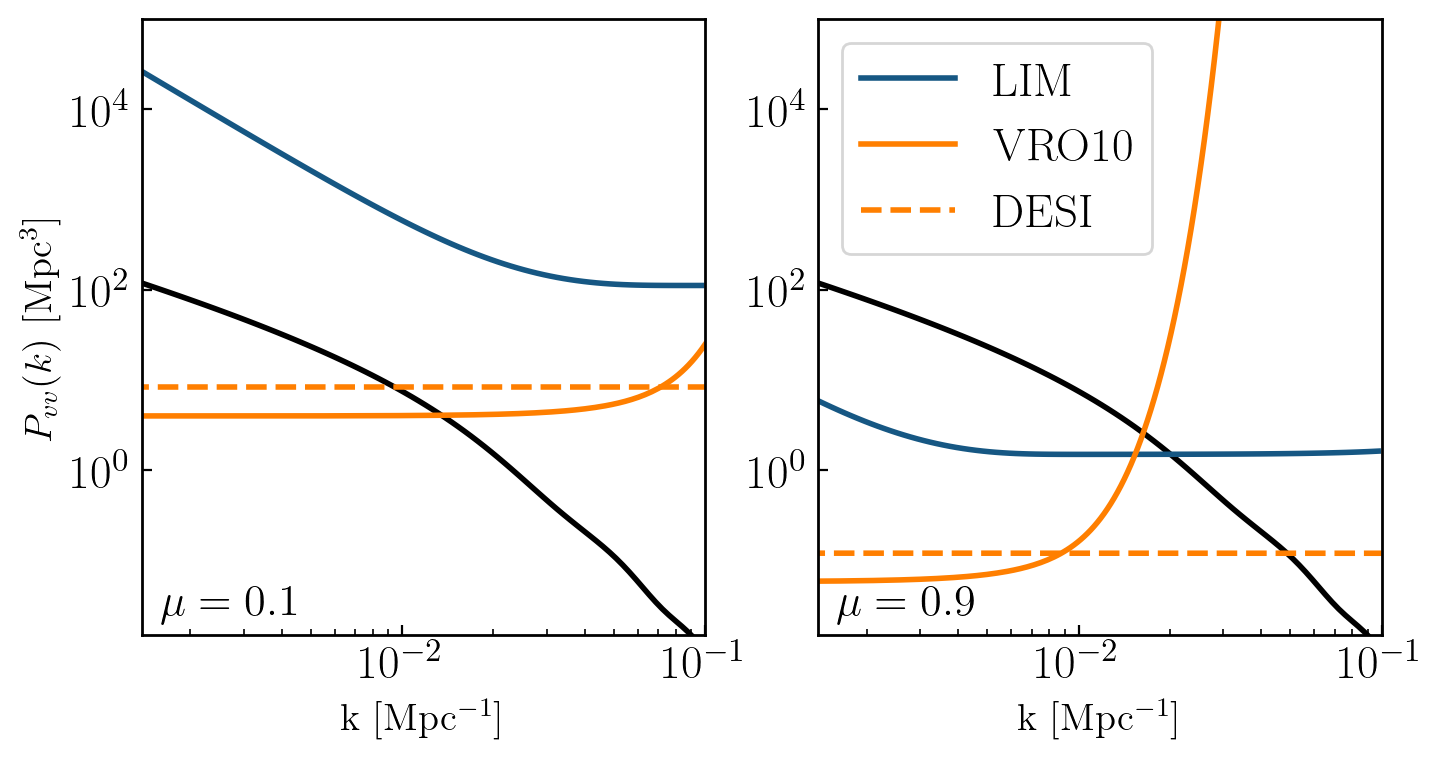

In [37]:


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='LIM')
plt.loglog(k_large_VRO10, Nvv_VRO10_kSZ[:,55], color=palette[6], label='VRO10')
plt.loglog(k_large_VRO10, Nvv_DESI_kSZ[:,55], color=palette[6], ls='--', label='DESI')
#plt.title(r'$z=%g$'%m.z)
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(1.5e-2,1e5)
#plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_{vv}(k)$ [Mpc$^3$]')
plt.text(1.6e-3, 2e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0], label='LIM')
plt.loglog(k_large_VRO10, Nvv_VRO10_kSZ[:,95], color=palette[6], label='VRO10')
plt.loglog(k_large_VRO10, Nvv_DESI_kSZ[:,95], color=palette[6], ls='--', label='DESI')
plt.legend(loc='upper left')

#plt.title(r'$\mu=0.9$')
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(1.5e-2,1e5)
plt.xlabel('k [Mpc$^{-1}$]')
plt.text(1.6e-3, 2e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.0004, 0.05, '$\\mu=0.9$')

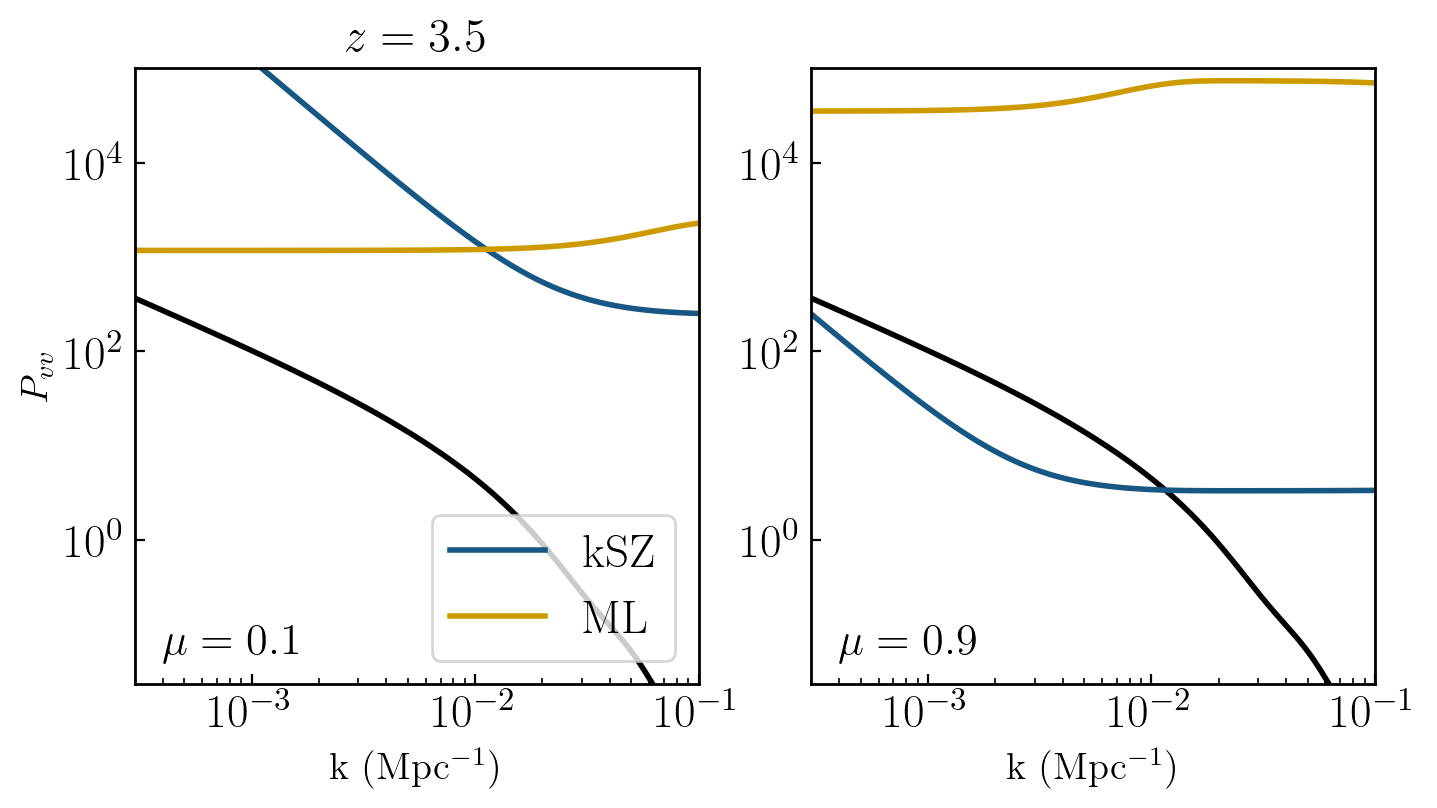

In [339]:
_,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
Pvv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
_,Nvv_par,Nvv_perp = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par
Nvv_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp



plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='kSZ')
plt.loglog(k_large, Nvv_ML[:,110], color=palette[1], label='ML')
plt.title(r'$z=%g$'%m.z)
#plt.xlim(1e-3, 5e-2)
plt.xlim(3e-4, 1e-1)
plt.ylim(3e-2,1e5)
#plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.legend(loc='lower right')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel(r'$P_{vv}$')
plt.text(4e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0])
plt.loglog(k_large, Nvv_ML[:,190], color=palette[1])
#plt.title(r'$\mu=0.9$')
#plt.xlim(1e-3, 5e-2)
plt.xlim(3e-4, 1e-1)
plt.ylim(3e-2,1e5)
plt.xlabel('k (Mpc$^{-1}$)')
plt.text(4e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

With redshift bins

In [44]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=True)
#obs_params['tobs'] = 3000*u.h
#obs_params['Omega_field'] = 1000*u.deg**2
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_LIM_down = np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_LIM_down = np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

    Fz_XX_LIM_down[i,:,:] = xx
    Fz_vX_LIM_down[i,:,:] = vx


Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 259803.06644328378 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)n

Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re

In [45]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_early_AtLAST = np.zeros((Nparams, Nparams))
F_vX_early_AtLAST = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bT_ind = free_params.index('bT')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_LIM_down):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_early_AtLAST[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_early_AtLAST[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_XX_early_AtLAST[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_early_AtLAST[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_LIM_down):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_early_AtLAST[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_early_AtLAST[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vX_early_AtLAST[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_early_AtLAST[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]


In [58]:
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_early_AtLAST, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_early_AtLAST, all_params, [], {'bv_par':0.01})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 4.005829739088267
1-sigma of ombh2 is 0.00045295441082643704
1-sigma of omch2 is 0.0015064540707885332
1-sigma of ns is 0.014417717873900313
1-sigma of As is 1.2840144380494928e-10
1-sigma of tau is 8.291342433847603
1-sigma of mnu is 0.13164545918415915
1-sigma of bT0 is 30.934823706492875
1-sigma of bT1 is 55.641494082756864
1-sigma of bT2 is 94.5303476356173
1-sigma of bT3 is 161.53172172255523

 LIM+kSZ:


1-sigma of H0 is 3.576302428363247
1-sigma of ombh2 is 0.0004513576479711939
1-sigma of omch2 is 0.0014250190868088362
1-sigma of ns is 0.012725991908821744
1-sigma of As is 1.2502439191884872e-10
1-sigma of tau is 8.259069110481748
1-sigma of mnu is 0.12192757808091023
1-sigma of bv_par is 0.008205561252429465
1-sigma of bv_perp is 0.1309815469262521
1-sigma of bT0 is 28.091827412720484
1-sigma of bT1 is 50.75922942217531
1-sigma of bT2 is 89.94728017685209
1-sigma of bT3 is 157.0996887442892


(0.001, 0.3)

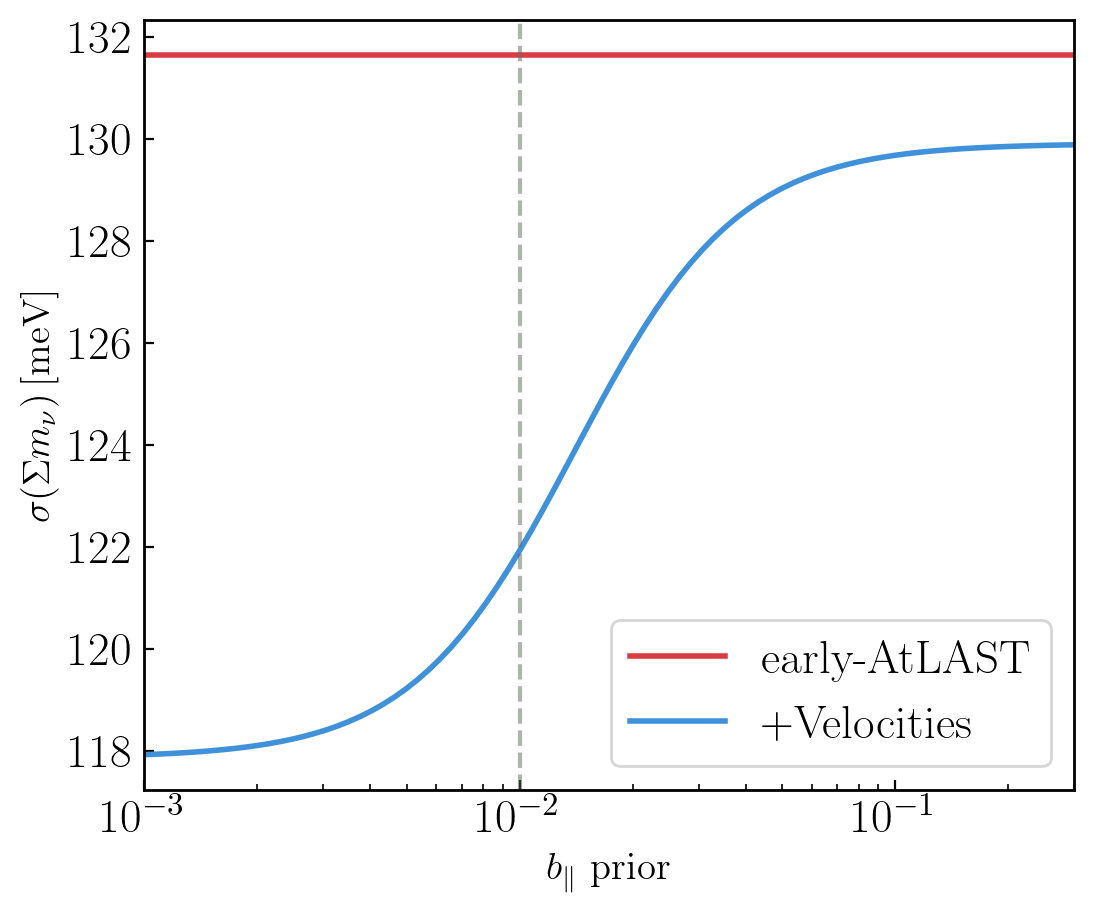

In [51]:
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_early_AtLAST, all_params, fixed_params, {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_early_AtLAST, all_params, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='early-AtLAST', color=palette[15])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.axvline(x = 1e-2, color = palette[4], alpha=0.5, ls='--', lw=1.5)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.xlim(1e-3, 3e-1)

(0.001, 0.2)

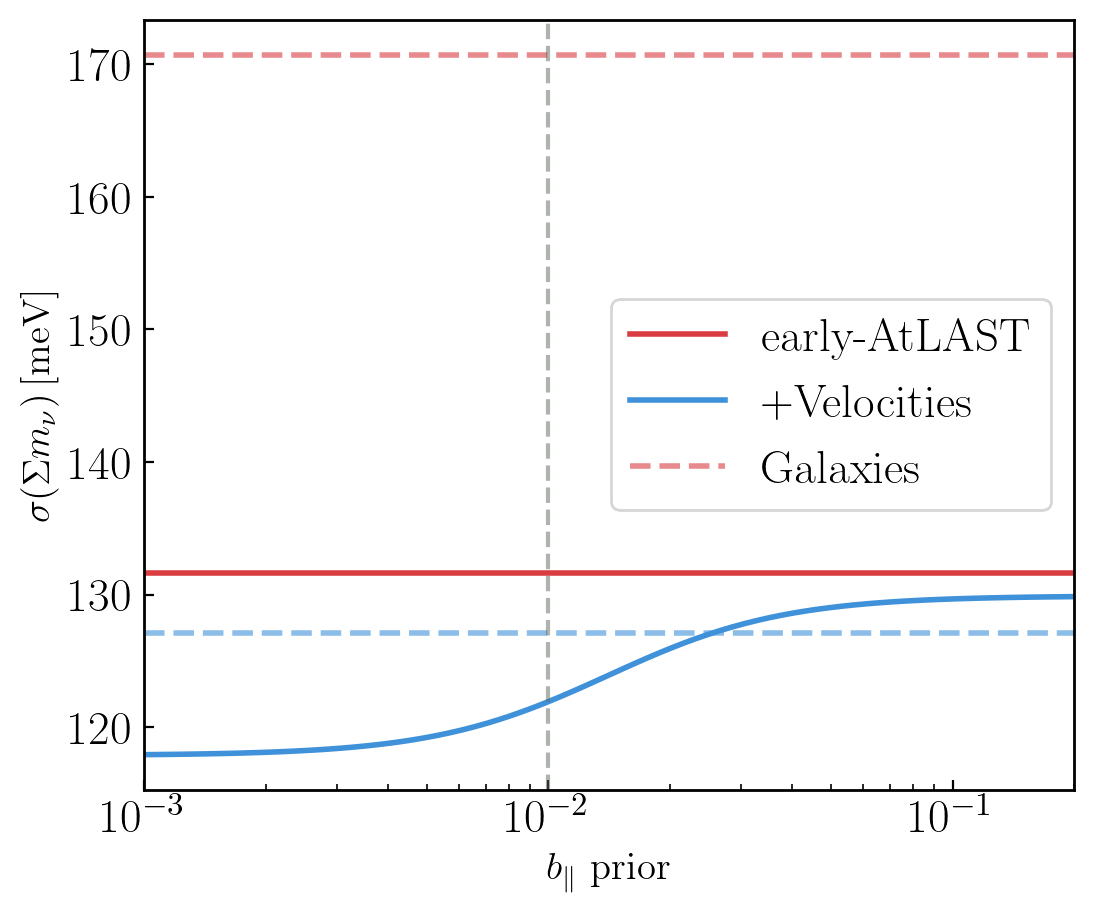

In [52]:
vm_root = '/media/HostShared/galaxies/'
sig_mnu_VRO10 = np.loadtxt(vm_root+'sig_mnu_bpar_gal.txt')
sig_mnu_VRO10_vel = np.loadtxt(vm_root+'sig_mnu_bpar_gal_vel.txt')

bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_early_AtLAST, all_params, fixed_params, {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_early_AtLAST, all_params, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='early-AtLAST', color=palette[15])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.plot(bpar_pr, sig_mnu_VRO10*1e3, label='Galaxies', ls='--', color=palette[15], alpha=0.6)
plt.plot(bpar_pr, sig_mnu_VRO10_vel*1e3, ls='--', color=palette[14], alpha=0.6)
plt.axvline(x = 1e-2, color = palette[4], alpha=0.5, ls='--', lw=1.5)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.xlim(1e-3, 2e-1)

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

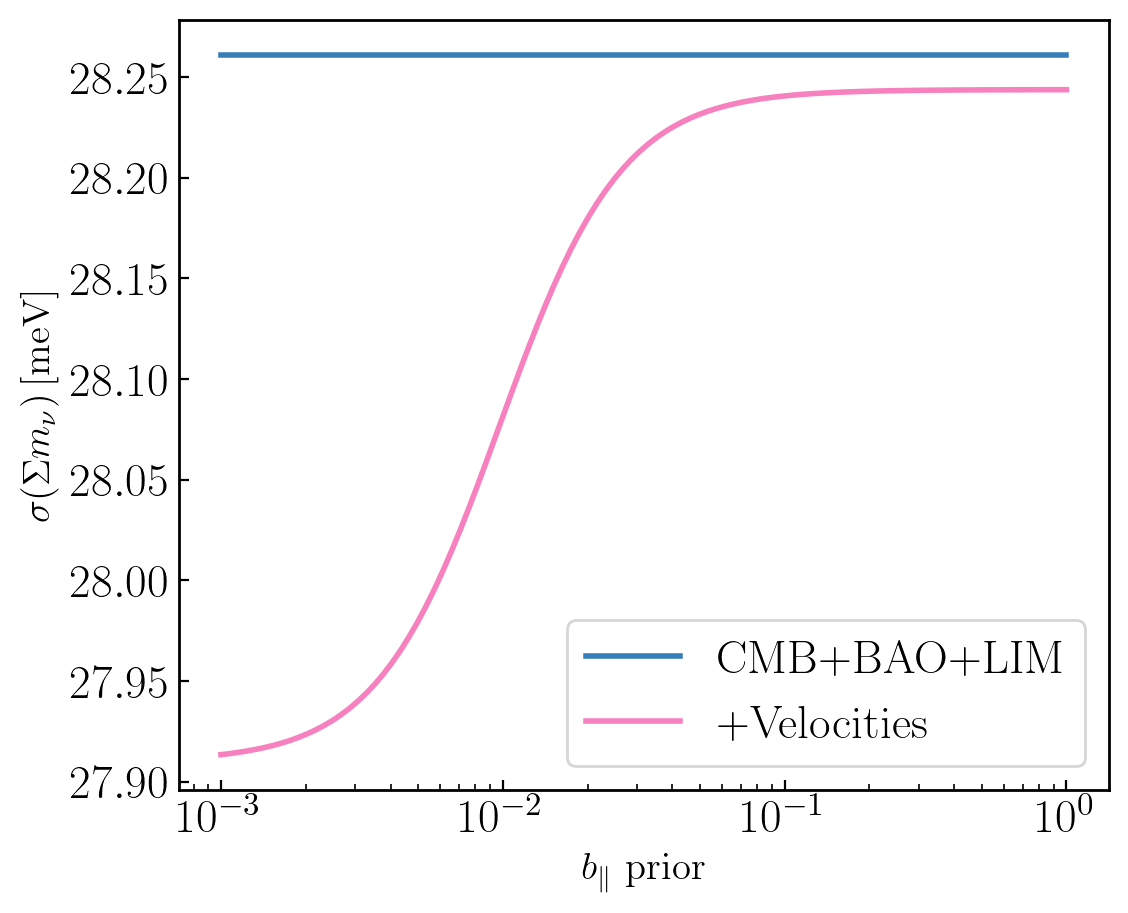

In [54]:
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

F_bao_CMB_lim = np.zeros((len(F_XX_early_AtLAST), len(F_XX_early_AtLAST)))
F_bao_CMB_lim[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

F_bao_CMB_lim_vel = np.zeros((len(F_vX_early_AtLAST), len(F_vX_early_AtLAST)))
F_bao_CMB_lim_vel[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_lim+F_XX_early_AtLAST, all_params, fixed_params, {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX_early_AtLAST, all_params, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='CMB+BAO+LIM', color=palette[5])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')


Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

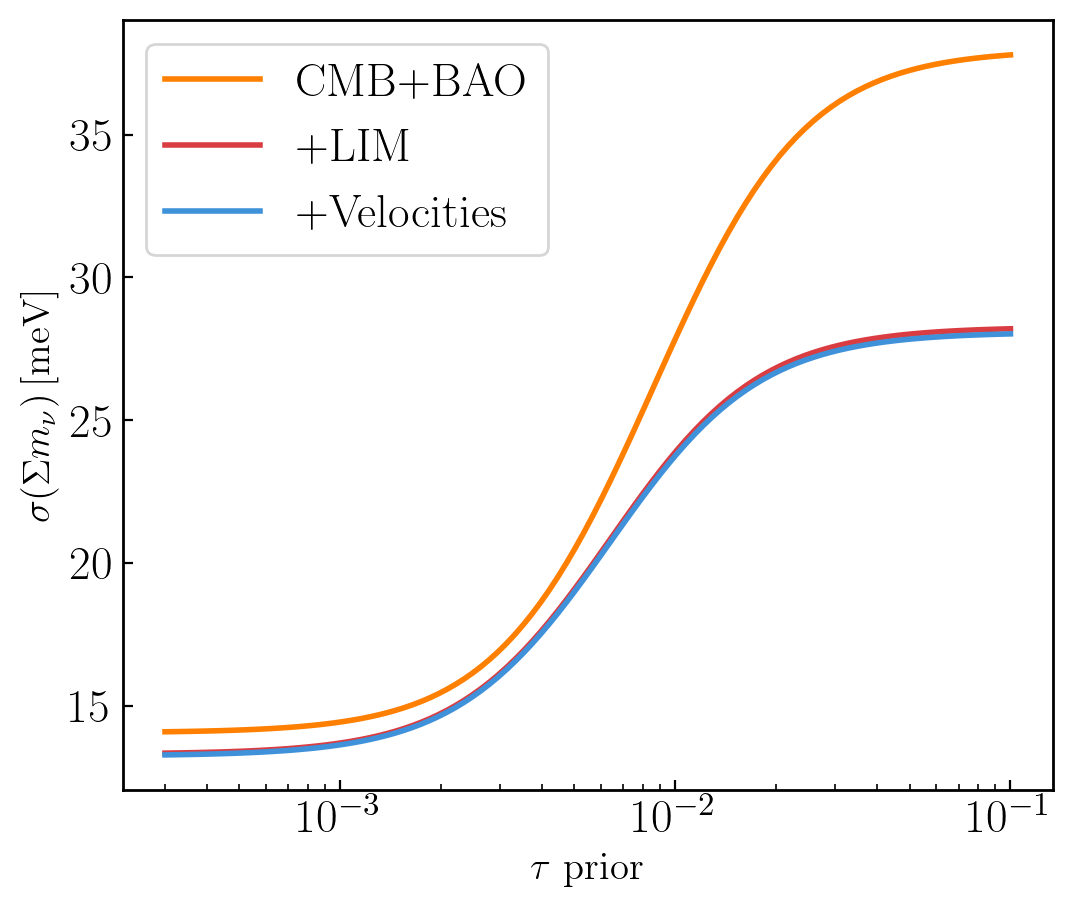

In [53]:

#bpar_pr = np.linspace(1e-4,1e-1,100)
tau_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu = np.zeros(len(tau_pr))
sig_mnu_lim = np.zeros(len(tau_pr))
sig_mnu_lim_vel = np.zeros(len(tau_pr))

F_bao_CMB_lim = np.zeros((len(F_XX_early_AtLAST), len(F_XX_early_AtLAST)))
F_bao_CMB_lim[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

F_bao_CMB_lim_vel = np.zeros((len(F_vX_early_AtLAST), len(F_vX_early_AtLAST)))
F_bao_CMB_lim_vel[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

for i in range(len(tau_pr)):
    covmat, cov_params = covariance_mat(F_bao_CMB, free_params2, [], {'tau':tau_pr[i]})
    sig_mnu[i] = np.sqrt(covmat[mnu_ind,mnu_ind])
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_lim+F_XX_early_AtLAST, all_params, fixed_params, {'tau':tau_pr[i]})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX_early_AtLAST, all_params, [], {'tau':tau_pr[i], 'bv_par':0.01})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(tau_pr, sig_mnu*1e3, label='CMB+BAO', color=palette[6])
plt.plot(tau_pr, sig_mnu_lim*1e3, label='+LIM', color=palette[15])
plt.plot(tau_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\tau$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

### Vary $\Delta_T$ for AtLAST

In [14]:
ARCMIN_TO_RAD = 1./60.*np.pi/180.
Delta_Ts = np.logspace(-1,1, 8)

fsky=0.4

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

F_XX_t = []
F_vX_t = []

mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))


for t in range(len(Delta_Ts)):
    
    Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
    Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
    for i in range(len(zs)):
        cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        sigN = m.sigma_N / m.tpix.to(u.s)**0.5
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, sigN)

        vol = m.Vfield
        k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_Ts[t])
        
        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

    F_vX_t.append(np.sum(Fz_vX_LIM, axis=0))
    F_XX_t.append(np.sum(Fz_XX_LIM, axis=0))
    

cov_params2.remove('bT')
cov_params3.remove('bT')

# with open(fisher_root+'F_vX_DeltaT_AtLAST.pkl', 'wb') as file: 
#     pickle.dump(F_vX_t, file)
    
# with open(fisher_root+'F_XX_DeltaT_AtLAST.pkl', 'wb') as file: 
#     pickle.dump(F_XX_t, file)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 10124925.606666666 Jy / (s(1/2) sr)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (

Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 2596677.920517778 Jy / (s(



Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 10124925.606666666 Jy / (s(1/2) sr)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 472770.5993066667 Jy / (s(1/2) sr)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating

In [18]:
mnu_ind = free_params.index('mnu')
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

cov_params2 = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu']
cov_params3 = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']

with open(fisher_root+'F_vX_DeltaT_AtLAST.pkl', "rb") as f:
    F_vX_t = pickle.load(f)
    
with open(fisher_root+'F_XX_DeltaT_AtLAST.pkl', "rb") as f:
    F_XX_t = pickle.load(f)

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

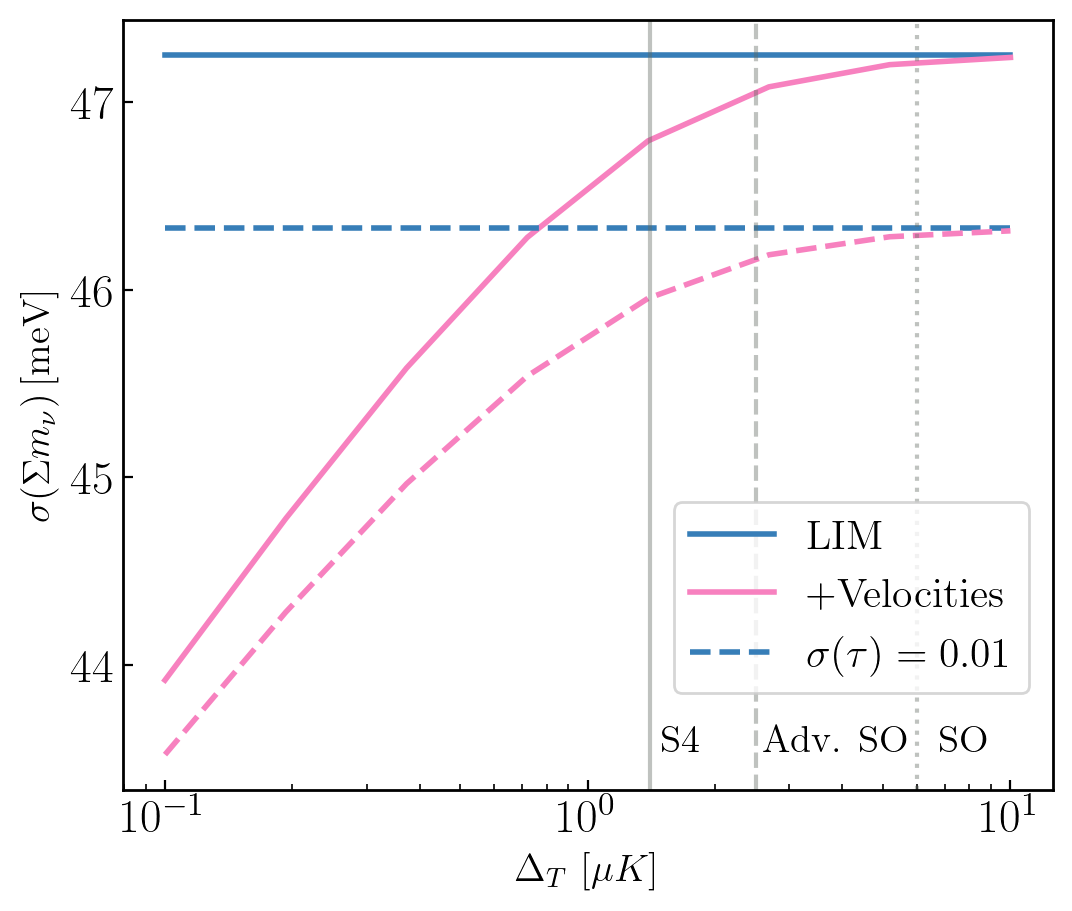

In [16]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 43.5, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 43.5, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 43.5, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.57,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$')
#plt.ylim(0.1,0.7)



Text(0.5, 1.0, 'low $z$ plot')

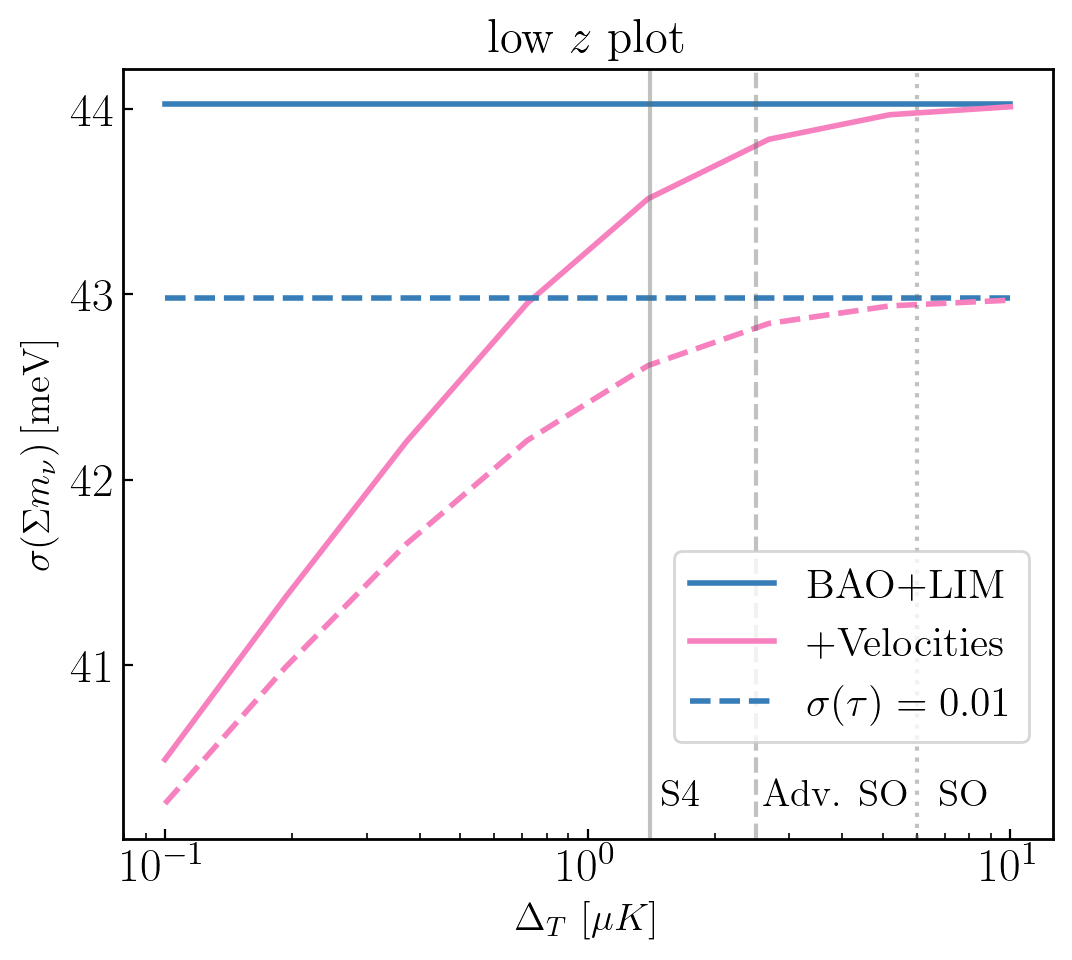

In [20]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L2[:7,:7] = F_bao
    
    covmat_lim, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_L2+F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params2, fixed_params, {'tau':0.005})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_L2+F_vX, cov_params3, [], {'tau':0.005})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='BAO+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 40.2, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 40.2, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 40.2, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.57,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'low $z$ plot')
#plt.ylim(0.1,0.7)



Text(0.5, 1.0, 'high+low $z$ plot')

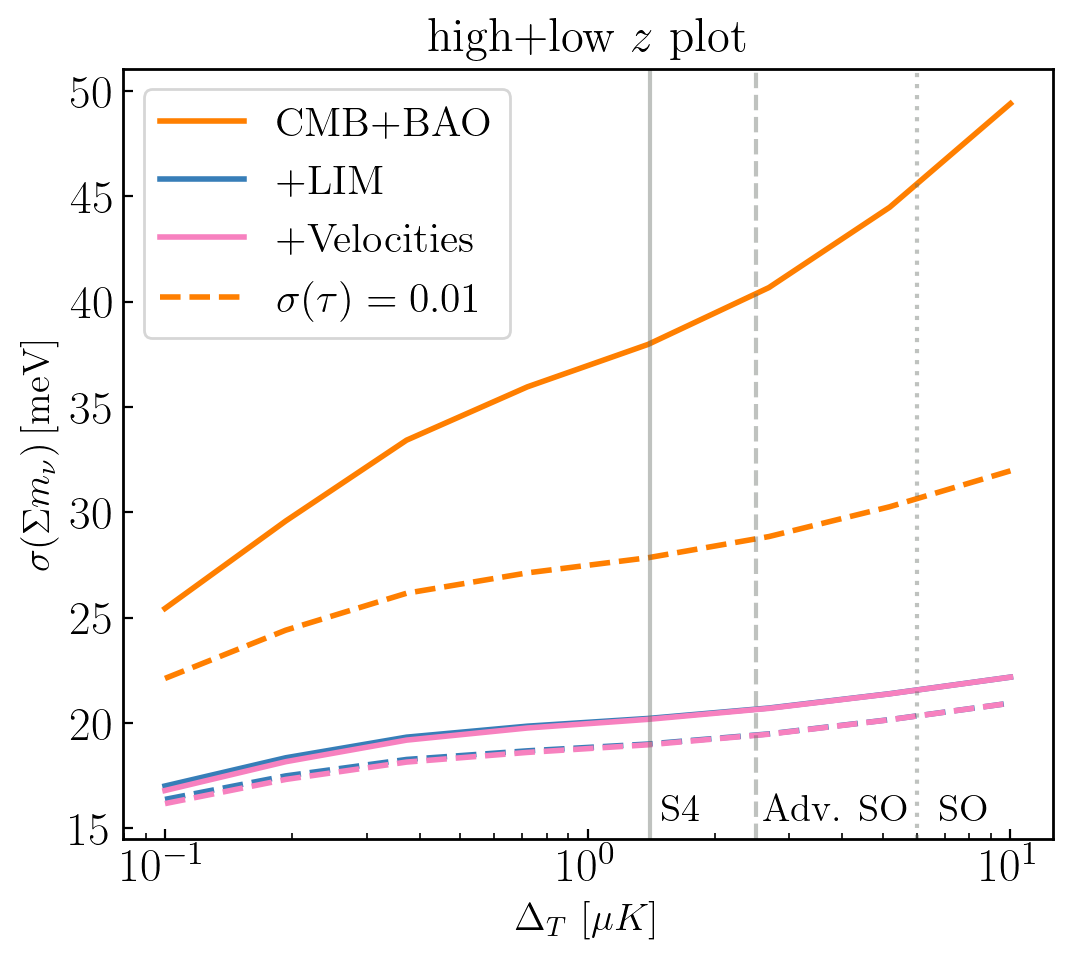

In [22]:
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))


plt.plot(Delta_Ts, sig_mnu_DT*1e3, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 15, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 15, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 15, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15)#, bbox_to_anchor=(0.52,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'high+low $z$ plot')
#plt.ylim(0.1,0.7)



Text(0.5, 1.0, 'high+low $z$ plot with $0.5\\%$ prior on $b_\\parallel$')

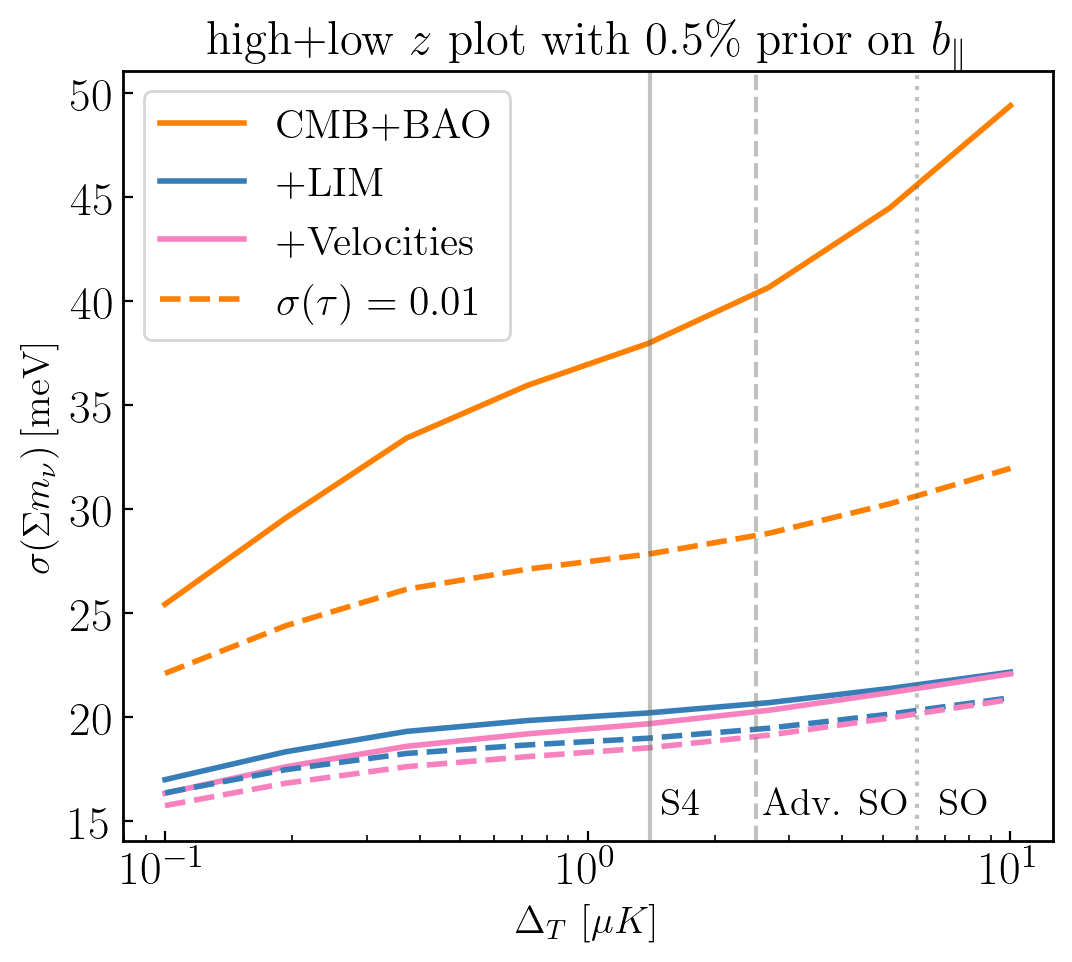

In [23]:
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'bv_par':0.005})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'tau':0.01,'bv_par':0.005})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))


plt.plot(Delta_Ts, sig_mnu_DT*1e3, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 15, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 15, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 15, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15)#, bbox_to_anchor=(0.52,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'high+low $z$ plot with $0.5\%$ prior on $b_\parallel$')
#plt.ylim(0.1,0.7)



### Vary $\Delta_T$ for early-AtLAST

In [340]:
ARCMIN_TO_RAD = 1./60.*np.pi/180.
Delta_Ts = np.logspace(-1,1, 8)

fsky=0.4

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

F_XX_ear_t = []
F_vX_ear_t = []

mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

cosmo_model_params, obs_params = lim_params('CII', downgrade=True)
m = update_Pkline(obs_params,cosmo_model_params)[0]

for t in range(len(Delta_Ts)):
    
    Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
    Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
    for i in range(len(zs)):
        
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)

        vol = m.Vfield
        k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_Ts[t])
        
        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

    F_vX_ear_t.append(np.sum(Fz_vX_LIM, axis=0))
    F_XX_ear_t.append(np.sum(Fz_XX_LIM, axis=0))
    

cov_params2.remove('bT')
cov_params3.remove('bT')

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 201239.44459896523 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)n

Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 72253.97573759138 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulatin



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 201239.44459896523 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)o



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 20671.967178403702 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+de

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

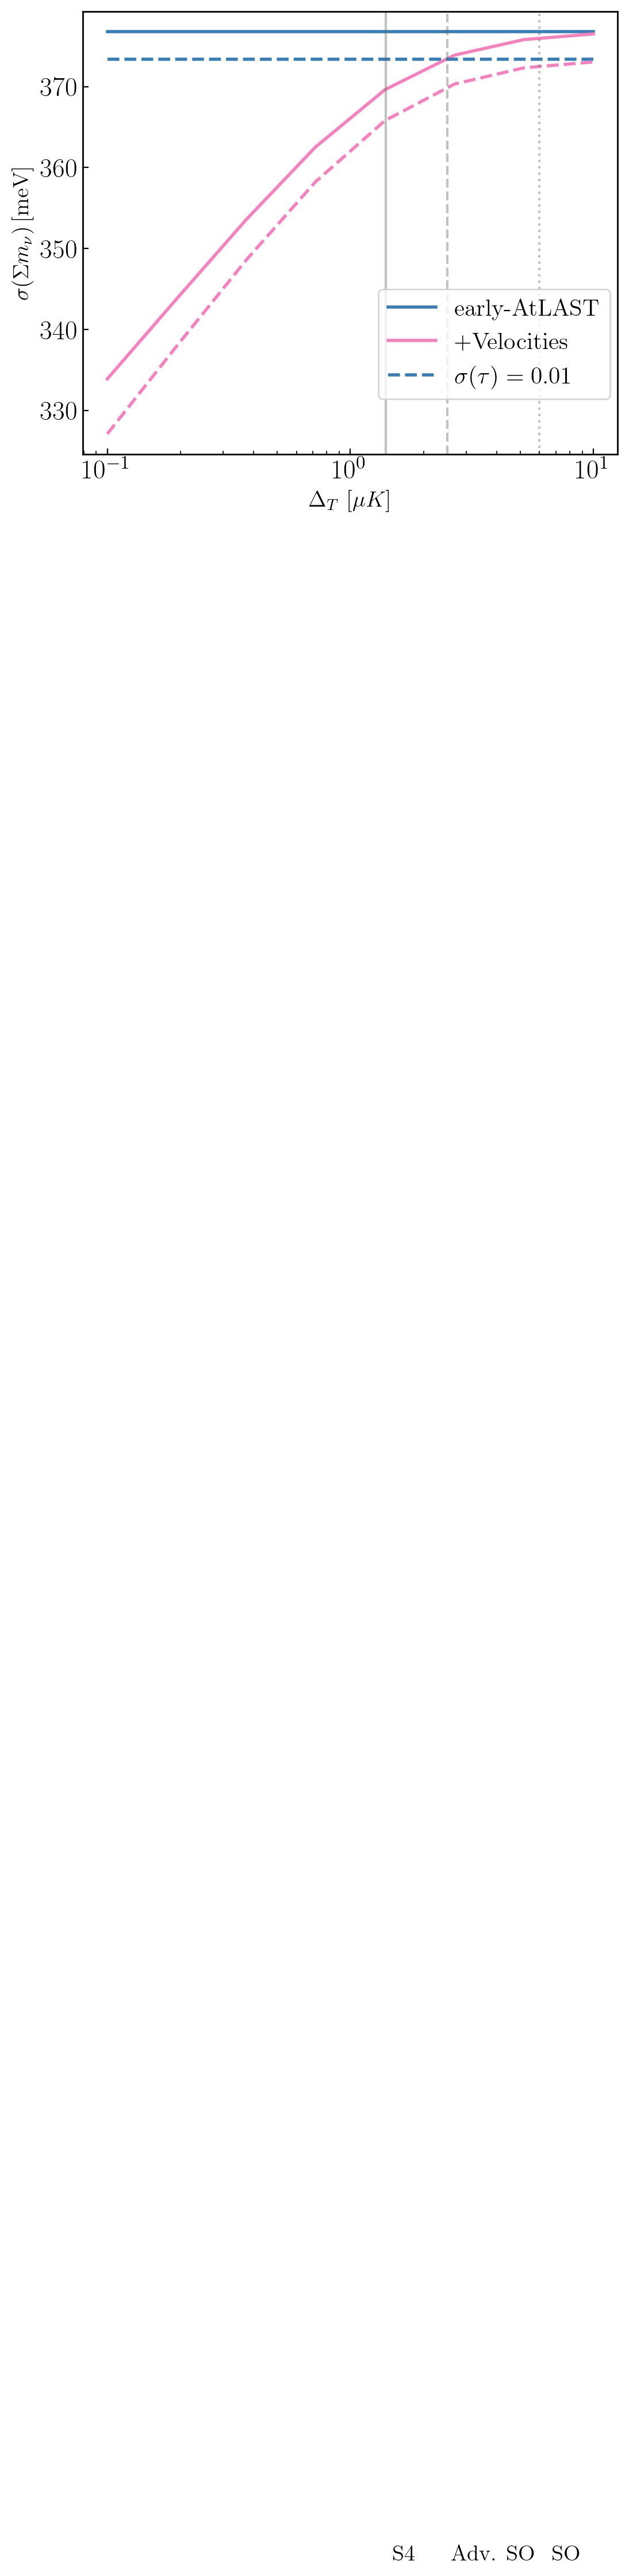

In [349]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    

plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='early-AtLAST', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 63.9, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 63.9, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 63.9, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.53,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')



Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

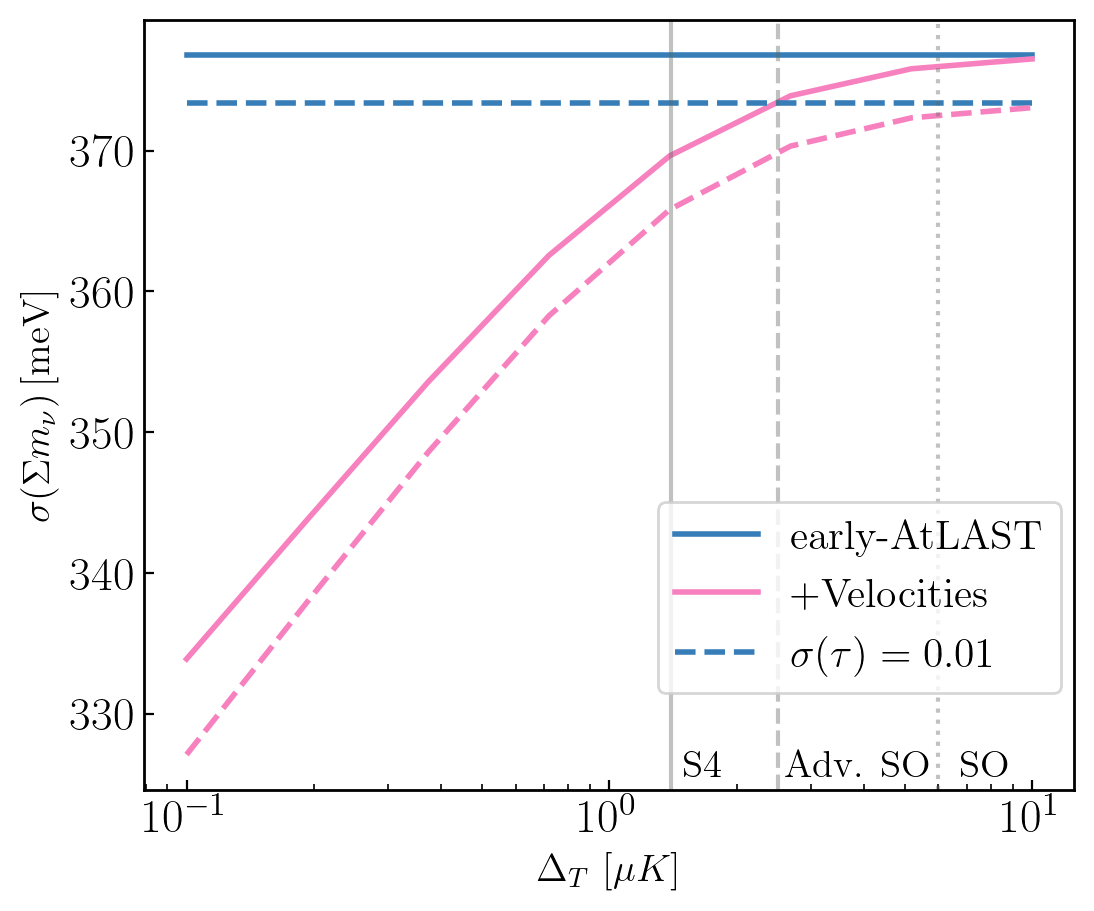

In [406]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    

plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='early-AtLAST', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 325, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 325, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 325, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.53,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')



Text(0.5, 1.0, 'low $z$ plot')

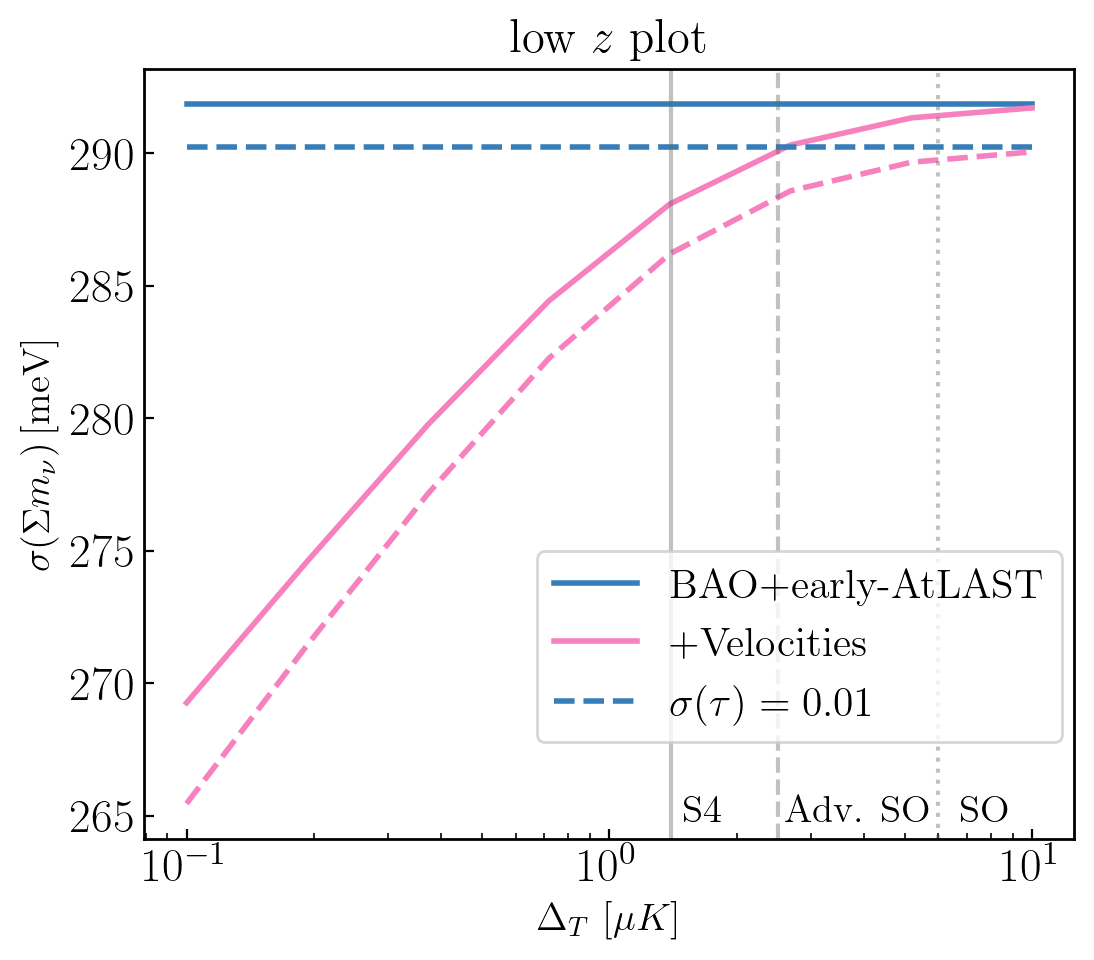

In [402]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L2[:7,:7] = F_bao
    
    covmat_lim, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_L2+F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params2, fixed_params, {'tau':0.005})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_L2+F_vX, cov_params3, [], {'tau':0.005})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='BAO+early-AtLAST', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 264.5, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 264.5, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 264.5, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.4,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'low $z$ plot')



Text(0.5, 1.0, 'high+low $z$ plot')

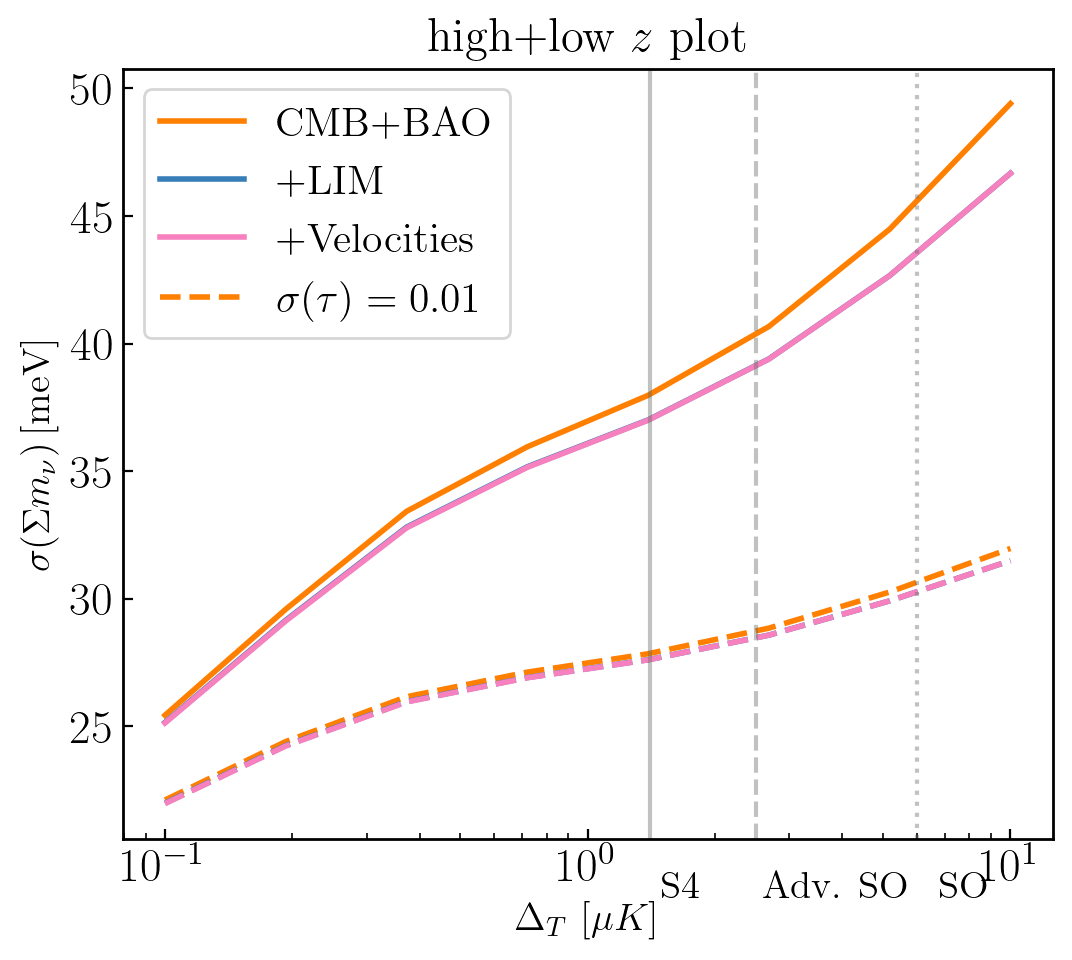

In [355]:
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))


plt.plot(Delta_Ts, sig_mnu_DT*1e3, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 18, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 18, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 18, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15)#, bbox_to_anchor=(0.52,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'high+low $z$ plot')
#plt.ylim(0.1,0.7)



Text(0.5, 1.0, 'high+low $z$ plot with $0.5\\%$ prior on $b_\\parallel$')

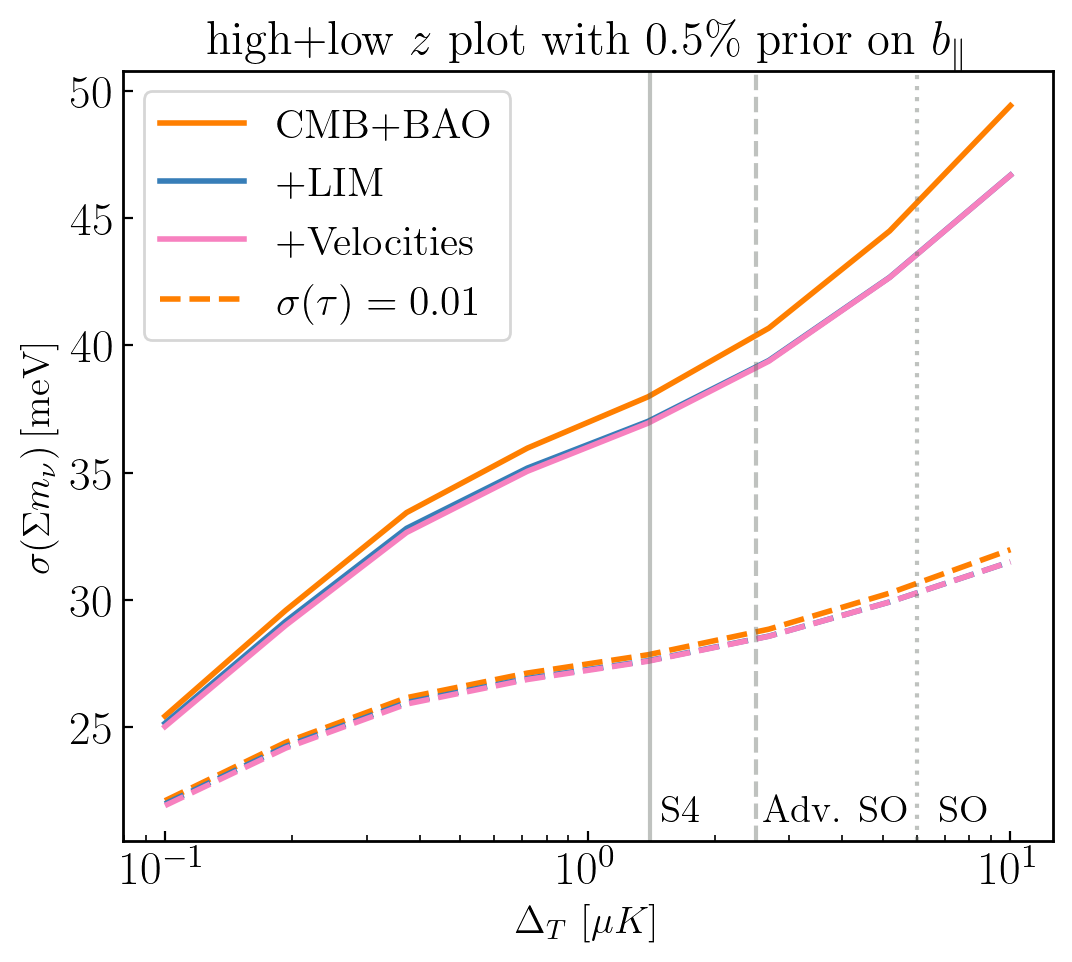

In [407]:
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'bv_par':0.005})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'tau':0.01, 'bv_par':0.005})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))


plt.plot(Delta_Ts, sig_mnu_DT*1e3, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 21, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 21, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 21, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15)#, bbox_to_anchor=(0.52,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'high+low $z$ plot with $0.5\%$ prior on $b_\parallel$')
#plt.ylim(0.1,0.7)



## Create 2D plot

In [432]:
# Omegas = np.linspace(8, 8000, 10)
# tobss = np.linspace(500, 1000, 10)
Omegas = np.logspace(np.log10(100), np.log10(1.3e4), 10)
tobss = np.linspace(100, 10000, 10)

cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
m = update_Pkline(obs_params,cosmo_model_params)[0]


F_XX_om_tob = []
F_vX_om_tob = []

F_XX_om_tob = np.zeros((len(Omegas),len(tobss),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
F_vX_om_tob = np.zeros((len(Omegas),len(tobss),len(free_params)-1,len(free_params)-1))

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for o in range(len(Omegas)):
    for t in range(len(tobss)):
        obs_params['Omega_field'] = Omegas[o]*u.deg**2
        obs_params['tobs'] = tobss[t]*u.h
        for i in range(len(zs)):  
            nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
            cosmo_model_params['nuObs'] = nu
            obs_params['Delta_nu'] = Dnu
            obs_params['dnu'] = (nu/R).to(u.MHz)
            obs_params['beam_FWHM'] = beam[i]
            obs_params['sigma_pix'] = sigpix[i]
            m = update_Pkline(obs_params,cosmo_model_params)[0]
            bias_params['bT'] = (m.bavg[0]*m.Tmean).value
            print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

            vol = m.Vfield
            k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
            xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

            cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
            cov_xx = np.delete(cov_xx, -1, axis=0)
            cov_xx = np.delete(cov_xx, -1, axis=1)
            Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

            cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
            cov_vx = np.delete(cov_vx, -1, axis=0)
            cov_vx = np.delete(cov_vx, -1, axis=1)
            Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

        F_vX_om_tob[o,t] = np.sum(Fz_vX_LIM, axis=0)
        F_XX_om_tob[o,t] = np.sum(Fz_XX_LIM, axis=0)
        

cov_params2.remove('bT')
cov_params3.remove('bT')

with open(fisher_root+'F_vX_omega_tobs_AtLAST.pkl', 'wb') as file: 
    pickle.dump(F_vX_om_tob, file)
    
with open(fisher_root+'F_XX_omega_tob_AtLAST.pkl', 'wb') as file: 
    pickle.dump(F_XX_om_tob, file)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 450000.0 Jy / sr 100.0 deg2 100.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 589725.0 Jy / sr 171.74440379730845



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 60579.299999999996 Jy / sr 171.74440379730845 deg2 100.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted



Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 30579.958414158933 Jy / sr 171.74440379730845 deg2 1200.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 44149.95932142551 Jy / sr 171.74440379730845 deg2 2300.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earlie



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 101137.00312316603 Jy / sr 171.74440379730845 deg2 3400.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)




Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 10389.264238923586 Jy / sr 171.74440379730845 deg2 3400.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest 



Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 15791.42262210039 Jy / sr 171.74440379730845 deg2 4500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simula

Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 28294.381978306326 Jy / sr 171.74440379730845 deg2 5600.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earli

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 9698.806173975012 Jy / sr 



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 15718.628342389424 Jy / sr 294.96140235692934 deg2 7800.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)





Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 29413.305240115016 Jy / sr 294.96140235692934 deg2 8900.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (e



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 77282.5 Jy / sr 294.96140235692934 deg2 10000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now si



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 7938.8150000000005 Jy / sr 294.96140235692934 deg2 10000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earlie



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 181931.58333333334 Jy / sr 506.5797019100889 deg2 100.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulatin



Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 104974.29744677758 Jy / sr 506.5797019100889 deg2 1200.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 211188.61141735676 Jy / sr 506.5797019100889 deg2 2300.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 40889.72166118782 Jy / sr 870.0222888036644 de



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 71042.22006298478 Jy / sr 870.0222888036644 deg2 4500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted 



Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 177371.26396070432 Jy / sr 870.0222888036644 deg2 5600.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest fi



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 18220.72893177992 Jy / sr 870.0222888036644 deg2 5600.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earlies



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 29128.371940096426 Jy / sr 870.0222888036644 deg2 6700.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simula



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 53960.43973710432 Jy / sr 870.0222888036644 deg2 7800.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest fi



Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 140696.1686079442 Jy / sr 870.0222888036644 deg2 8900.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)




Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 14453.224793579318 Jy / sr 870.0222888036644 deg2 8900.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earlie

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 818479.5666666667 Jy / sr 



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 658063.8368223354 Jy / sr 2566.2299438731447 deg2 1200.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earlies



Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 67600.65841506433 Jy / sr 2566.2299438731447 deg2 1200.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (ea



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 85381.94360585466 Jy / sr 2566.2299438731447 deg2 2300.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simu



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 140368.08765138706 Jy / sr 2566.2299438731447 deg2 3400.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earlies



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 339822.704100568 Jy / sr 2566.2299438731447 deg2 4500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


No



Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 34908.829897893396 Jy / sr 2566.2299438731447 deg2 4500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earlies

Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 54718.721456712294 Jy / sr 2566.2299438731447 deg2 5600.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now sim

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 338262.10256552725 Jy / sr 4407.356



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 34748.568789952085 Jy / sr 4407.356317172936 deg2 7800.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted



Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 56882.48073515229 Jy / sr 4407.356317172936 deg2 8900.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now s



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 107262.78333333333 Jy / sr 4407.356317172936 deg2 10000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earli



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 3915100.0 Jy / sr 7569.387830151669 deg2 100.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simul



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 402183.95 Jy / sr 7569.387830151669 deg2 100.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


No



Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 203015.45531847808 Jy / sr 7569.387830151669 deg2 1200.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simula

Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 293110.2409457331 Jy / sr 7569.387830151669 deg2 2300.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earlies

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 90392.0250938691 Jy / sr 1



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 137389.59428493094 Jy / sr 13000.000000000005 deg2 4500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)





Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 246172.3744641141 Jy / sr 13000.000000000005 deg2 5600.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (ea



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 626823.9308672219 Jy / sr 13000.000000000005 deg2 6700.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 64392.03839951655 Jy / sr 13000.000000000005 deg2 6700.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 104354.88807000202 Jy / sr 13000.000000000005 deg2 7800.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulat



Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 195271.25832454057 Jy / sr 13000.000000000005 deg2 8900.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earlies

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 513077.5 Jy / sr 13000.000000000005 deg2 10000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now s

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 

In [22]:
Omegas = np.logspace(np.log10(100), np.log10(1.3e4), 10)
tobss = np.linspace(100, 10000, 10)

free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']
mnu_ind = free_params.index('mnu')
cov_params2 = free_params.copy()
cov_params2.remove(fixed_params[0])
cov_params2.remove(fixed_params[1])
cov_params2.remove('bT')
cov_params3 = free_params.copy()
cov_params3.remove('bT')

with open(fisher_root+'F_vX_omega_tobs_AtLAST.pkl', 'rb') as file: 
    F_vX_om_tob = pickle.load(file)
    
with open(fisher_root+'F_XX_omega_tob_AtLAST.pkl', 'rb') as file: 
    F_XX_om_tob = pickle.load(file)


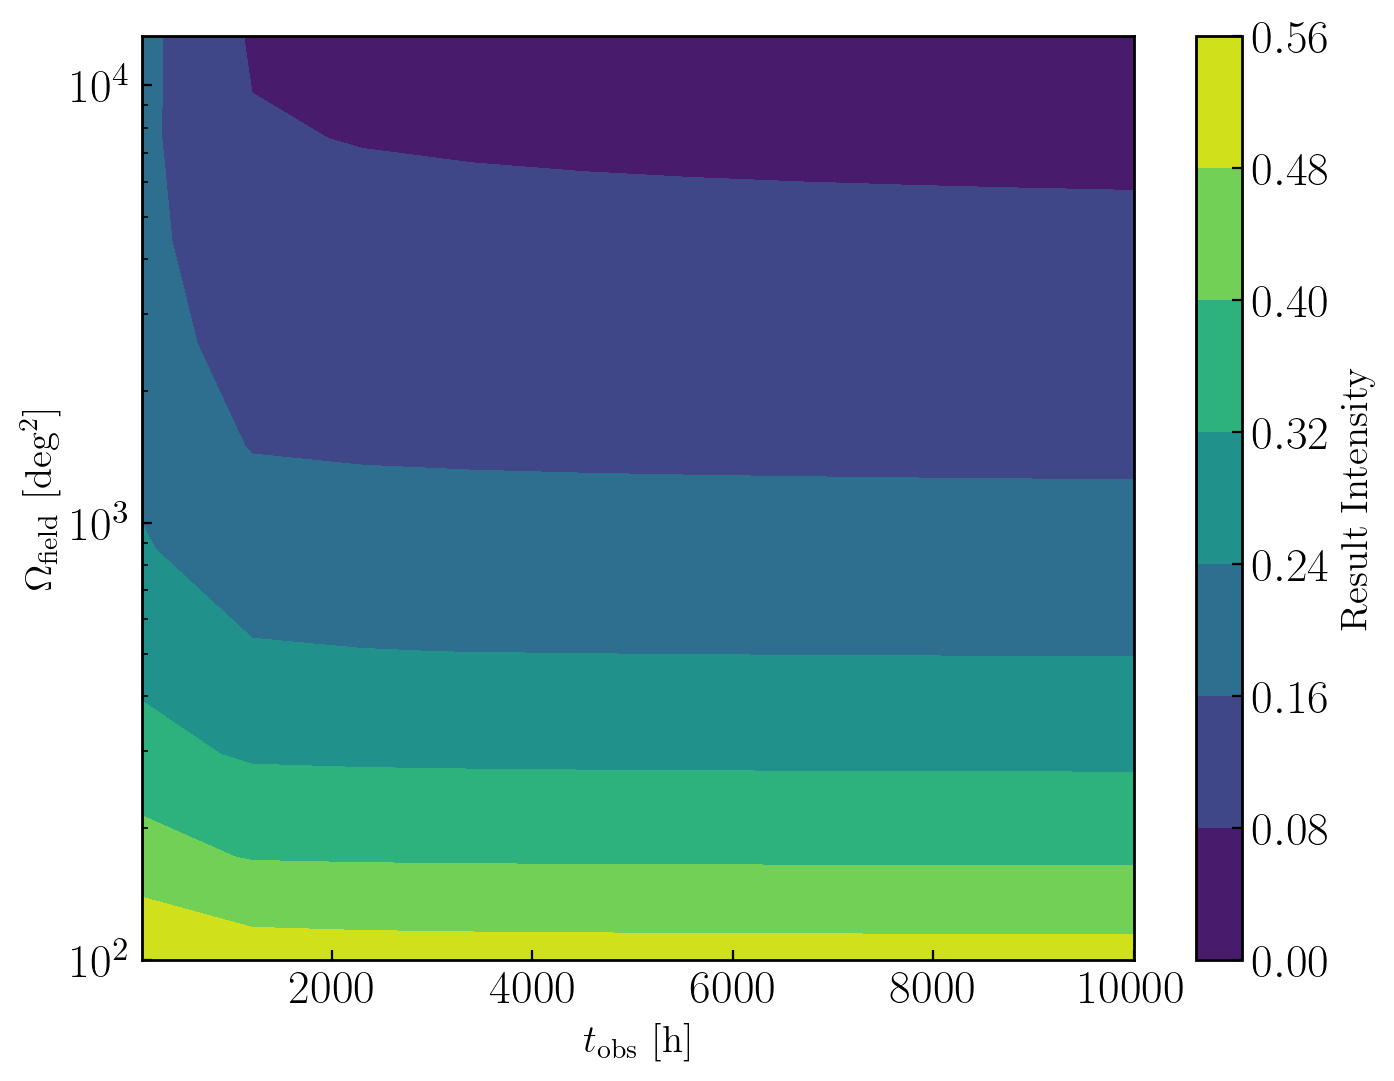

In [23]:
sig_mnu_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_pr_grid = np.zeros((len(Omegas), len(tobss)))


for o in range(len(Omegas)):
    for t in range(len(tobss)):
        F_XX = F_XX_om_tob[o,t]
        F_vX = F_vX_om_tob[o,t]
        
        covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
        sig_mnu_grid[o,t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {})
        sig_mnu_vel_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

#         covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {'tau':0.01})
#         sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
#         covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'tau':0.01})
#         sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

plt.figure(figsize=(8, 6))
plt.contourf(tobss, Omegas, sig_mnu_grid, cmap='viridis')
plt.colorbar(label='Result Intensity')
plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.yscale('log')
plt.show()

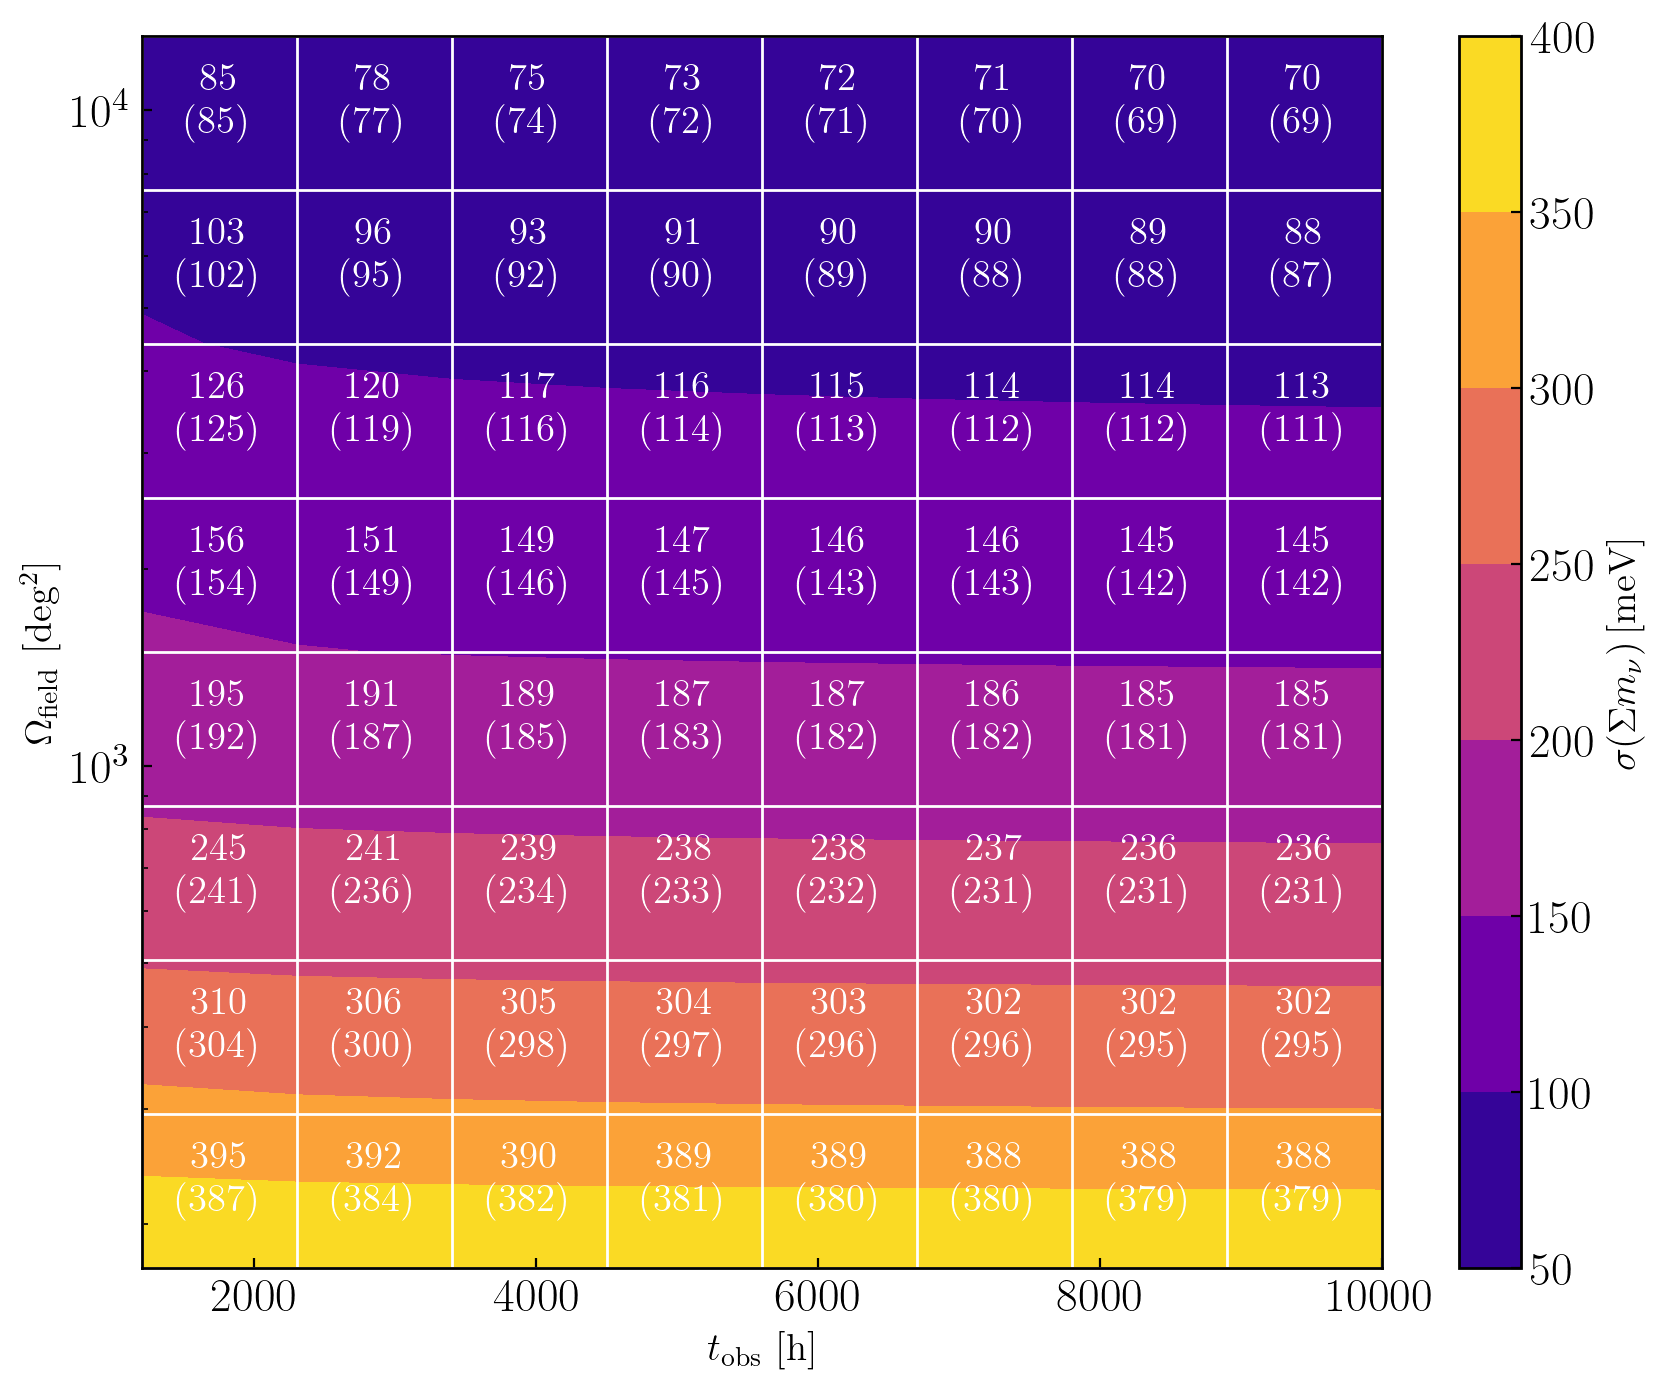

In [24]:
sig_mnu_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_pr_grid = np.zeros((len(Omegas), len(tobss)))


for o in range(len(Omegas)):
    for t in range(len(tobss)):
        F_XX = F_XX_om_tob[o,t]
        F_vX = F_vX_om_tob[o,t]
        
        covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
        sig_mnu_grid[o,t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {})
        sig_mnu_vel_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])


xx = sig_mnu_grid[1:,1:]*1e3
vx = sig_mnu_vel_grid[1:,1:]*1e3
plt.figure(figsize=(10, 8))
plt.contourf(tobss[1:], Omegas[1:], xx, cmap='plasma')
plt.colorbar(label=r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')

for t in tobss:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)
    
tobs_midpoints = (tobss[:-1] + tobss[1:]) / 2
omega_midpoints = (Omegas[:-1] + Omegas[1:]) / 2
    
for i, tobs in enumerate(tobs_midpoints[1:]):
    for j, omega in enumerate(omega_midpoints[1:]):
        plt.text(tobs, omega, f'{xx[j, i]:.0f}\n({vx[j, i]:.0f})', ha='center', va='center', color='white')


plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.yscale('log')
plt.xlim(tobss[1],tobss[-1])
plt.ylim(Omegas[1],Omegas[-1])
plt.show()

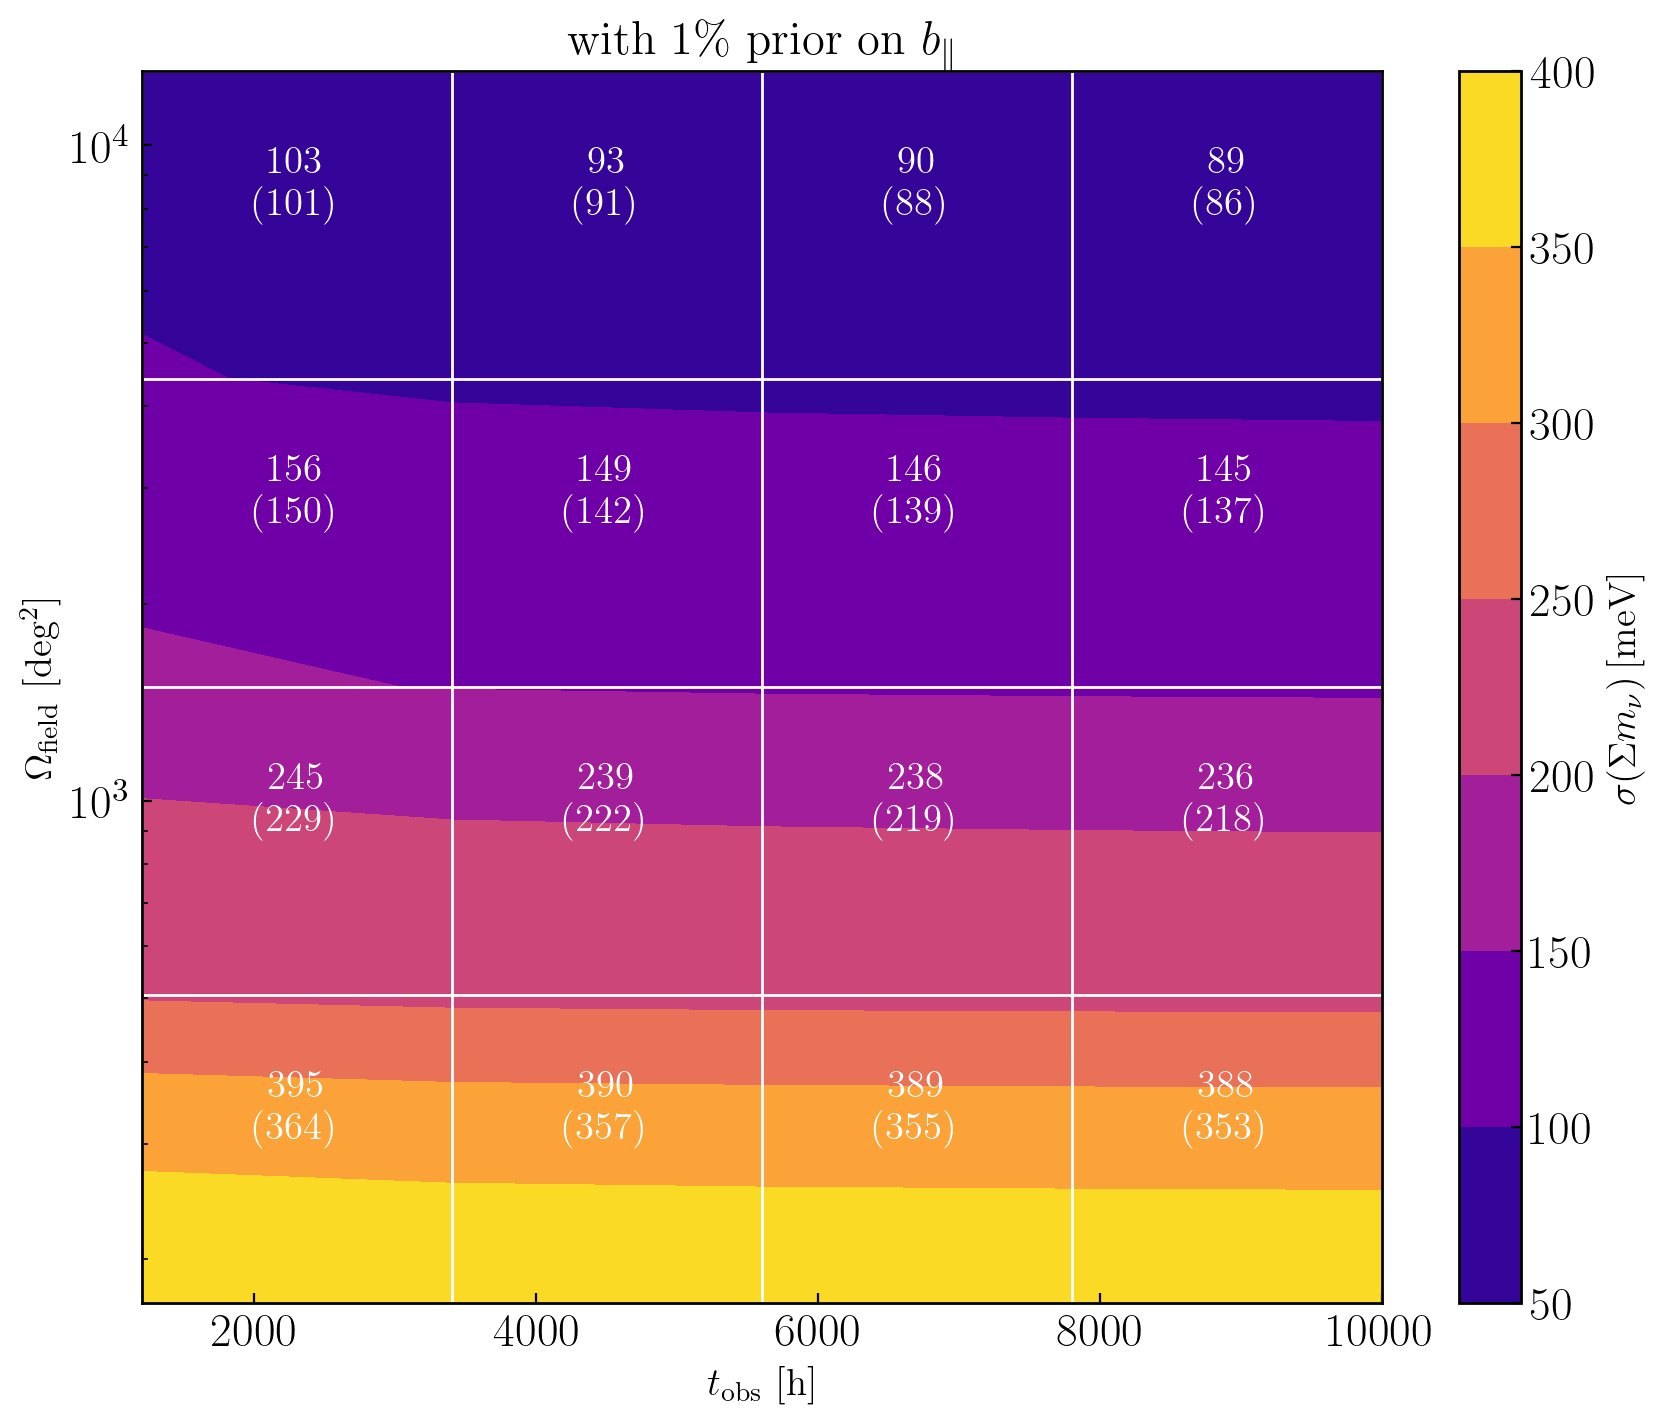

In [27]:

for o in range(len(Omegas)):
    for t in range(len(tobss)):
        F_XX = F_XX_om_tob[o,t]
        F_vX = F_vX_om_tob[o,t]
        
        covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
        sig_mnu_grid[o,t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'bv_par':0.01})
        sig_mnu_vel_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

xx = sig_mnu_grid[1:,1:]*1e3
vx = sig_mnu_vel_grid[1:,1:]*1e3

# Resample to a 5x5 grid by selecting intermediate indices
indices = [1, 3, 5, 7, 9]
Omegas_resampled = Omegas[indices]
tobss_resampled = tobss[indices]

sig_mnu_grid_resampled = sig_mnu_grid[np.ix_(indices, indices)]
sig_mnu_vel_grid_resampled = sig_mnu_vel_grid[np.ix_(indices, indices)]

# Plotting the resampled grid
xx_resampled = sig_mnu_grid_resampled * 1e3
vx_resampled = sig_mnu_vel_grid_resampled * 1e3

plt.figure(figsize=(10, 8))
plt.contourf(tobss_resampled, Omegas_resampled, xx_resampled, cmap='plasma')
plt.colorbar(label=r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')

# Calculate the positions for the grid lines
tobs_midpoints_resampled = (tobss_resampled[:-1] + tobss_resampled[1:]) / 2
omega_midpoints_resampled = (Omegas_resampled[:-1] + Omegas_resampled[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss_resampled:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas_resampled:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints_resampled):
    for j, omega in enumerate(omega_midpoints_resampled):
        plt.text(tobs, omega, f'{xx_resampled[j, i]:.0f}\n({vx_resampled[j, i]:.0f})', ha='center', va='center', color='white')

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.title(r'with 1\% prior on $b_\parallel$')
plt.yscale('log')
plt.xlim(tobss_resampled[0], tobss_resampled[-1])
plt.ylim(Omegas_resampled[0], Omegas_resampled[-1])
plt.show()

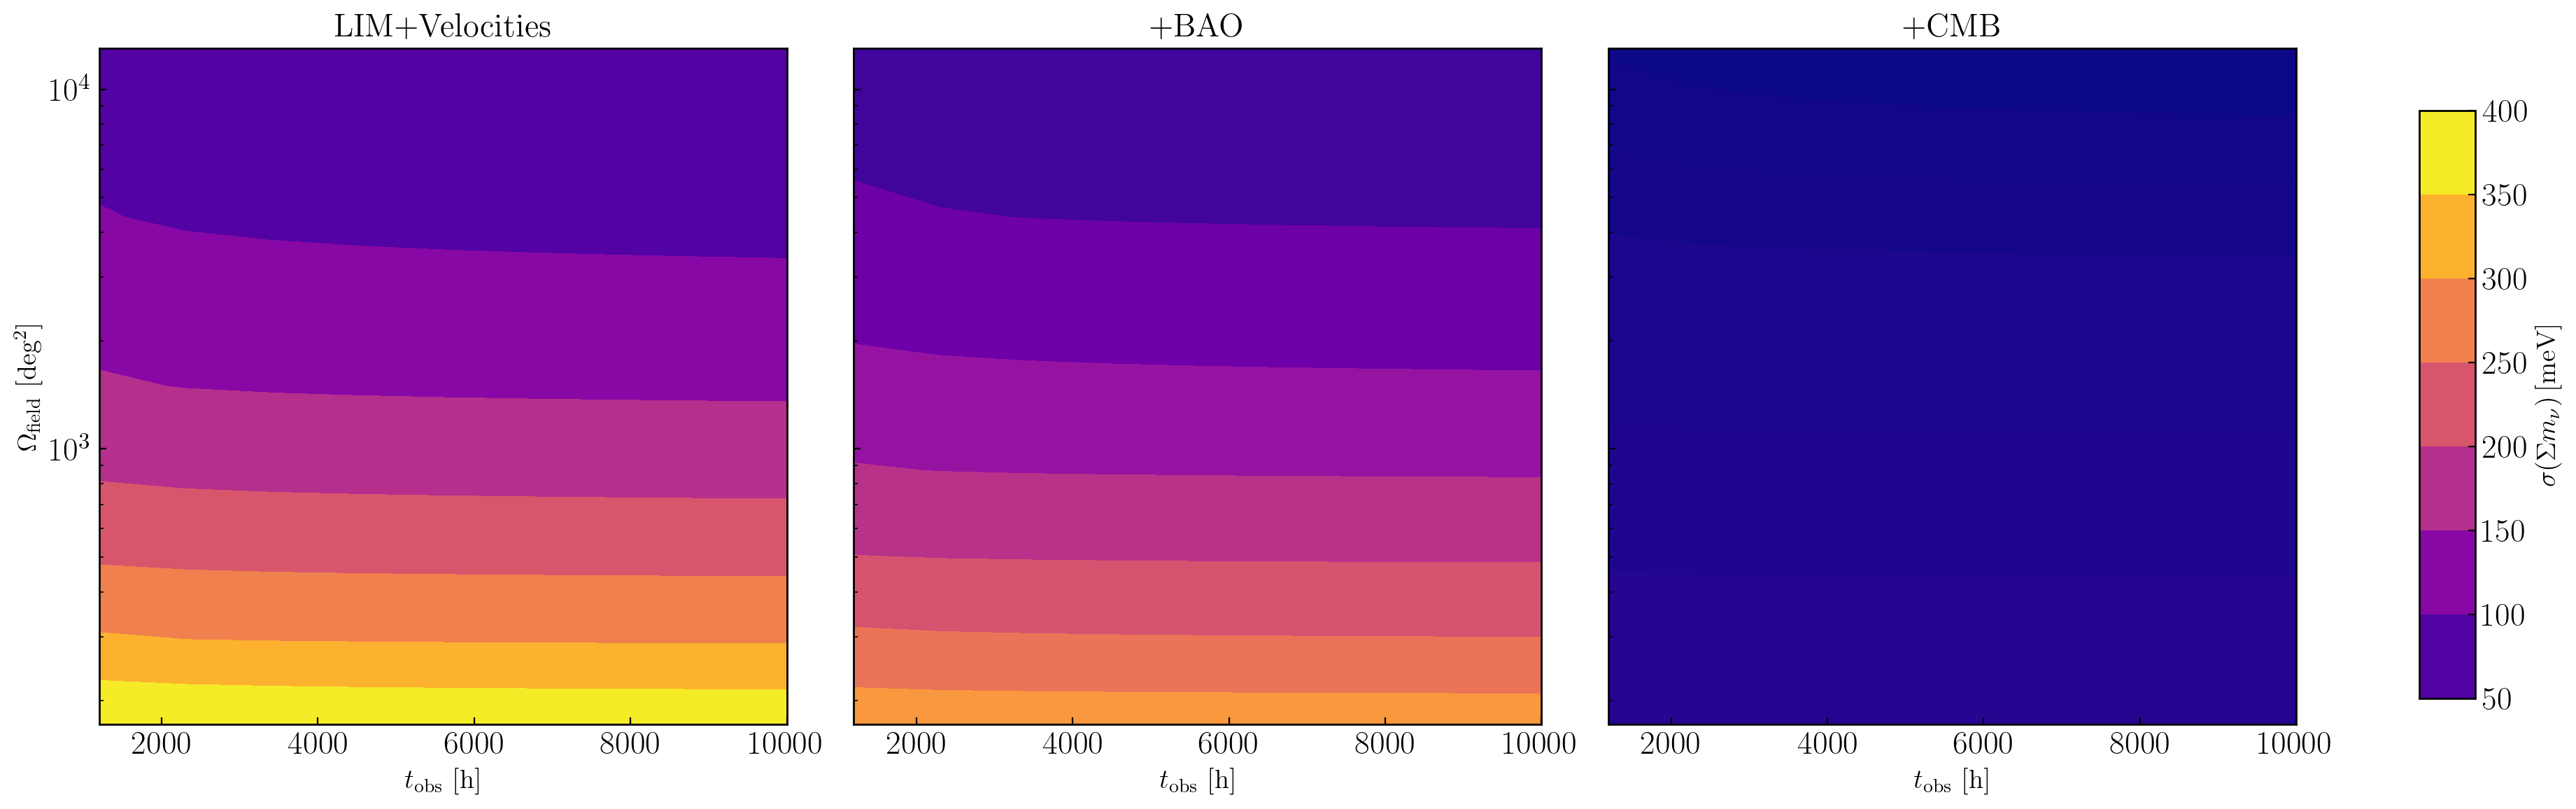

In [26]:
sig_mnu_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_BAO_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_BAO_CMB_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_pr_grid = np.zeros((len(Omegas), len(tobss)))


for o in range(len(Omegas)):
    for t in range(len(tobss)):
        F_XX = F_XX_om_tob[o,t]
        F_vX = F_vX_om_tob[o,t]
        
        F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
        F_bao_L2[:7,:7] = F_bao
        
        F_bao_CMB_lim_vel = np.zeros((len(F_vX), len(F_vX)))
        F_bao_CMB_lim_vel[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

        covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {})
        sig_mnu_vel_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_bao_L2+F_vX, cov_params3, [], {})
        sig_mnu_vel_BAO_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX, cov_params3, [], {})
        sig_mnu_vel_BAO_CMB_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])


vx = sig_mnu_vel_grid[1:, 1:] * 1e3
vx_bao = sig_mnu_vel_BAO_grid[1:, 1:] * 1e3
vx_bao_cmb = sig_mnu_vel_BAO_CMB_grid[1:, 1:] * 1e3

vmin = min(vx.min(), vx_bao.min(), vx_bao_cmb.min())
vmax = max(vx.max(), vx_bao.max(), vx_bao_cmb.max())

fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot the first grid
im1 = axs[0].contourf(tobss[1:], Omegas[1:], vx, cmap='plasma', vmin=vmin, vmax=vmax)
axs[0].set_title('LIM+Velocities')
axs[0].set_xlabel(r'$t_\mathrm{obs}$ [h]')
axs[0].set_ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
axs[0].set_yscale('log')
axs[0].set_xlim(tobss[1], tobss[-1])
axs[0].set_ylim(Omegas[1], Omegas[-1])

# Plot the second grid
im2 = axs[1].contourf(tobss[1:], Omegas[1:], vx_bao, cmap='plasma', vmin=vmin, vmax=vmax)
axs[1].set_title('+BAO')
axs[1].set_xlabel(r'$t_\mathrm{obs}$ [h]')
axs[1].set_yscale('log')
axs[1].set_xlim(tobss[1], tobss[-1])
axs[1].set_ylim(Omegas[1], Omegas[-1])

# Plot the third grid
im3 = axs[2].contourf(tobss[1:], Omegas[1:], vx_bao_cmb, cmap='plasma', vmin=vmin, vmax=vmax)
axs[2].set_title('+CMB')
axs[2].set_xlabel(r'$t_\mathrm{obs}$ [h]')
axs[2].set_yscale('log')
axs[2].set_xlim(tobss[1], tobss[-1])
axs[2].set_ylim(Omegas[1], Omegas[-1])

# Adjust layout to make room for the colorbar
fig.tight_layout(rect=[0, 0, 0.85, 1])

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label=r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')

plt.show()

(171.74440379730845, 13000.000000000005)

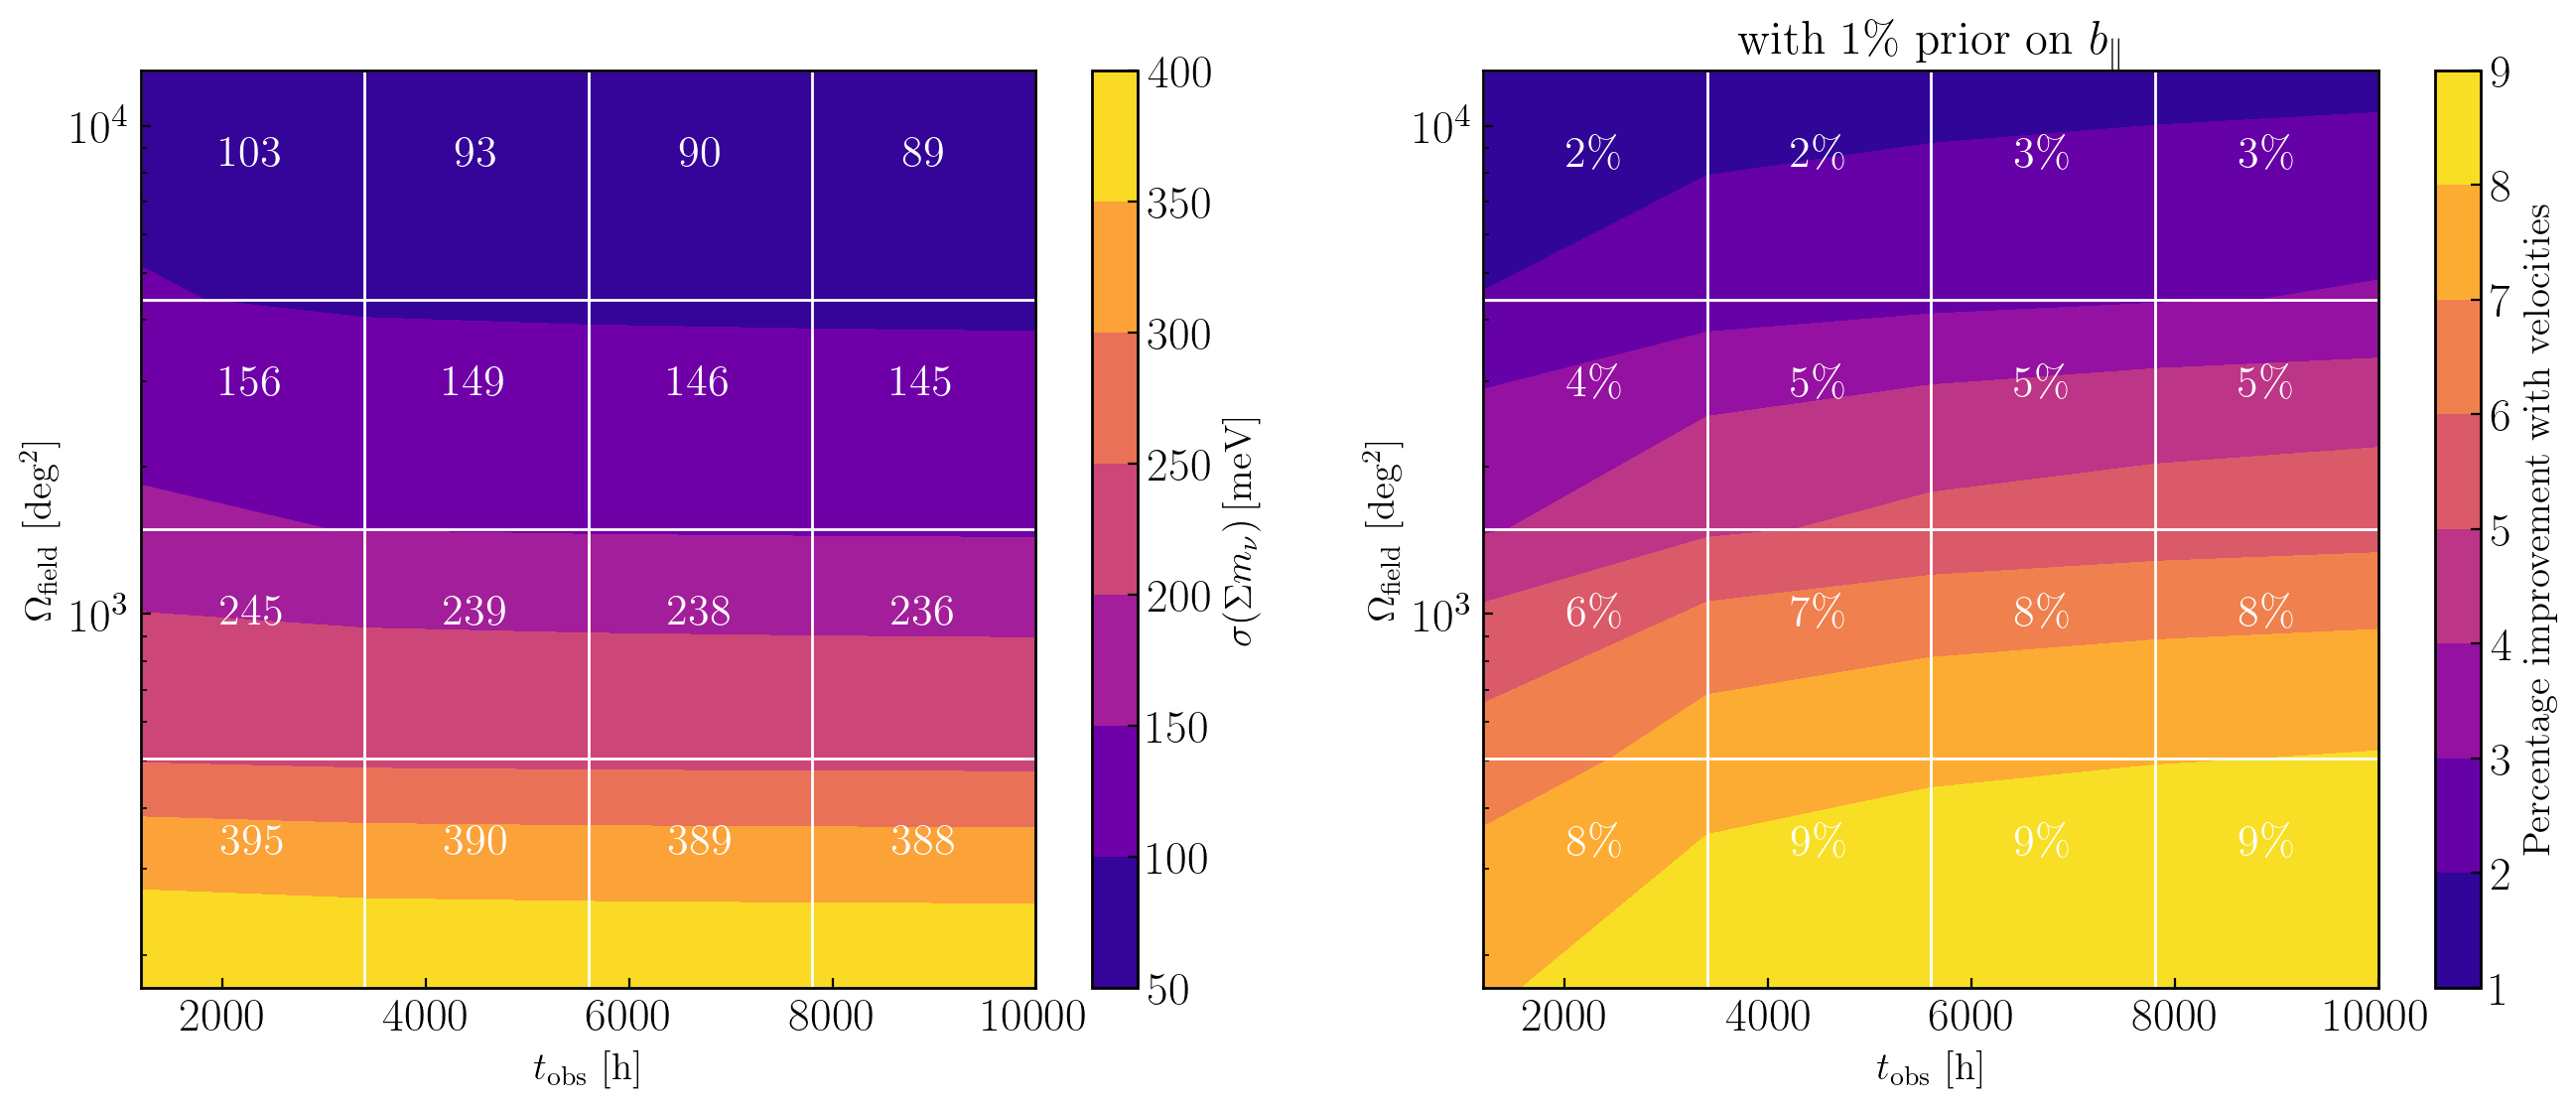

In [35]:
for o in range(len(Omegas)):
    for t in range(len(tobss)):
        F_XX = F_XX_om_tob[o,t]
        F_vX = F_vX_om_tob[o,t]
        
        covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
        sig_mnu_grid[o,t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'bv_par':0.01})
        sig_mnu_vel_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])


xx = sig_mnu_grid[1:,1:]*1e3
vx = sig_mnu_vel_grid[1:,1:]*1e3

# Resample to a 5x5 grid by selecting intermediate indices
#indices = [0, 2, 4, 6, 8]
indices = [1, 3, 5, 7, 9]
Omegas_resampled = Omegas[indices]
tobss_resampled = tobss[indices]

sig_mnu_grid_resampled = sig_mnu_grid[np.ix_(indices, indices)]
sig_mnu_vel_grid_resampled = sig_mnu_vel_grid[np.ix_(indices, indices)]

# Plotting the resampled grid
xx_resampled = sig_mnu_grid_resampled * 1e3
vx_resampled = sig_mnu_vel_grid_resampled * 1e3



plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

plt.contourf(tobss_resampled, Omegas_resampled, xx_resampled, cmap='plasma')#, vmin=0, vmax=400)
plt.colorbar(label=r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')#, ticks=np.linspace(0, 400, 5))

# Calculate the positions for the grid lines
tobs_midpoints_resampled = (tobss_resampled[:-1] + tobss_resampled[1:]) / 2
omega_midpoints_resampled = (Omegas_resampled[:-1] + Omegas_resampled[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss_resampled:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas_resampled:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints_resampled):
    for j, omega in enumerate(omega_midpoints_resampled):
        plt.text(tobs, omega, f'{xx_resampled[j, i]:.0f}', ha='center', va='center', color='white', fontsize=16)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.yscale('log')
plt.xlim(tobss_resampled[0], tobss_resampled[-1])
plt.ylim(Omegas_resampled[0], Omegas_resampled[-1])



plt.subplot(1,2,2)

plt.contourf(tobss_resampled, Omegas_resampled, (xx_resampled-vx_resampled)/xx_resampled*100, cmap='plasma')
plt.colorbar(label='Percentage improvement with velocities')

# Calculate the positions for the grid lines
tobs_midpoints_resampled = (tobss_resampled[:-1] + tobss_resampled[1:]) / 2
omega_midpoints_resampled = (Omegas_resampled[:-1] + Omegas_resampled[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss_resampled:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas_resampled:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints_resampled):
    for j, omega in enumerate(omega_midpoints_resampled):
        plt.text(tobs, omega, f'{((xx_resampled-vx_resampled)/xx_resampled*100)[j, i]:.0f}\%', ha='center', va='center', color='white', fontsize=16)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.title(r'with 1\% prior on $b_\parallel$')
plt.yscale('log')
plt.xlim(tobss_resampled[0], tobss_resampled[-1])
plt.ylim(Omegas_resampled[0], Omegas_resampled[-1])

In [26]:
Omegas = np.logspace(np.log10(200), np.log10(18500), 6)
tobss = np.linspace(1000, 12250, 6)

cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
m = update_Pkline(obs_params,cosmo_model_params)[0]

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']


F_XX_om_tob = []
F_vX_om_tob = []

F_XX_om_tob = np.zeros((len(Omegas),len(tobss),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
F_vX_om_tob = np.zeros((len(Omegas),len(tobss),len(free_params)-1,len(free_params)-1))

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for o in range(len(Omegas)):
    for t in range(len(tobss)):
        obs_params['Omega_field'] = Omegas[o]*u.deg**2
        obs_params['tobs'] = tobss[t]*u.h
        for i in range(len(zs)):  
            nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
            cosmo_model_params['nuObs'] = nu
            obs_params['Delta_nu'] = Dnu
            obs_params['dnu'] = (nu/R).to(u.MHz)
            obs_params['beam_FWHM'] = beam[i]
            obs_params['sigma_pix'] = sigpix[i]
            m = update_Pkline(obs_params,cosmo_model_params)[0]
            bias_params['bT'] = (m.bavg[0]*m.Tmean).value
            print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

            vol = m.Vfield
            xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

            cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
            cov_xx = np.delete(cov_xx, -1, axis=0)
            cov_xx = np.delete(cov_xx, -1, axis=1)
            Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

            cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
            cov_vx = np.delete(cov_vx, -1, axis=0)
            cov_vx = np.delete(cov_vx, -1, axis=1)
            Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

        F_vX_om_tob[o,t] = np.sum(Fz_vX_LIM, axis=0)
        F_XX_om_tob[o,t] = np.sum(Fz_XX_LIM, axis=0)
        

cov_params2.remove('bT')
cov_params3.remove('bT')

# with open(fisher_root+'F_vX_omega_tobs_AtLAST.pkl', 'wb') as file: 
#     pickle.dump(F_vX_om_tob, file)
    
# with open(fisher_root+'F_XX_omega_tob_AtLAST.pkl', 'wb') as file: 
#     pickle.dump(F_XX_om_tob, file)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 201239.44459896523 Jy / sr 200.00000000000003 deg2 1000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 16241.932404273823 Jy / sr 494.60481760769335 



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 178691.6880990284 Jy / sr 1223.1696280036979 deg2 1000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted



Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 276062.78215708054 Jy / sr 1223.1696280036979 deg2 3250.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest f



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 28358.63612583001 Jy / sr 1223.1696280036979 deg2 3250.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earlie



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 38119.04672704859 Jy / sr 1223.1696280036979 deg2 5500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simula



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 64187.94922140051 Jy / sr 1223.1696280036979 deg2 7750.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest f



Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 157380.0 Jy / sr 1223.1696280036979 deg2 10000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now sim

Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 16166.91 Jy / sr 1223.1696280036979 deg2 10000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 139743.84666666665 Jy / sr



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 351654.3108897528 Jy / sr 7480.719694353515 deg2 12250.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earlies



Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 36124.25626323591 Jy / sr 7480.719694353515 deg2 12250.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (ea



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 347675.5105500314 Jy / sr 18499.999999999996 deg2 1000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simu



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 385486.0141032979 Jy / sr 18499.999999999996 deg2 3250.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 825308.2776371286 Jy / sr 18499.999999999996 deg2 5500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


N



Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 84781.25296862616 Jy / sr 18499.999999999996 deg2 5500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest

Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 124888.73015930312 Jy / sr 18499.999999999996 deg2 7750.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now sim

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt

(200.00000000000003, 18499.999999999996)

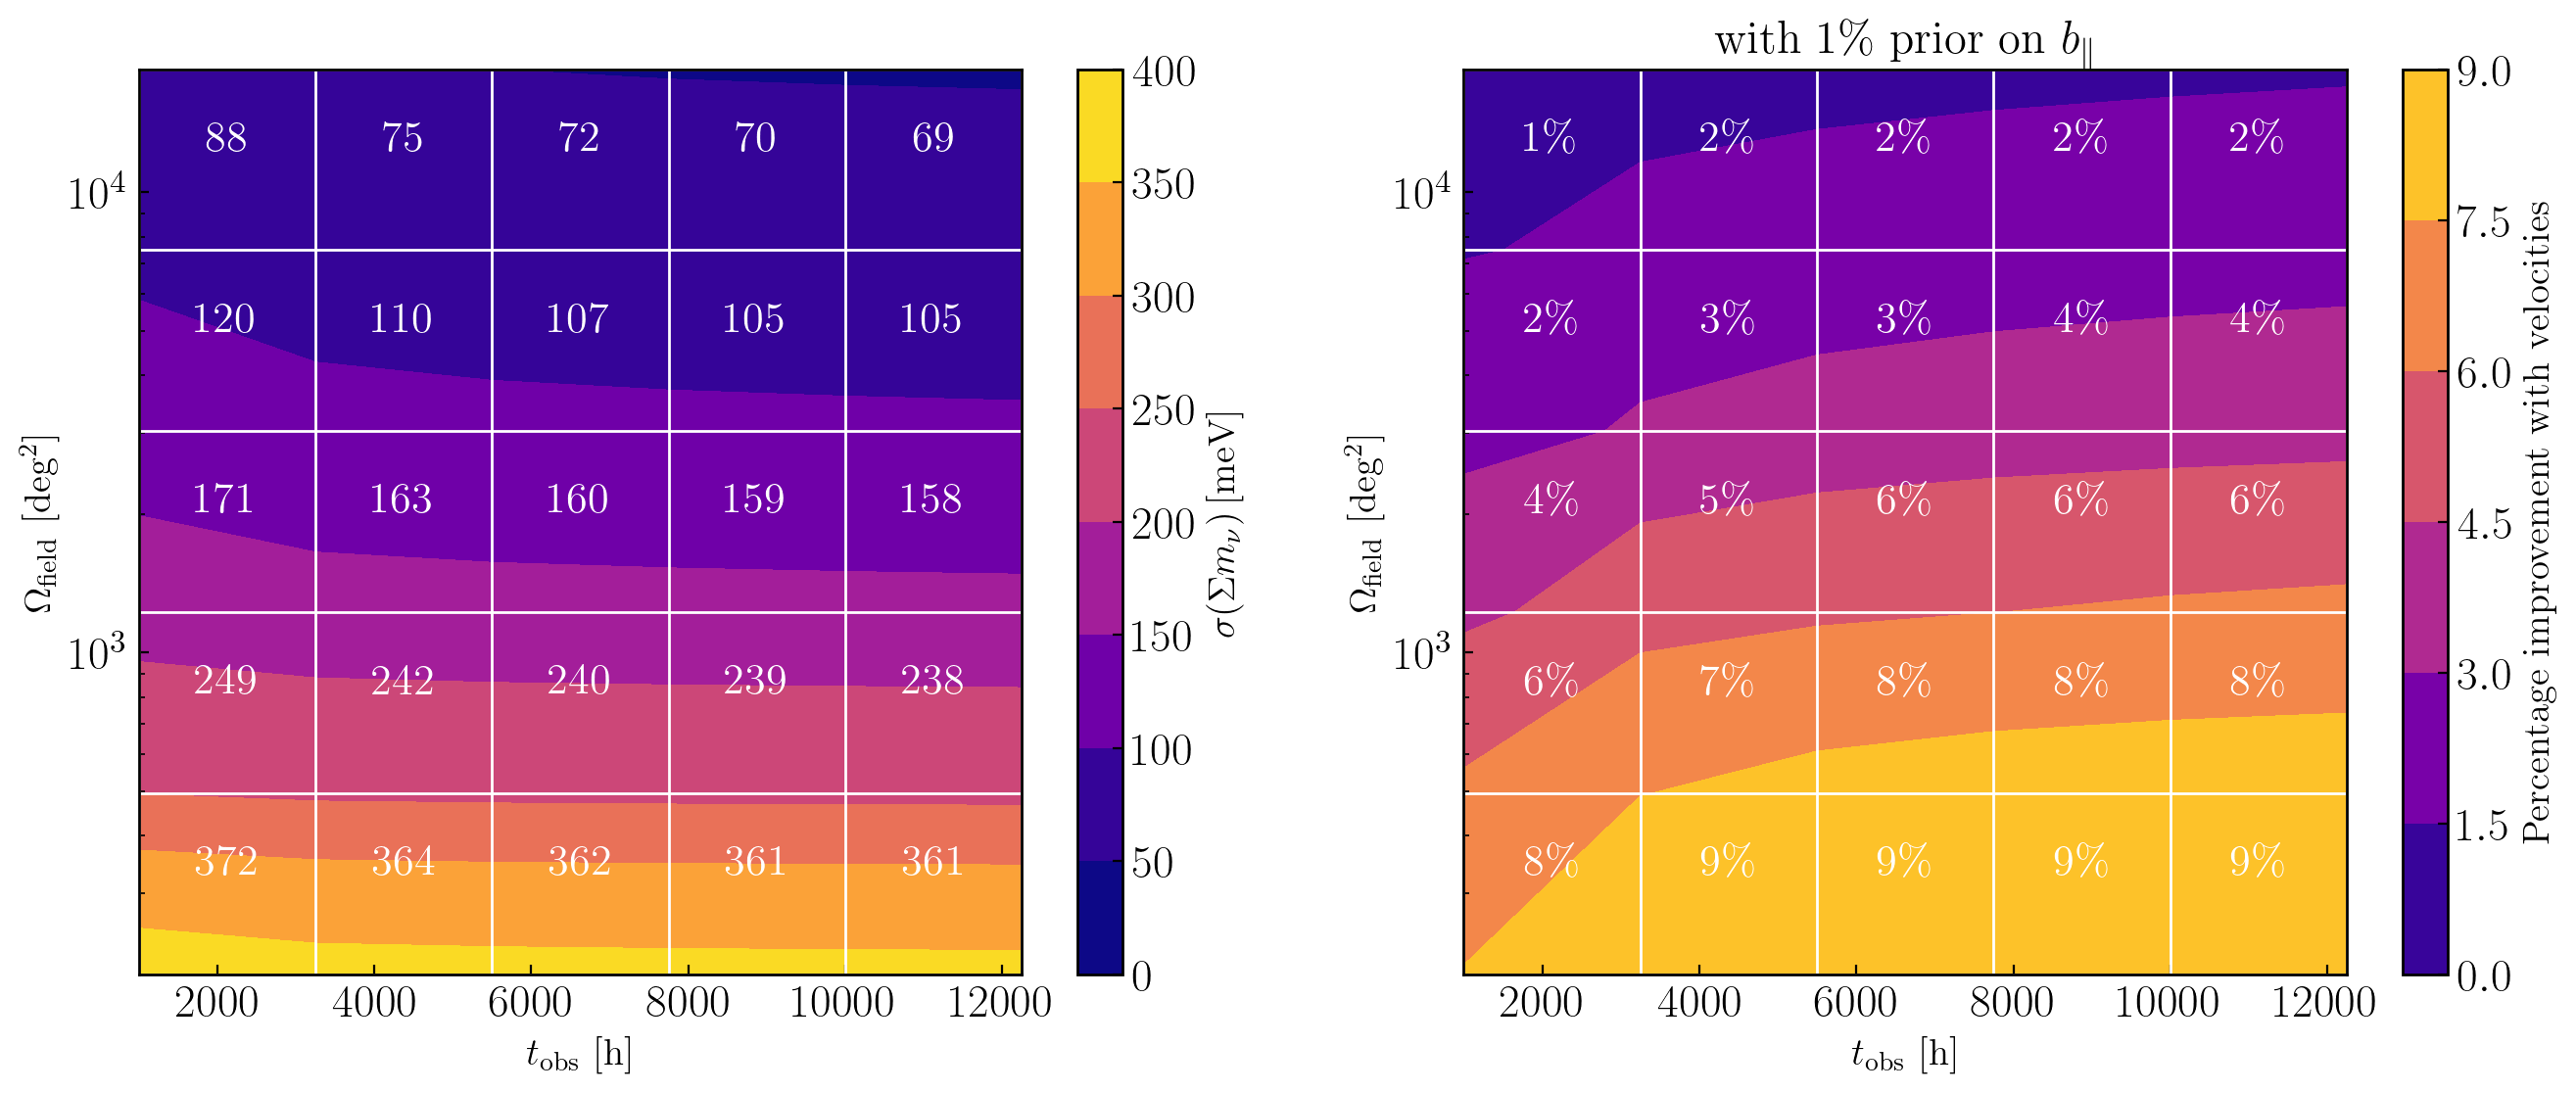

In [137]:
mnu_ind = free_params.index('mnu')
sig_mnu_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_pr_grid = np.zeros((len(Omegas), len(tobss)))

for o in range(len(Omegas)):
    for t in range(len(tobss)):
        F_XX = F_XX_om_tob[o,t]
        F_vX = F_vX_om_tob[o,t]
        
        covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
        sig_mnu_grid[o,t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'bv_par':0.01})
        sig_mnu_vel_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])


xx = sig_mnu_grid*1e3
vx = sig_mnu_vel_grid*1e3


plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

plt.contourf(tobss, Omegas, xx, cmap='plasma', vmin=50, vmax=400)
plt.colorbar(label=r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')#, ticks=np.linspace(50, 400, 5))

# Calculate the positions for the grid lines
tobs_midpoints = (tobss[:-1] + tobss[1:]) / 2
omega_midpoints = (Omegas[:-1] + Omegas[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints):
    for j, omega in enumerate(omega_midpoints):
        plt.text(tobs, omega, f'{xx[j, i]:.0f}', ha='center', va='center', color='white', fontsize=16)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.yscale('log')
plt.xlim(tobss[0], tobss[-1])
plt.ylim(Omegas[0], Omegas[-1])



plt.subplot(1,2,2)

plt.contourf(tobss, Omegas, (xx-vx)/xx*100, cmap='plasma', vmin=0, vmax=9.5)
plt.colorbar(label='Percentage improvement with velocities')

# Calculate the positions for the grid lines
tobs_midpoints = (tobss[:-1] + tobss[1:]) / 2
omega_midpoints = (Omegas[:-1] + Omegas[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints):
    for j, omega in enumerate(omega_midpoints):
        plt.text(tobs, omega, f'{((xx-vx)/xx*100)[j, i]:.0f}\%', ha='center', va='center', color='white', fontsize=16)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.title(r'with 1\% prior on $b_\parallel$')
plt.yscale('log')
plt.xlim(tobss[0], tobss[-1])
plt.ylim(Omegas[0], Omegas[-1])

(200.00000000000003, 18499.999999999996)

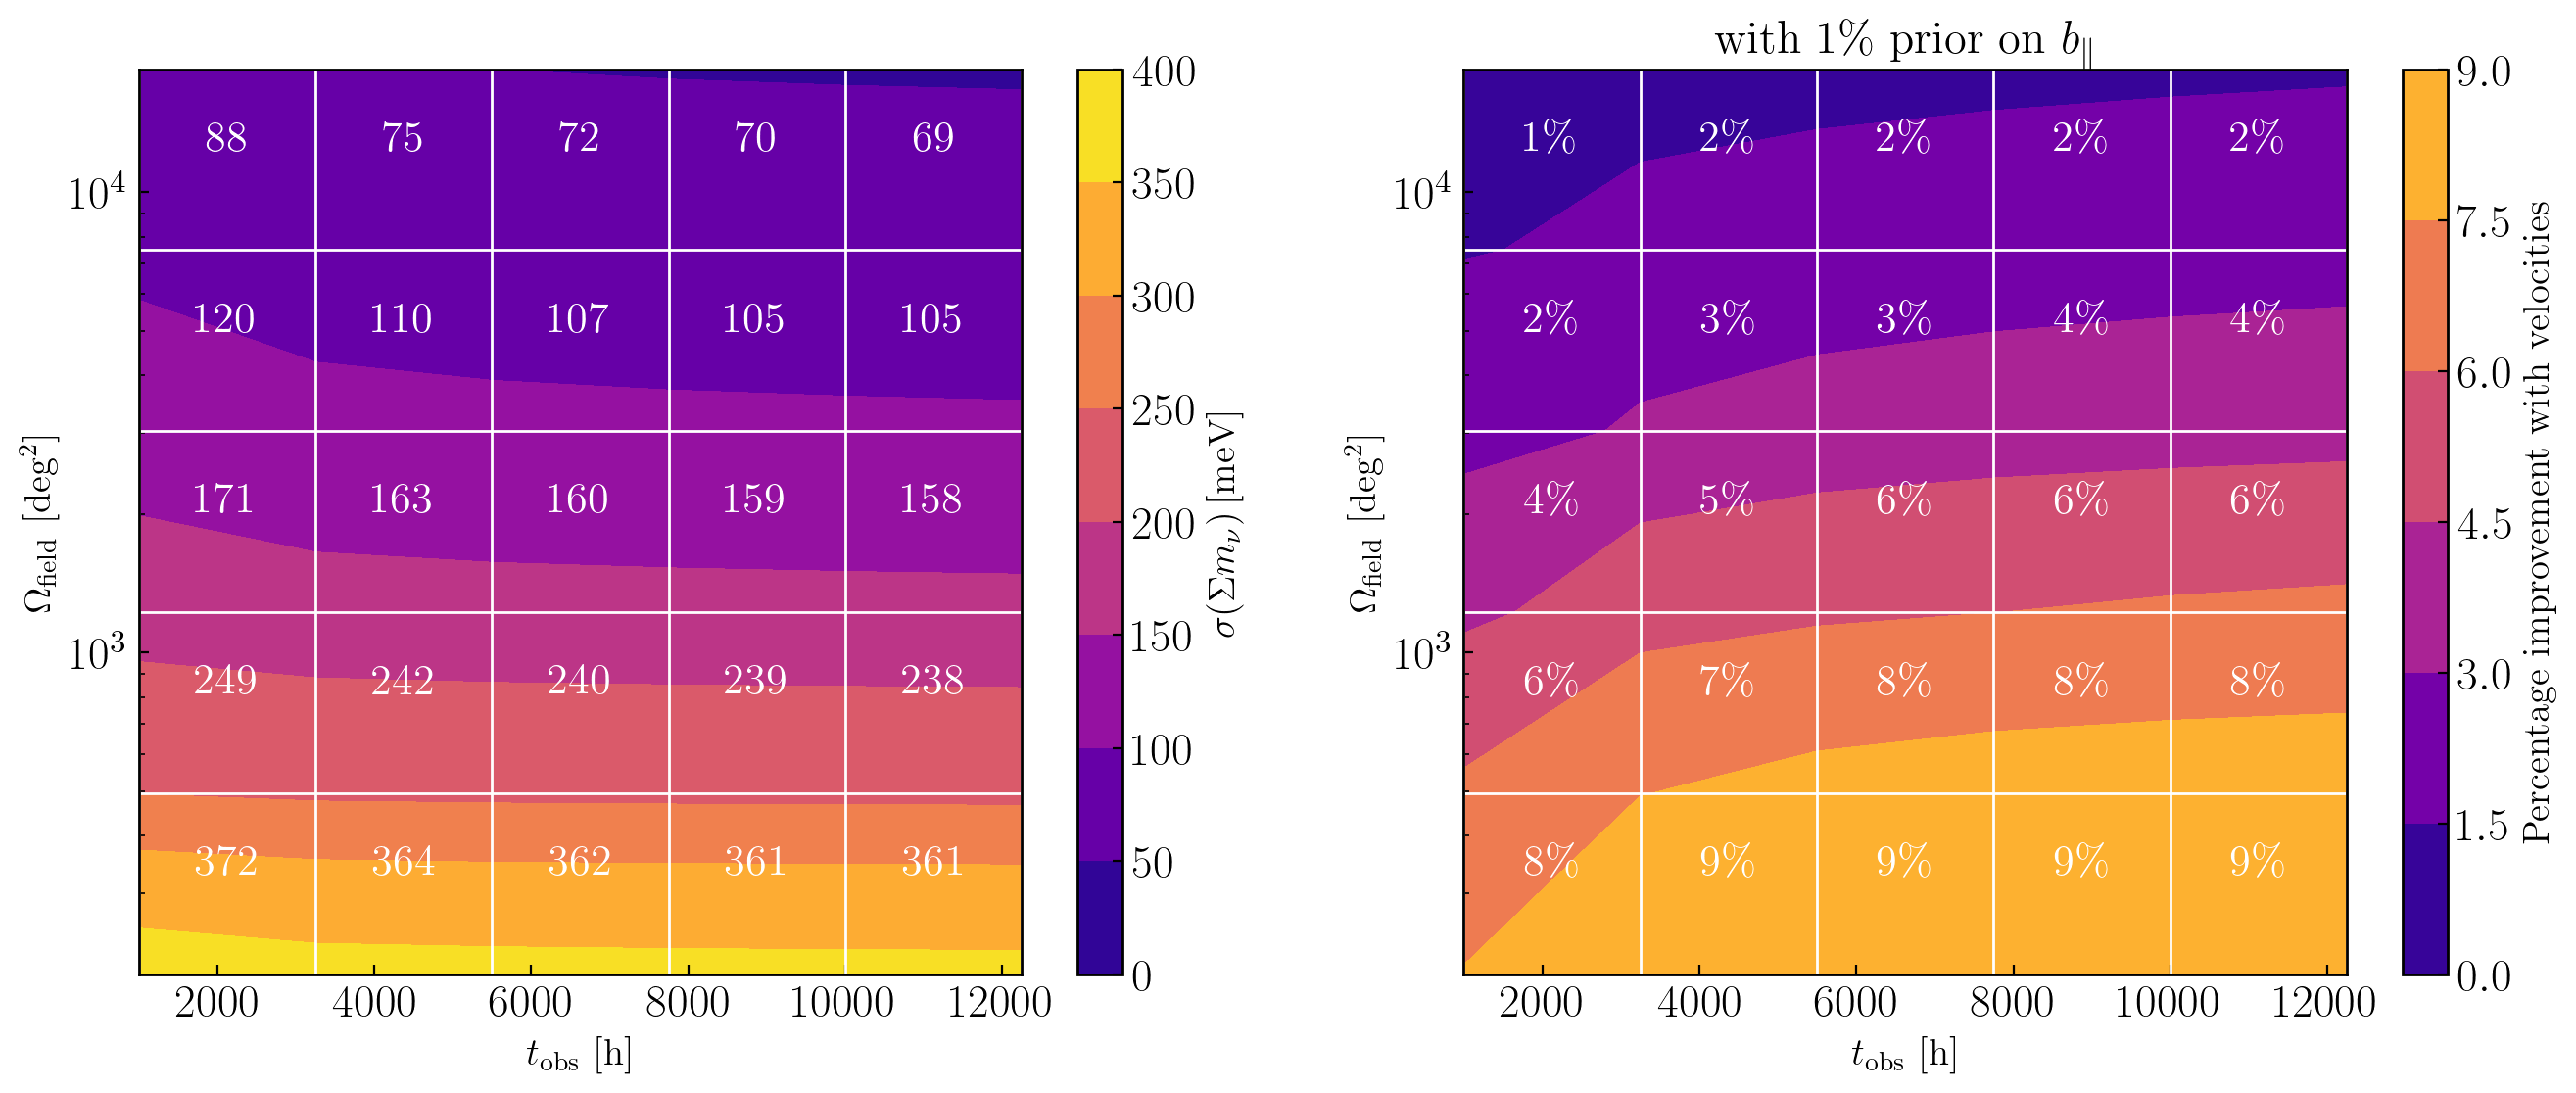

In [143]:
for o in range(len(Omegas)):
    for t in range(len(tobss)):
        F_XX = F_XX_om_tob[o,t]
        F_vX = F_vX_om_tob[o,t]
        
        covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
        sig_mnu_grid[o,t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'bv_par':0.01})
        sig_mnu_vel_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])


xx = sig_mnu_grid*1e3
vx = sig_mnu_vel_grid*1e3


plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

plt.contourf(tobss, Omegas, xx, cmap='plasma', vmin=0, vmax=400)
plt.colorbar(label=r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')#, ticks=np.linspace(50, 400, 5))

# Calculate the positions for the grid lines
tobs_midpoints = (tobss[:-1] + tobss[1:]) / 2
omega_midpoints = (Omegas[:-1] + Omegas[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints):
    for j, omega in enumerate(omega_midpoints):
        plt.text(tobs, omega, f'{xx[j, i]:.0f}', ha='center', va='center', color='white', fontsize=16)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.yscale('log')
plt.xlim(tobss[0], tobss[-1])
plt.ylim(Omegas[0], Omegas[-1])



plt.subplot(1,2,2)

plt.contourf(tobss, Omegas, (xx-vx)/xx*100, cmap='plasma', vmin=0, vmax=10)
plt.colorbar(label='Percentage improvement with velocities')

# Calculate the positions for the grid lines
tobs_midpoints = (tobss[:-1] + tobss[1:]) / 2
omega_midpoints = (Omegas[:-1] + Omegas[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints):
    for j, omega in enumerate(omega_midpoints):
        plt.text(tobs, omega, f'{((xx-vx)/xx*100)[j, i]:.0f}\%', ha='center', va='center', color='white', fontsize=16)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.title(r'with 1\% prior on $b_\parallel$')
plt.yscale('log')
plt.xlim(tobss[0], tobss[-1])
plt.ylim(Omegas[0], Omegas[-1])

## As function of $t_\mathrm{obs}$ or $\Omega_\mathrm{field}$
Tests for the early-AtLAST setup determination

In [789]:
Omegas2 = np.logspace(2,np.log10(7500),10)
Omegas2 = np.logspace(2,np.log10(7500),10)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
m = update_Pkline(obs_params,cosmo_model_params)[0]


F_XX_om_tob10000 = []
F_vX_om_tob10000 = []

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for o in range(len(Omegas2)):
    obs_params['Omega_field'] = Omegas2[o]*u.deg**2
    for i in range(len(zs)):  
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

        vol = m.Vfield
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

    F_vX_om_tob10000.append(np.sum(Fz_vX_LIM, axis=0))
    F_XX_om_tob10000.append(np.sum(Fz_XX_LIM, axis=0))


cov_params2.remove('bT')
cov_params3.remove('bT')

with open(fisher_root+'F_vX_omega_tobs10000.pkl', 'wb') as file: 
    pickle.dump(F_vX_om_tob10000, file)
    
with open(fisher_root+'F_XX_omega_tob10000.pkl', 'wb') as file: 
    pickle.dump(F_XX_om_tob10000, file)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 45000.0 Jy / sr 100.0 deg2 10000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for 

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f

Text(0.5, 1.0, '$t_\\mathrm{obs} = 10000$ h, 1\\% prior on $b_\\parallel$')

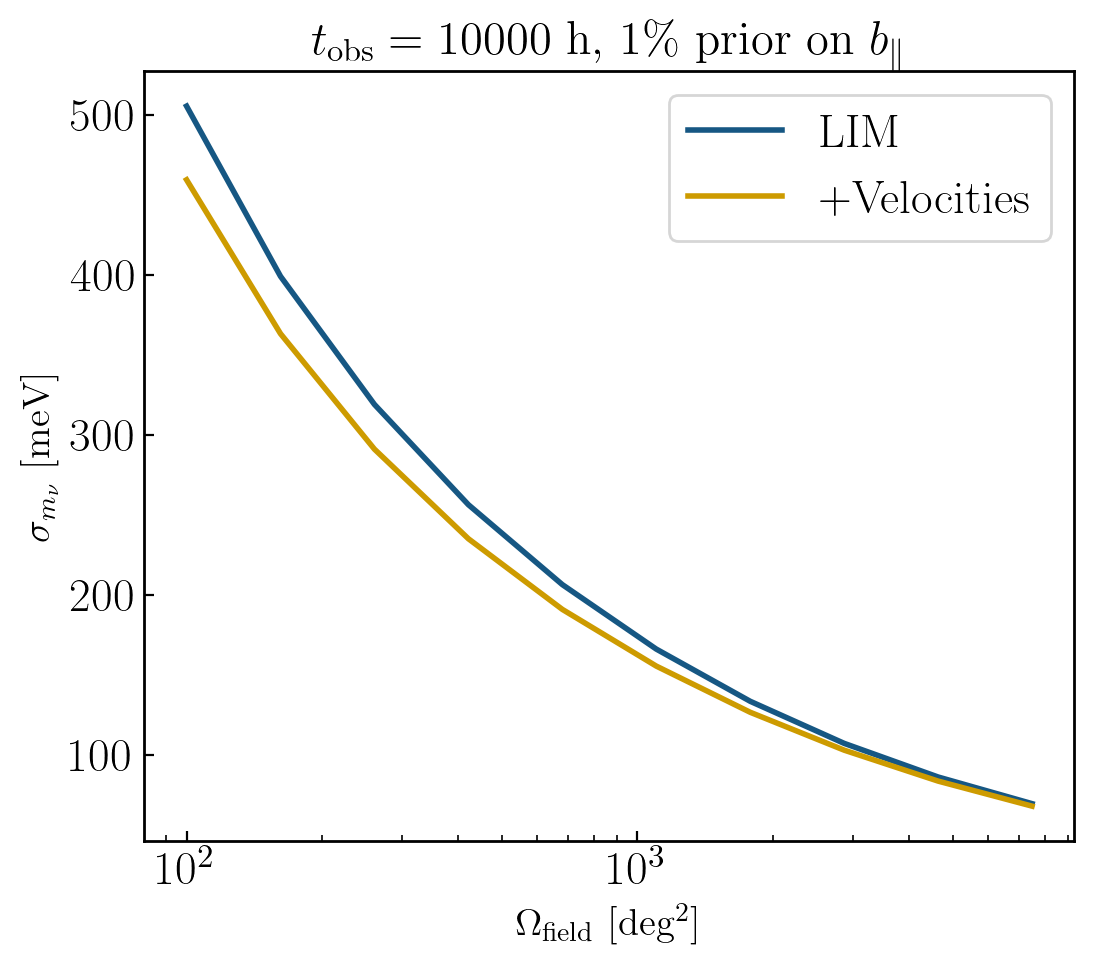

In [795]:
sig_mnu_LIM_om = np.zeros(len(Omegas2))
sig_mnu_LIM_kSZ_om = np.zeros(len(Omegas2))

for t in range(len(Omegas)):
    covmat_lim_z, cov_params = covariance_mat(F_XX_om_tob10000[t], cov_params2, fixed_params, {})
    sig_mnu_LIM_om[t] = np.sqrt(covmat_lim_z[mnu_ind,mnu_ind])
    covmat_lim_kSZ_z, cov_params = covariance_mat(F_vX_om_tob10000[t], cov_params3, [], {'bv_par':0.01})
    sig_mnu_LIM_kSZ_om[t] = np.sqrt(covmat_lim_kSZ_z[mnu_ind,mnu_ind])
    
plt.semilogx(Omegas2, sig_mnu_LIM_om*1e3, label='LIM')
plt.semilogx(Omegas2, sig_mnu_LIM_kSZ_om*1e3, label='+Velocities')
plt.legend()
plt.xlabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.ylabel(r'$\sigma_{m_\nu}$ [meV]')
plt.title(r'$t_\mathrm{obs} = 10000$ h, 1\% prior on $b_\parallel$')
#plt.xlim(Omegas2[0], Omegas2[-1])

In [796]:
Omegas2 = np.logspace(2,np.log10(7500),10)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=True)
m = update_Pkline(obs_params,cosmo_model_params)[0]


F_XX_om_tob1000 = []
F_vX_om_tob1000 = []

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for o in range(len(Omegas2)):
    obs_params['Omega_field'] = Omegas2[o]*u.deg**2
    for i in range(len(zs)):  
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

        vol = m.Vfield
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

    F_vX_om_tob1000.append(np.sum(Fz_vX_LIM, axis=0))
    F_XX_om_tob1000.append(np.sum(Fz_XX_LIM, axis=0))


cov_params2.remove('bT')
cov_params3.remove('bT')

with open(fisher_root+'F_vX_omega_tobs1000.pkl', 'wb') as file: 
    pickle.dump(F_vX_om_tob10000, file)
    
with open(fisher_root+'F_XX_omega_tob1000.pkl', 'wb') as file: 
    pickle.dump(F_XX_om_tob10000, file)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 142302.49470757708 Jy / sr 100.0 deg2 1000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simul

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f

Text(0.5, 1.0, '$t_\\mathrm{obs} = 1000$ h, 1\\% prior on $b_\\parallel$')

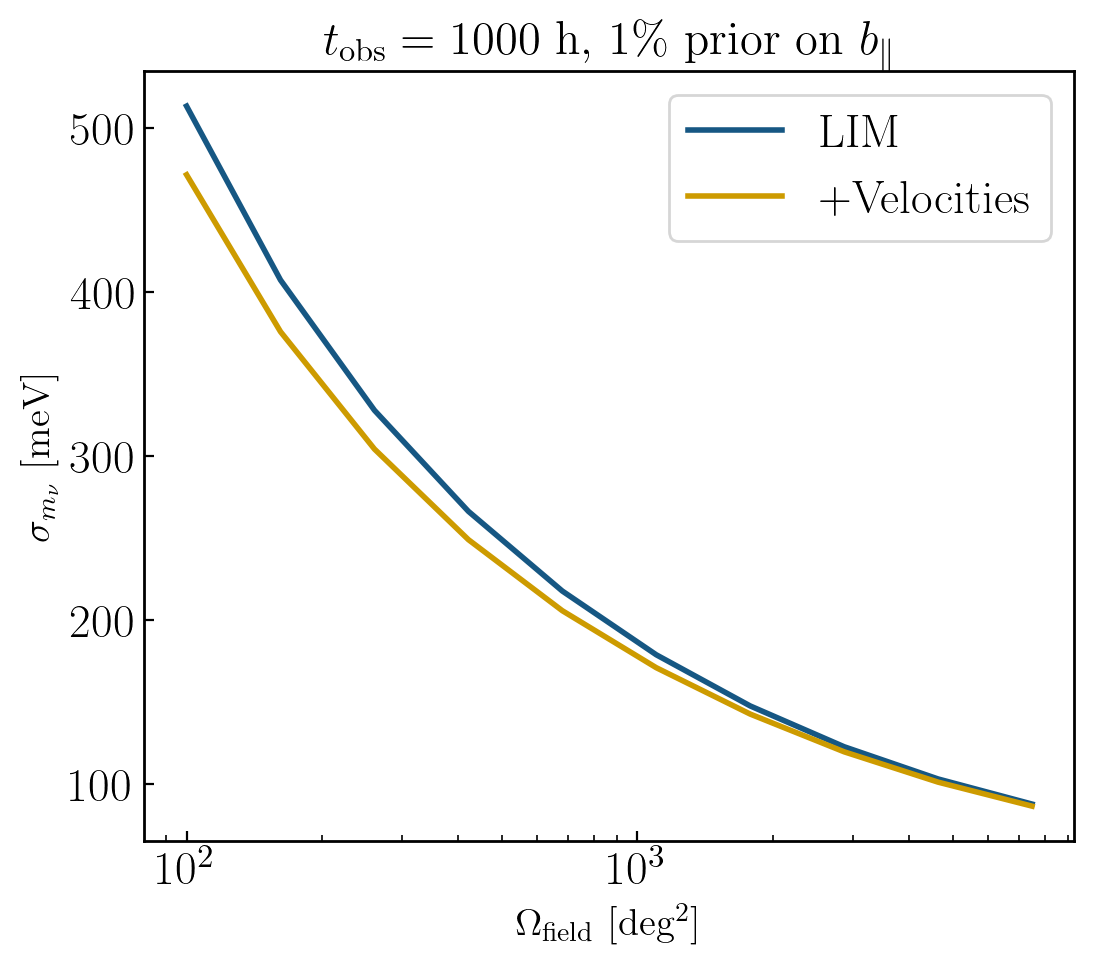

In [797]:
sig_mnu_LIM_om = np.zeros(len(Omegas2))
sig_mnu_LIM_kSZ_om = np.zeros(len(Omegas2))

for t in range(len(Omegas)):
    covmat_lim_z, cov_params = covariance_mat(F_XX_om_tob1000[t], cov_params2, fixed_params, {})
    sig_mnu_LIM_om[t] = np.sqrt(covmat_lim_z[mnu_ind,mnu_ind])
    covmat_lim_kSZ_z, cov_params = covariance_mat(F_vX_om_tob1000[t], cov_params3, [], {'bv_par':0.01})
    sig_mnu_LIM_kSZ_om[t] = np.sqrt(covmat_lim_kSZ_z[mnu_ind,mnu_ind])
    
plt.semilogx(Omegas2, sig_mnu_LIM_om*1e3, label='LIM')
plt.semilogx(Omegas2, sig_mnu_LIM_kSZ_om*1e3, label='+Velocities')
plt.legend()
plt.xlabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.ylabel(r'$\sigma_{m_\nu}$ [meV]')
plt.title(r'$t_\mathrm{obs} = 1000$ h, 1\% prior on $b_\parallel$')

In [800]:
tobss2 = np.linspace(1000,10000,10)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
m = update_Pkline(obs_params,cosmo_model_params)[0]


F_XX_tob_om7500 = []
F_vX_tob_om7500 = []

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for t in range(len(tobss2)):
    obs_params['tobs'] = tobss2[t]*u.h
    for i in range(len(zs)):  
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

        vol = m.Vfield
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

    F_XX_tob_om7500.append(np.sum(Fz_vX_LIM, axis=0))
    F_vX_tob_om7500.append(np.sum(Fz_XX_LIM, axis=0))


cov_params2.remove('bT')
cov_params3.remove('bT')

with open(fisher_root+'F_vX_tob_om7500.pkl', 'wb') as file: 
    pickle.dump(F_vX_om_tob10000, file)
    
with open(fisher_root+'F_XX_tob_om7500.pkl', 'wb') as file: 
    pickle.dump(F_XX_om_tob10000, file)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 1232371.226944219 Jy / sr 7500.0 deg2 1000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simul

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Text(0.5, 1.0, '$\\Omega_\\mathrm{field} = 7500$ deg$^2$, 1\\% prior on $b_\\parallel$')

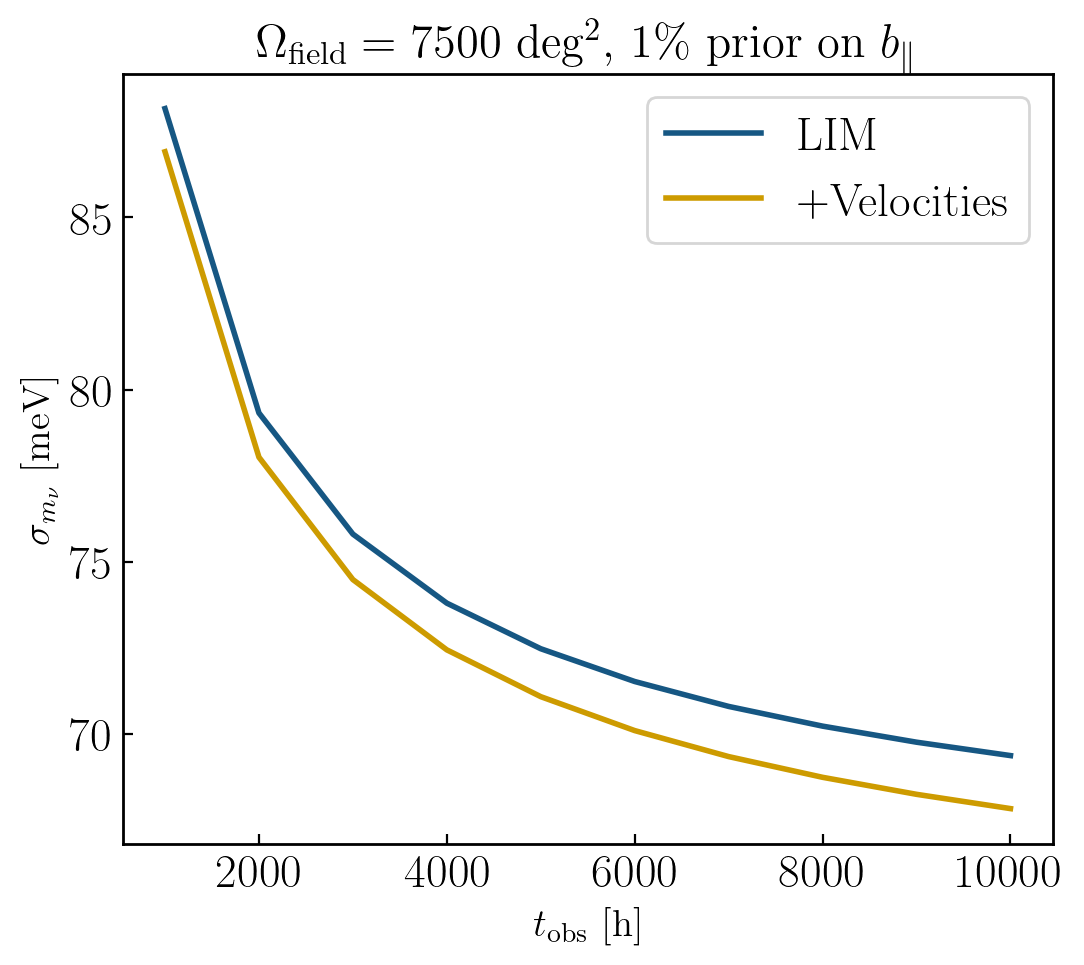

In [804]:
sig_mnu_LIM_om = np.zeros(len(tobss2))
sig_mnu_LIM_kSZ_om = np.zeros(len(tobss2))

for t in range(len(tobss2)):
    covmat_lim_z, cov_params = covariance_mat(F_vX_tob_om7500[t], cov_params2, fixed_params, {})
    sig_mnu_LIM_om[t] = np.sqrt(covmat_lim_z[mnu_ind,mnu_ind])
    covmat_lim_kSZ_z, cov_params = covariance_mat(F_XX_tob_om7500[t], cov_params3, [], {'bv_par':0.01})
    sig_mnu_LIM_kSZ_om[t] = np.sqrt(covmat_lim_kSZ_z[mnu_ind,mnu_ind])
    
plt.plot(tobss2, sig_mnu_LIM_om*1e3, label='LIM')
plt.plot(tobss2, sig_mnu_LIM_kSZ_om*1e3, label='+Velocities')
plt.legend()
plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\sigma_{m_\nu}$ [meV]')
plt.title(r'$\Omega_\mathrm{field} = 7500$ deg$^2$, 1\% prior on $b_\parallel$')

In [803]:
F_XX_tob_om7500[0].shape

(9, 9)

In [805]:
tobss2 = np.linspace(1000,10000,10)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=True)
m = update_Pkline(obs_params,cosmo_model_params)[0]


F_XX_tob_om200 = []
F_vX_tob_om200 = []

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for t in range(len(tobss2)):
    obs_params['tobs'] = tobss2[t]*u.h
    for i in range(len(zs)):  
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

        vol = m.Vfield
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

    F_XX_tob_om200.append(np.sum(Fz_XX_LIM, axis=0))
    F_vX_tob_om200.append(np.sum(Fz_vX_LIM, axis=0))


cov_params2.remove('bT')
cov_params3.remove('bT')

with open(fisher_root+'F_vX_tob_om200.pkl', 'wb') as file: 
    pickle.dump(F_vX_om_tob10000, file)
    
with open(fisher_root+'F_XX_tob_om200.pkl', 'wb') as file: 
    pickle.dump(F_XX_om_tob10000, file)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 201239.44459896523 Jy / sr 200.0 deg2 1000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simul

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Text(0.5, 1.0, '$\\Omega_\\mathrm{field} = 200$ deg$^2$, 1\\% prior on $b_\\parallel$')

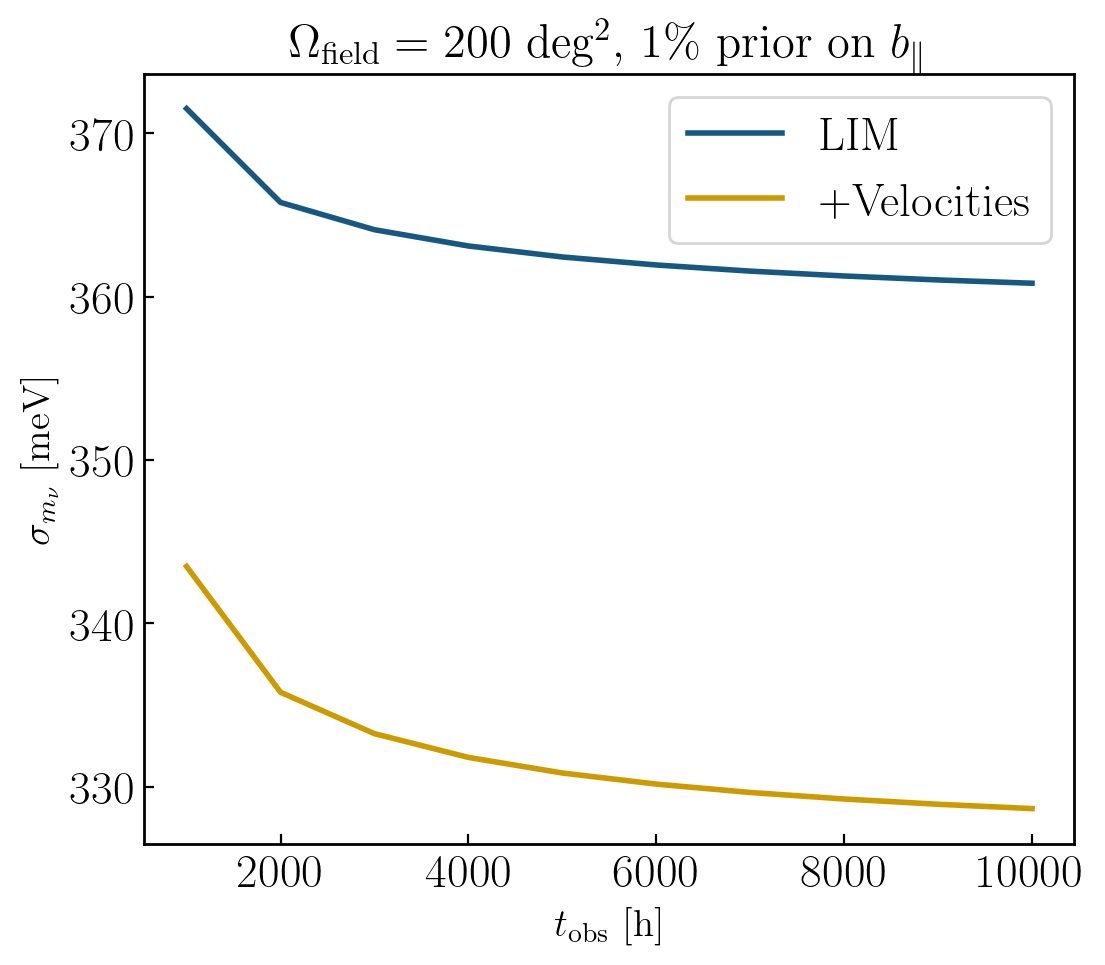

In [806]:
sig_mnu_LIM_om = np.zeros(len(tobss2))
sig_mnu_LIM_kSZ_om = np.zeros(len(tobss2))

for t in range(len(Omegas)):
    covmat_lim_z, cov_params = covariance_mat(F_XX_tob_om200[t], cov_params2, fixed_params, {})
    sig_mnu_LIM_om[t] = np.sqrt(covmat_lim_z[mnu_ind,mnu_ind])
    covmat_lim_kSZ_z, cov_params = covariance_mat(F_vX_tob_om200[t], cov_params3, [], {'bv_par':0.01})
    sig_mnu_LIM_kSZ_om[t] = np.sqrt(covmat_lim_kSZ_z[mnu_ind,mnu_ind])
    
plt.plot(tobss2, sig_mnu_LIM_om*1e3, label='LIM')
plt.plot(tobss2, sig_mnu_LIM_kSZ_om*1e3, label='+Velocities')
plt.legend()
plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\sigma_{m_\nu}$ [meV]')
plt.title(r'$\Omega_\mathrm{field} = 200$ deg$^2$, 1\% prior on $b_\parallel$')

## Tests for early-AtLAST

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 142298.32043984215 Jy / sr 300.0 deg2
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)

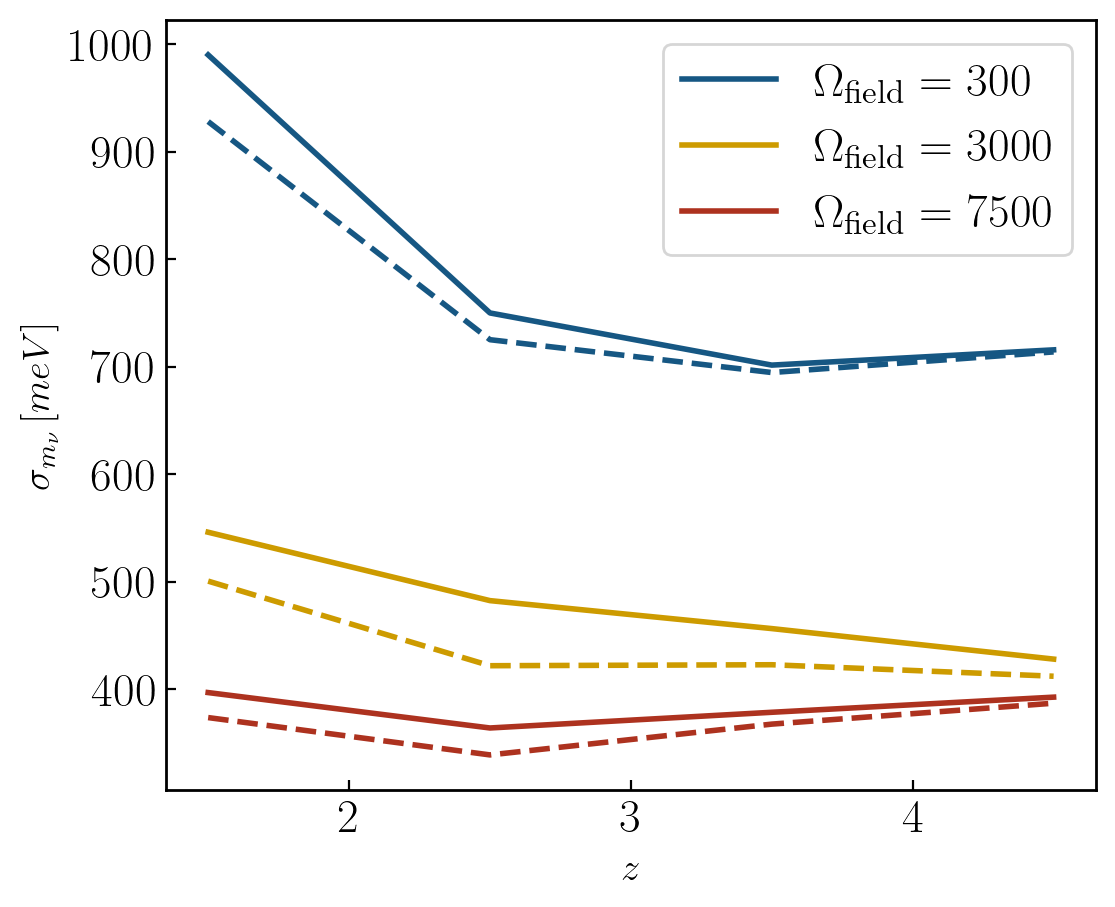

In [155]:
Omegas = np.array([300,3000,7500])

cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
obs_params['tobs'] = 3000*u.h

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

F_XX_om = []
F_vX_om = []

mnu_ind = free_params.index('mnu')
sig_mnu_LIM_bins = np.zeros(len(zs))
sig_mnu_LIM_kSZ_bins = np.zeros(len(zs))

Fz_XX_LIM = np.zeros((len(Omegas),len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(Omegas),len(zs),len(free_params)-1,len(free_params)-1))
for t in range(len(Omegas)):
    obs_params['Omega_field'] = Omegas[t]*u.deg**2
    for i in range(len(zs)):  
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field)

        vol = m.Vfield
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
        
        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[t,i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[t,i,:,:] = np.linalg.inv(cov_vx)
        
        sig_mnu_LIM_bins[i] = np.sqrt(cov_xx[mnu_ind,mnu_ind])
        sig_mnu_LIM_kSZ_bins[i] = np.sqrt(cov_vx[mnu_ind,mnu_ind])

    F_vX_om.append(np.sum(Fz_vX_LIM[t], axis=0))
    F_XX_om.append(np.sum(Fz_XX_LIM[t], axis=0))
    
    plt.plot(zs, sig_mnu_LIM_bins*1e3, label=r'$\Omega_{\mathrm{field}}=%g$'%Omegas[t], color=palette[t])
    plt.plot(zs, sig_mnu_LIM_kSZ_bins*1e3, ls='--', color=palette[t])

plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma_{m_\nu}\,[meV]$')
plt.show()

cov_params2.remove('bT')
cov_params3.remove('bT')

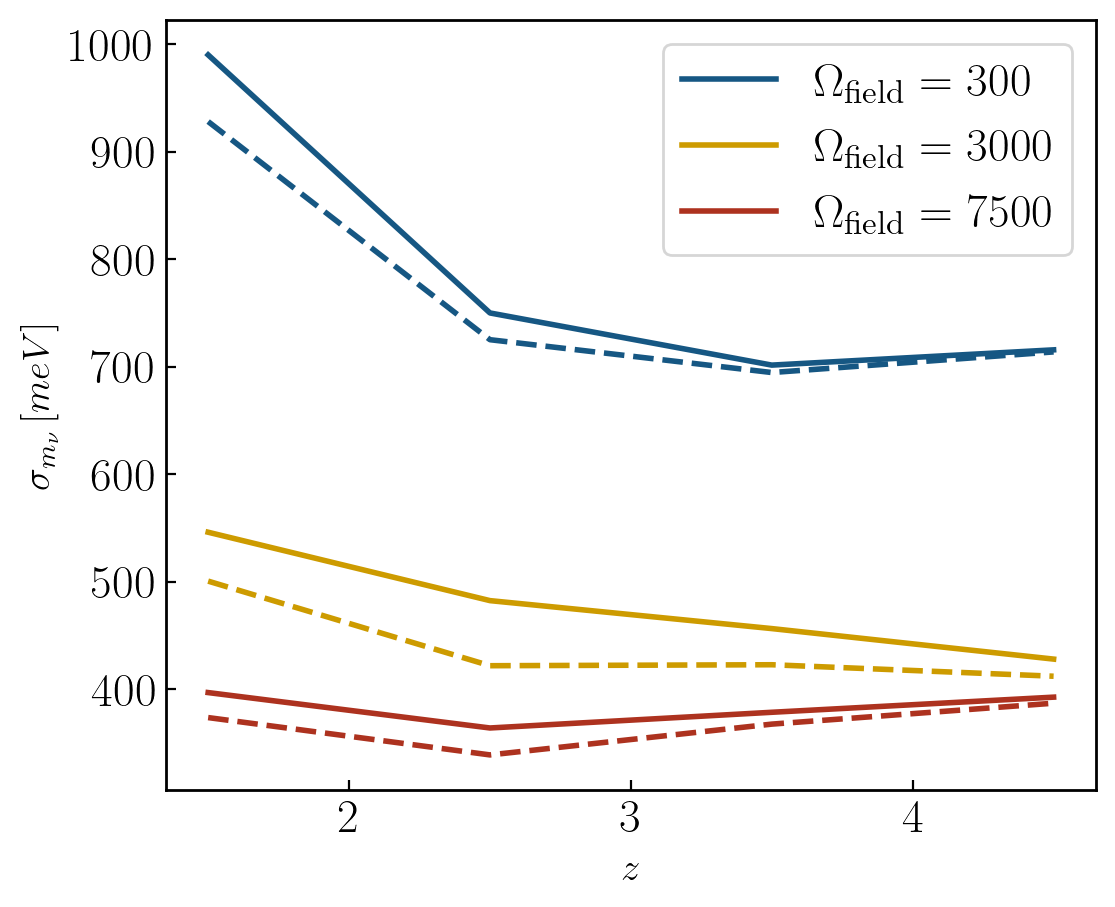

In [156]:
for t in range(len(Omegas)):
    obs_params['Omega_field'] = Omegas[t]*u.deg**2
    for i in range(len(zs)):
        covmat_lim_z, cov_params = covariance_mat(Fz_XX_LIM[t,i], cov_params2, fixed_params, {})
        sig_mnu_LIM_bins[i] = np.sqrt(covmat_lim_z[mnu_ind,mnu_ind])
        covmat_lim_kSZ_z, cov_params = covariance_mat(Fz_vX_LIM[t,i], cov_params3, [], {})
        sig_mnu_LIM_kSZ_bins[i] = np.sqrt(covmat_lim_kSZ_z[mnu_ind,mnu_ind])
    plt.plot(zs, sig_mnu_LIM_bins*1e3, label=r'$\Omega_{\mathrm{field}}=%g$'%Omegas[t], color=palette[t])
    plt.plot(zs, sig_mnu_LIM_kSZ_bins*1e3, ls='--', color=palette[t])
    
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma_{m_\nu}\,[meV]$')
plt.show()

In [179]:
Omegas = np.linspace(300,7500, 5)

cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
obs_params['tobs'] = 3000*u.h

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

F_XX_om = []
F_vX_om = []

mnu_ind = free_params.index('mnu')

Fz_XX_LIM = np.zeros((len(Omegas),len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(Omegas),len(zs),len(free_params)-1,len(free_params)-1))
for t in range(len(Omegas)):
    obs_params['Omega_field'] = Omegas[t]*u.deg**2
    for i in range(len(zs)):  
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

        vol = m.Vfield
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
        
        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[t,i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[t,i,:,:] = np.linalg.inv(cov_vx)
        

    F_vX_om.append(np.sum(Fz_vX_LIM[t], axis=0))
    F_XX_om.append(np.sum(Fz_XX_LIM[t], axis=0))
    

cov_params2.remove('bT')
cov_params3.remove('bT')

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 142298.32043984215 Jy / sr 300.0 deg2 3000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simul

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,

Text(0.5, 1.0, '$t_\\mathrm{obs} = 3000$ h, 1\\% prior on $b_\\parallel$')

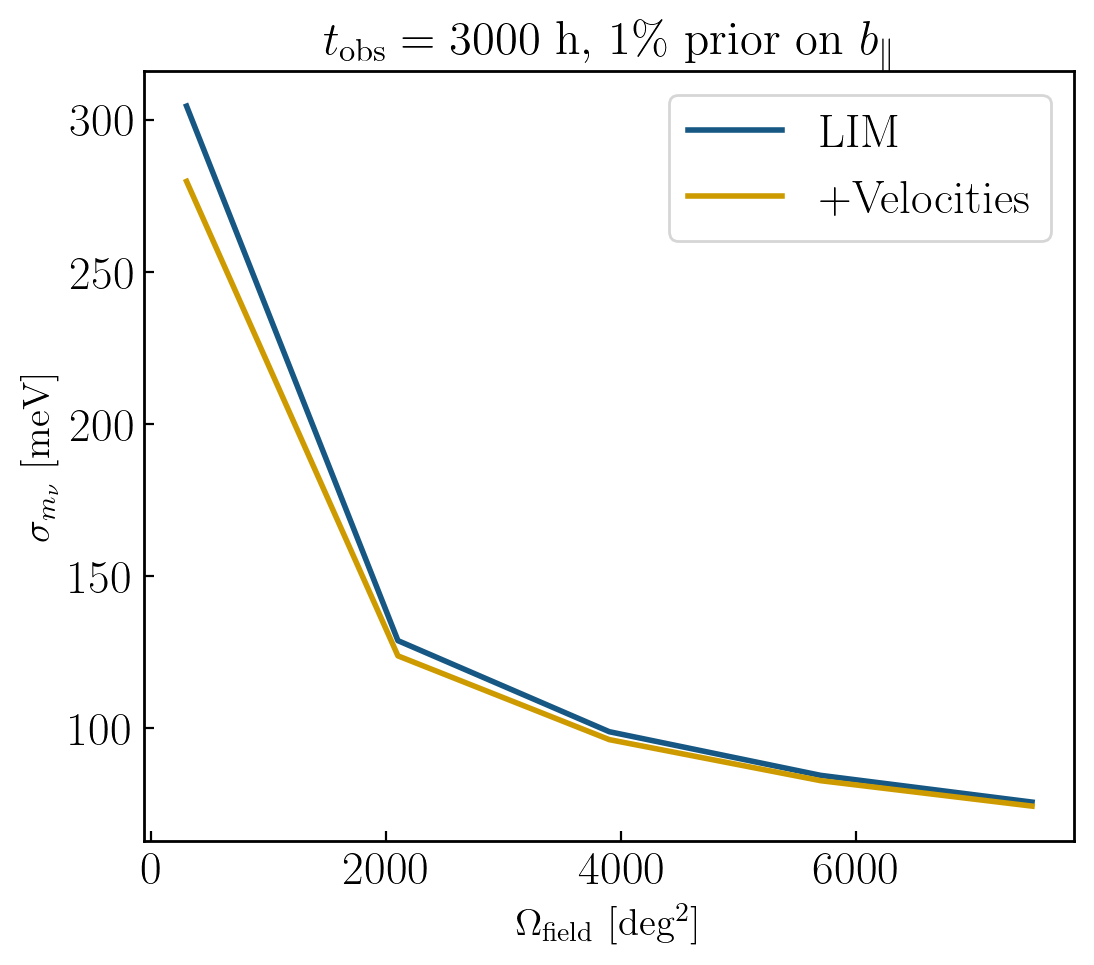

In [231]:
sig_mnu_LIM_om = np.zeros(len(Omegas))
sig_mnu_LIM_kSZ_om = np.zeros(len(Omegas))

for t in range(len(Omegas)):
    covmat_lim_z, cov_params = covariance_mat(F_XX_om[t], cov_params2, fixed_params, {})
    sig_mnu_LIM_om[t] = np.sqrt(covmat_lim_z[mnu_ind,mnu_ind])
    covmat_lim_kSZ_z, cov_params = covariance_mat(F_vX_om[t], cov_params3, [], {'bv_par':0.01})
    sig_mnu_LIM_kSZ_om[t] = np.sqrt(covmat_lim_kSZ_z[mnu_ind,mnu_ind])
    
plt.plot(Omegas, sig_mnu_LIM_om*1e3, label='LIM')
plt.plot(Omegas, sig_mnu_LIM_kSZ_om*1e3, label='+Velocities')
plt.legend()
plt.xlabel(r'$\Omega_\mathrm{field}$ [deg$^2$]')
plt.ylabel(r'$\sigma_{m_\nu}$ [meV]')
plt.title(r'$t_\mathrm{obs} = 3000$ h, 1\% prior on $b_\parallel$')

In [175]:
tobss = np.linspace(500,10000, 5)

cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
obs_params['Omega_field'] = 3000*u.deg**2

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

F_XX_tob = []
F_vX_tob = []

mnu_ind = free_params.index('mnu')

Fz_XX_LIM = np.zeros((len(Omegas),len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(Omegas),len(zs),len(free_params)-1,len(free_params)-1))
for t in range(len(tobss)):
    obs_params['tobs'] = tobss[t]*u.h
    for i in range(len(zs)):  
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

        vol = m.Vfield
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
        
        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[t,i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[t,i,:,:] = np.linalg.inv(cov_vx)


    F_vX_tob.append(np.sum(Fz_vX_LIM[t], axis=0))
    F_XX_tob.append(np.sum(Fz_XX_LIM[t], axis=0))
    

cov_params2.remove('bT')
cov_params3.remove('bT')

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 1102269.7095085212 Jy / sr 3000.0 deg2 500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simul

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,

Text(0.5, 1.0, '$\\Omega_\\mathrm{field} = 3000$ deg$^2$, 1\\% prior on $b_\\parallel$')

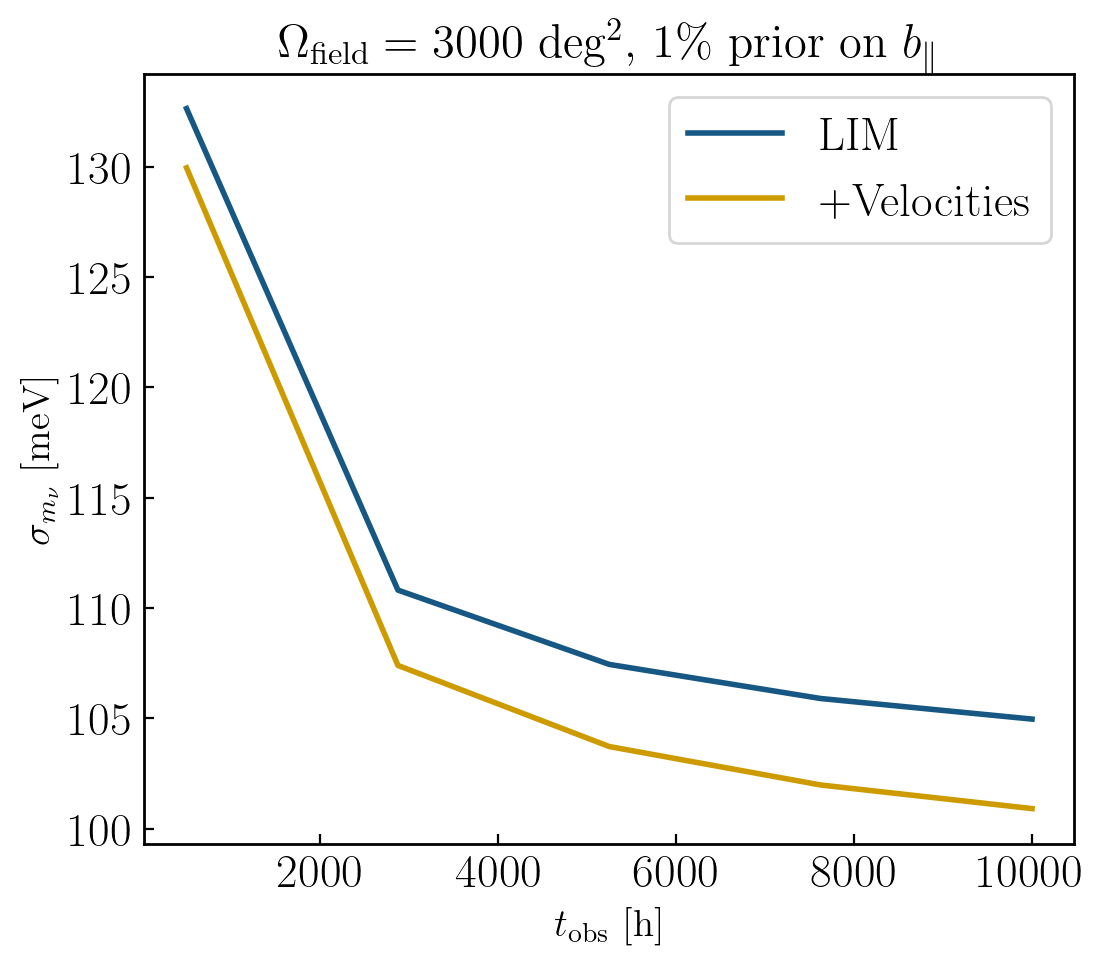

In [223]:
sig_mnu_LIM_tob = np.zeros(len(tobss))
sig_mnu_LIM_kSZ_tob = np.zeros(len(tobss))

for t in range(len(tobss)):
    covmat_lim_z, cov_params = covariance_mat(F_XX_tob[t], cov_params2, fixed_params, {})
    sig_mnu_LIM_tob[t] = np.sqrt(covmat_lim_z[mnu_ind,mnu_ind])
    covmat_lim_kSZ_z, cov_params = covariance_mat(F_vX_tob[t], cov_params3, [], {'bv_par':0.01})
    sig_mnu_LIM_kSZ_tob[t] = np.sqrt(covmat_lim_kSZ_z[mnu_ind,mnu_ind])
    
plt.plot(tobss, sig_mnu_LIM_tob*1e3, label='LIM')
plt.plot(tobss, sig_mnu_LIM_kSZ_tob*1e3, label='+Velocities')
plt.legend()
plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\sigma_{m_\nu}$ [meV]')
plt.title(r'$\Omega_\mathrm{field} = 3000$ deg$^2$, 1\% prior on $b_\parallel$')#m.Omega_field.value)

In [232]:
tobss = np.linspace(500,10000, 5)

cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
obs_params['Omega_field'] = 300*u.deg**2

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

F_XX_tob2 = []
F_vX_tob2 = []

mnu_ind = free_params.index('mnu')

Fz_XX_LIM2 = np.zeros((len(Omegas),len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM2 = np.zeros((len(Omegas),len(zs),len(free_params)-1,len(free_params)-1))
for t in range(len(tobss)):
    obs_params['tobs'] = tobss[t]*u.h
    for i in range(len(zs)):  
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

        vol = m.Vfield
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
        
        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM2[t,i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM2[t,i,:,:] = np.linalg.inv(cov_vx)


    F_vX_tob2.append(np.sum(Fz_vX_LIM2[t], axis=0))
    F_XX_tob2.append(np.sum(Fz_XX_LIM2[t], axis=0))
    

cov_params2.remove('bT')
cov_params3.remove('bT')

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 348558.2763326672 Jy / sr 300.0 deg2 500.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulat

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par

Text(0.5, 1.0, '$\\Omega_\\mathrm{field} = 300$ deg$^2$')

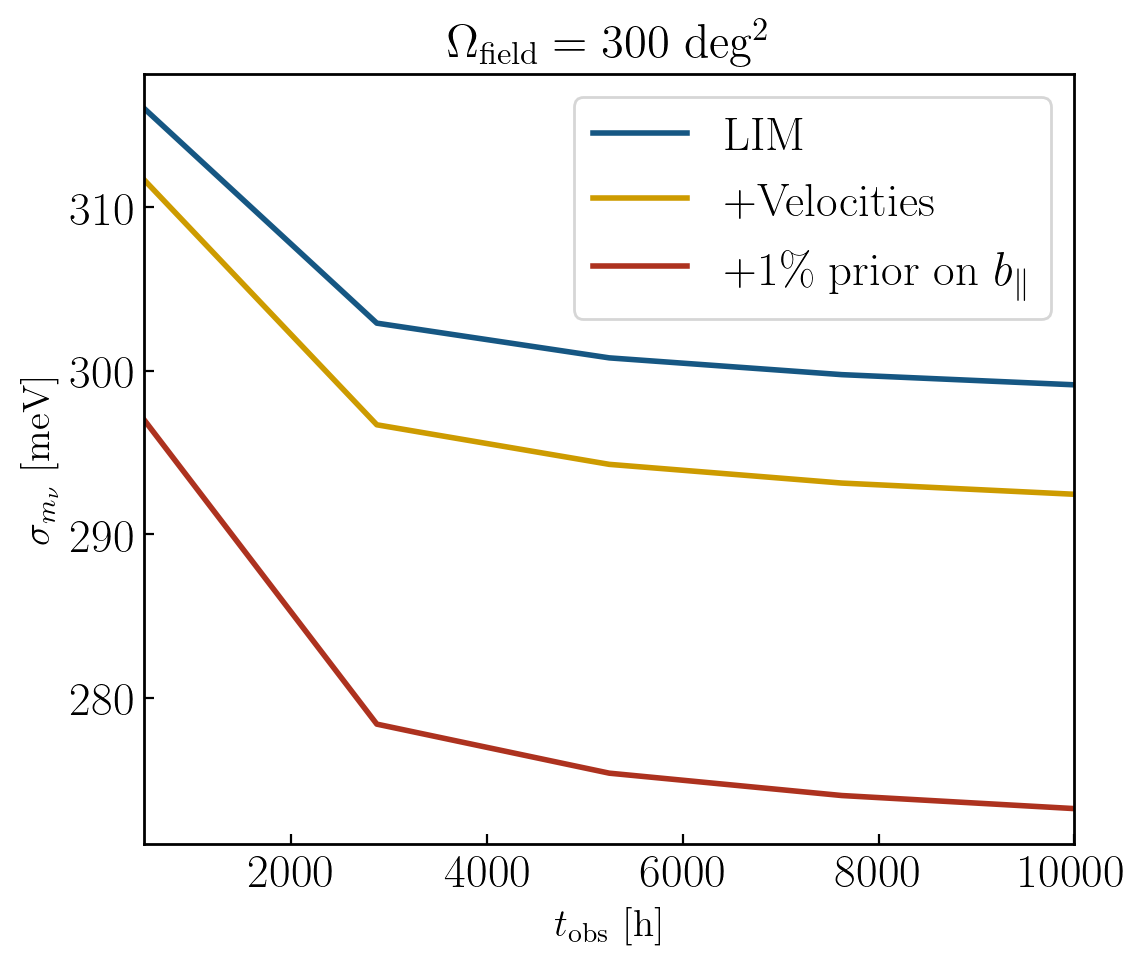

In [238]:
sig_mnu_LIM_tob = np.zeros(len(tobss))
sig_mnu_LIM_kSZ_tob = np.zeros(len(tobss))
sig_mnu_LIM_kSZ_tob_pr = np.zeros(len(tobss))

for t in range(len(tobss)):
    covmat_lim_z, cov_params = covariance_mat(F_XX_tob2[t], cov_params2, fixed_params, {})
    sig_mnu_LIM_tob[t] = np.sqrt(covmat_lim_z[mnu_ind,mnu_ind])
    covmat_lim_kSZ_z, cov_params = covariance_mat(F_vX_tob2[t], cov_params3, [], {})
    sig_mnu_LIM_kSZ_tob[t] = np.sqrt(covmat_lim_kSZ_z[mnu_ind,mnu_ind])
    covmat_lim_kSZ_z, cov_params = covariance_mat(F_vX_tob2[t], cov_params3, [], {'bv_par':0.01})
    sig_mnu_LIM_kSZ_tob_pr[t] = np.sqrt(covmat_lim_kSZ_z[mnu_ind,mnu_ind])
    
plt.plot(tobss, sig_mnu_LIM_tob*1e3, label='LIM')
plt.plot(tobss, sig_mnu_LIM_kSZ_tob*1e3, label='+Velocities')
plt.plot(tobss, sig_mnu_LIM_kSZ_tob_pr*1e3, label=r'+1\% prior on $b_\parallel$')
plt.xlim(np.min(tobss), np.max(tobss))
plt.legend()
plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\sigma_{m_\nu}$ [meV]')
plt.title(r'$\Omega_\mathrm{field} = 300$ deg$^2$')#, 1\% prior on $b_\parallel$')#m.Omega_field.value)

In [245]:
tobss[1]

2875.0

Text(0.5, 1.0, '$\\Omega_\\mathrm{field} = 300$ deg$^2, \\, t_\\mathrm{obs} = 3000$h')

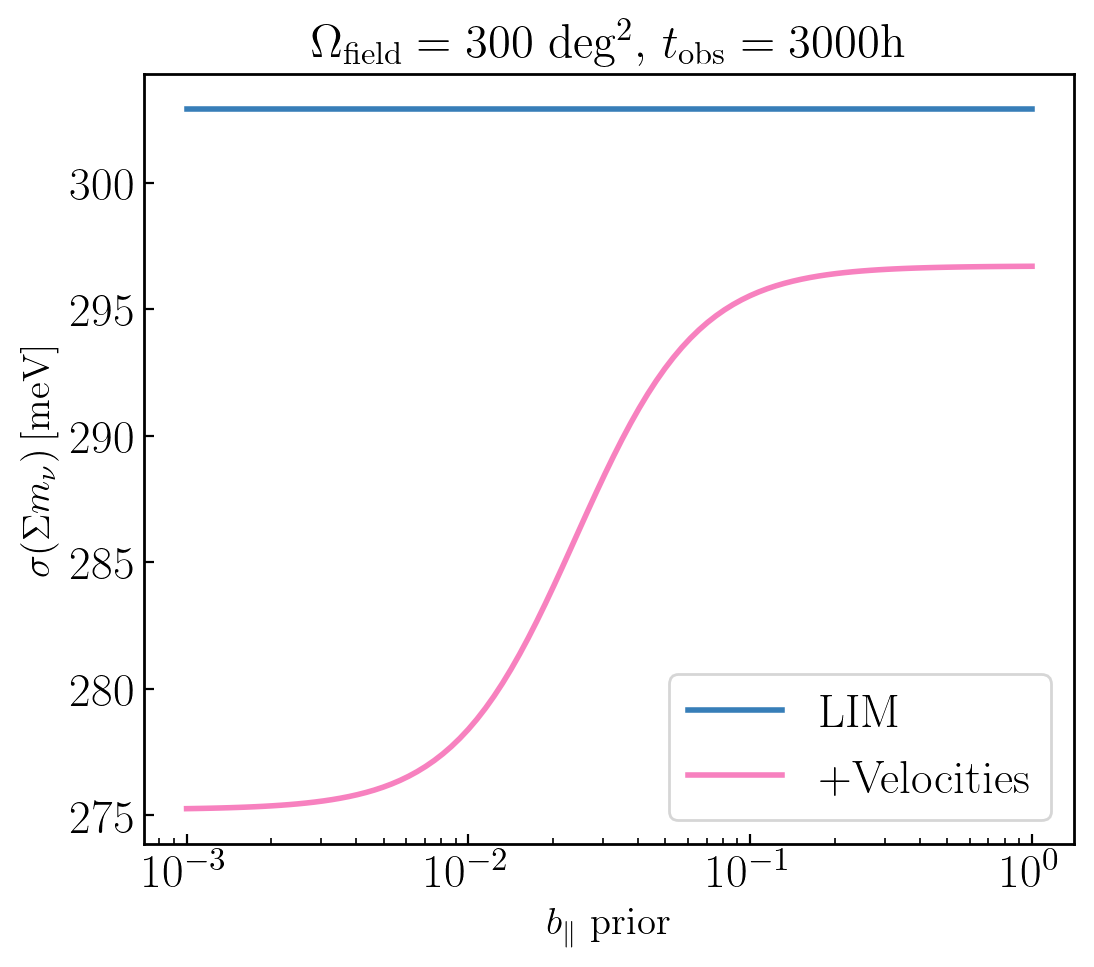

In [249]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_tob2[1], cov_params2, [], {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_tob2[1], cov_params3, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='LIM', color=palette[5])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'$\Omega_\mathrm{field} = 300$ deg$^2, \, t_\mathrm{obs} = 3000$h')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

In [251]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
obs_params['tobs'] = 3000*u.h
obs_params['Omega_field'] = 300*u.deg**2
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for i in range(len(zs)):
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    
    cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
    cov_xx = np.delete(cov_xx, -1, axis=0)
    cov_xx = np.delete(cov_xx, -1, axis=1)
    Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

    cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
    cov_vx = np.delete(cov_vx, -1, axis=0)
    cov_vx = np.delete(cov_vx, -1, axis=1)
    Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)
        

cov_params2.remove('bT')
cov_params3.remove('bT')

F_vX_LIM = np.sum(Fz_vX_LIM, axis=0)
F_XX_LIM = np.sum(Fz_XX_LIM, axis=0)

print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_LIM, cov_params2, [], {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_LIM, cov_params3, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 142298.32043984215 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)n

Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re

Text(0.5, 1.0, '$\\Omega_\\mathrm{field} = 300$ deg$^2, \\, t_\\mathrm{obs} = 3000$h')

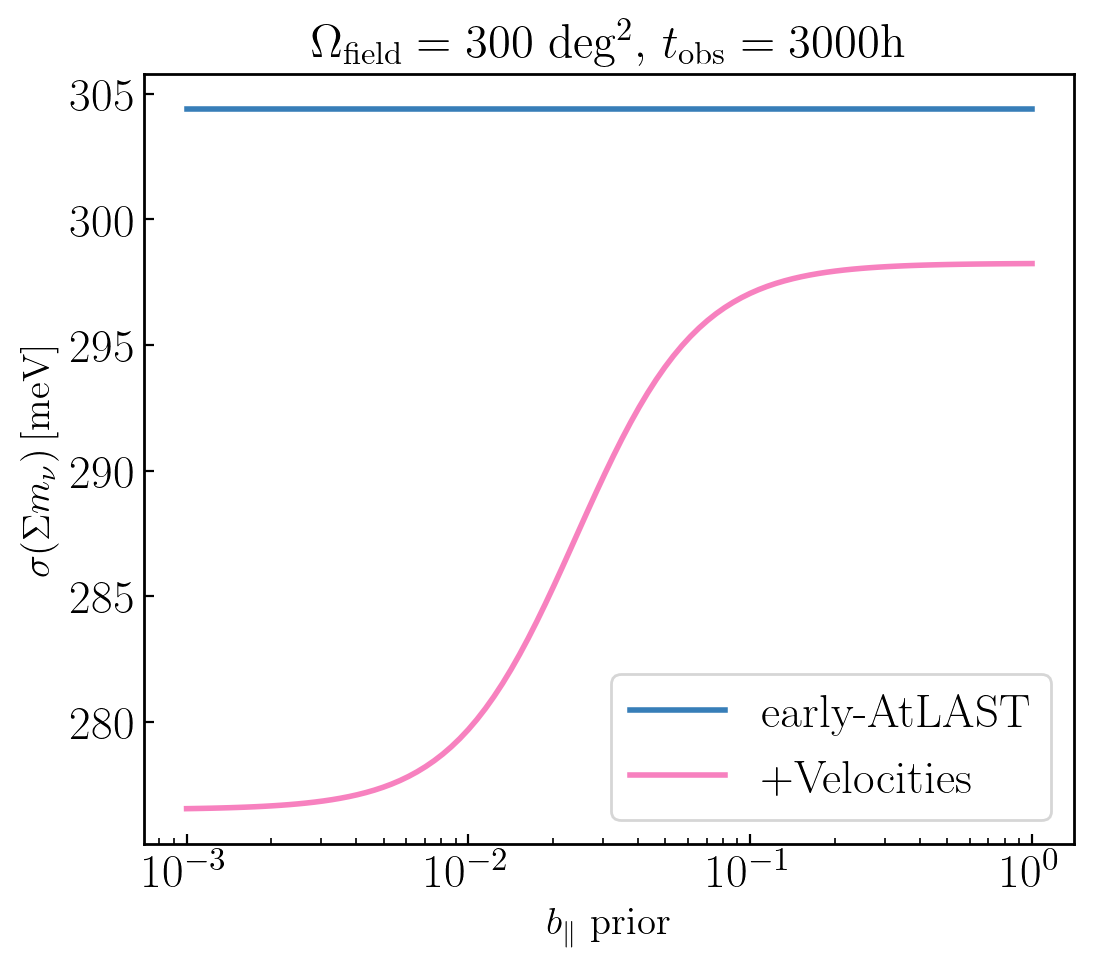

In [252]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_LIM, cov_params2, [], {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_LIM, cov_params3, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='early-AtLAST', color=palette[5])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'$\Omega_\mathrm{field} = 300$ deg$^2, \, t_\mathrm{obs} = 3000$h')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

In [253]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
obs_params['tobs'] = 1000*u.h
obs_params['Omega_field'] = 200*u.deg**2
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for i in range(len(zs)):
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    
    cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
    cov_xx = np.delete(cov_xx, -1, axis=0)
    cov_xx = np.delete(cov_xx, -1, axis=1)
    Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

    cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
    cov_vx = np.delete(cov_vx, -1, axis=0)
    cov_vx = np.delete(cov_vx, -1, axis=1)
    Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)
        

cov_params2.remove('bT')
cov_params3.remove('bT')

F_vX_LIM = np.sum(Fz_vX_LIM, axis=0)
F_XX_LIM = np.sum(Fz_XX_LIM, axis=0)

print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_LIM, cov_params2, [], {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_LIM, cov_params3, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 201239.44459896523 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)n

Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re

Text(0.5, 1.0, '$\\Omega_\\mathrm{field} = 200$ deg$^2, \\, t_\\mathrm{obs} = 1000$h')

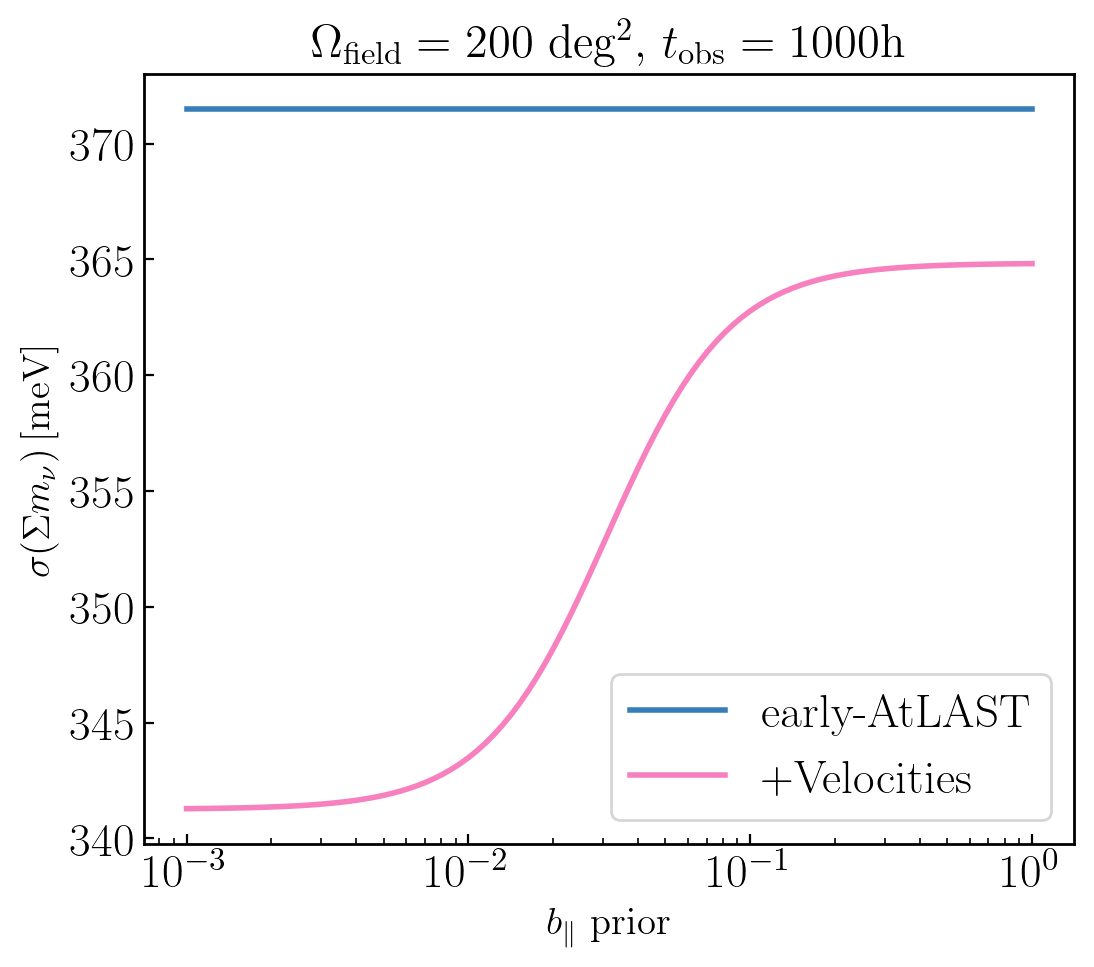

In [256]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_LIM, cov_params2, [], {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_LIM, cov_params3, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='early-AtLAST', color=palette[5])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'$\Omega_\mathrm{field} = %g$ deg$^2, \, t_\mathrm{obs} = %g$h'%(m.Omega_field.value, m.tobs.value))
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

Test changing $\sigma_\mathrm{pix}$. Here we take 10 times larger noise, which correspond to CCAT-prime detector noise level

In [96]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for i in range(len(zs)):
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]*10
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    
    cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
    cov_xx = np.delete(cov_xx, -1, axis=0)
    cov_xx = np.delete(cov_xx, -1, axis=1)
    Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

    cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
    cov_vx = np.delete(cov_vx, -1, axis=0)
    cov_vx = np.delete(cov_vx, -1, axis=1)
    Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)
        

cov_params2.remove('bT')
cov_params3.remove('bT')

F_vX_pix = np.sum(Fz_vX_LIM, axis=0)
F_XX_pix = np.sum(Fz_XX_LIM, axis=0)

print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_pix, cov_params2, [], {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_pix, cov_params3, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 3897100.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this i



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

(0.002, 0.5)

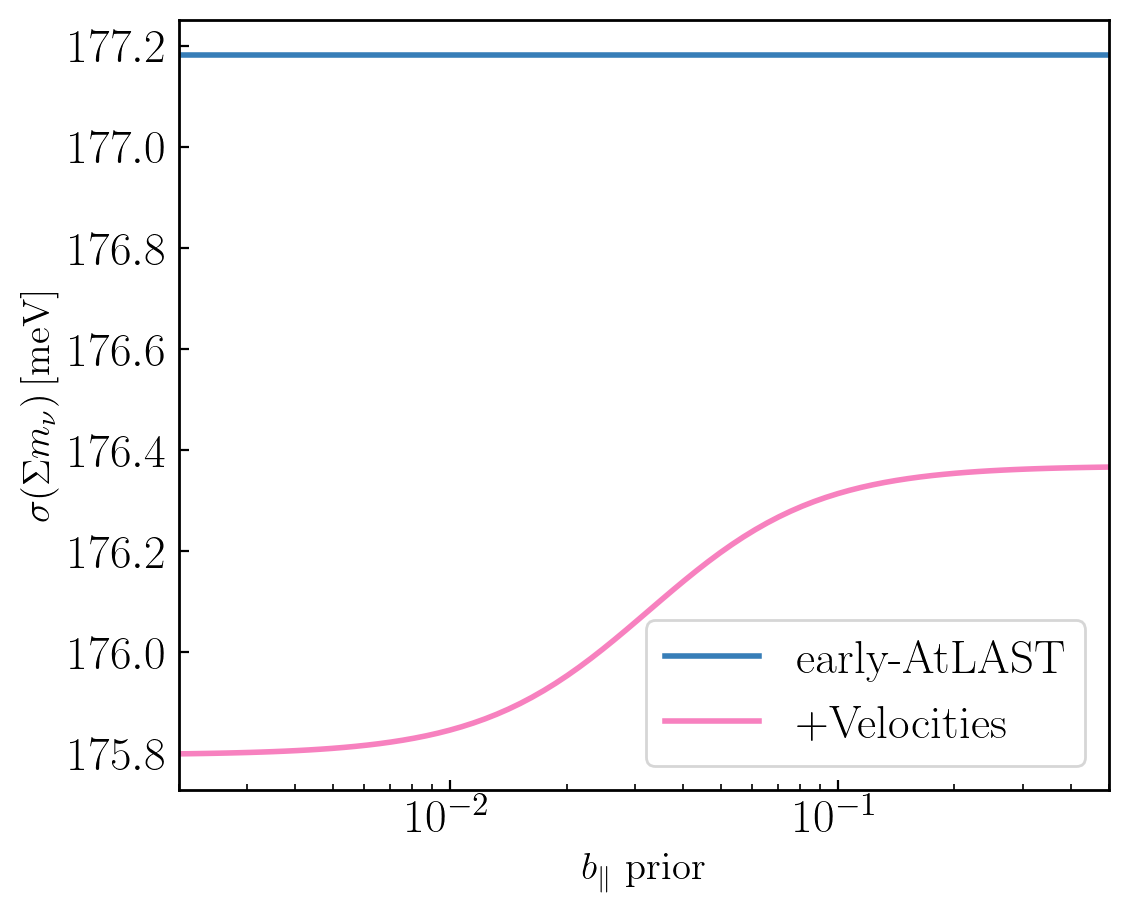

In [97]:
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_pix, cov_params2, [], {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_pix, cov_params3, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='early-AtLAST', color=palette[5])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.xlim(2e-3, 5e-1)

Test changing $\theta_\mathrm{FWHM}$. Here we take 10 times larger resolution, which correspond to CCAT-prime detector, and 10 times lower.

In [100]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
for i in range(len(zs)):
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]/10
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    
    cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
    cov_xx = np.delete(cov_xx, -1, axis=0)
    cov_xx = np.delete(cov_xx, -1, axis=1)
    Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

    cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
    cov_vx = np.delete(cov_vx, -1, axis=0)
    cov_vx = np.delete(cov_vx, -1, axis=1)
    Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)
        

cov_params2.remove('bT')
cov_params3.remove('bT')

F_vX_fwhm = np.sum(Fz_vX_LIM, axis=0)
F_XX_fwhm = np.sum(Fz_XX_LIM, axis=0)

print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_fwhm, cov_params2, [], {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_fwhm, cov_params3, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 0.2 arcsec 3897112.4999999995 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)n

Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re

(0.002, 0.5)

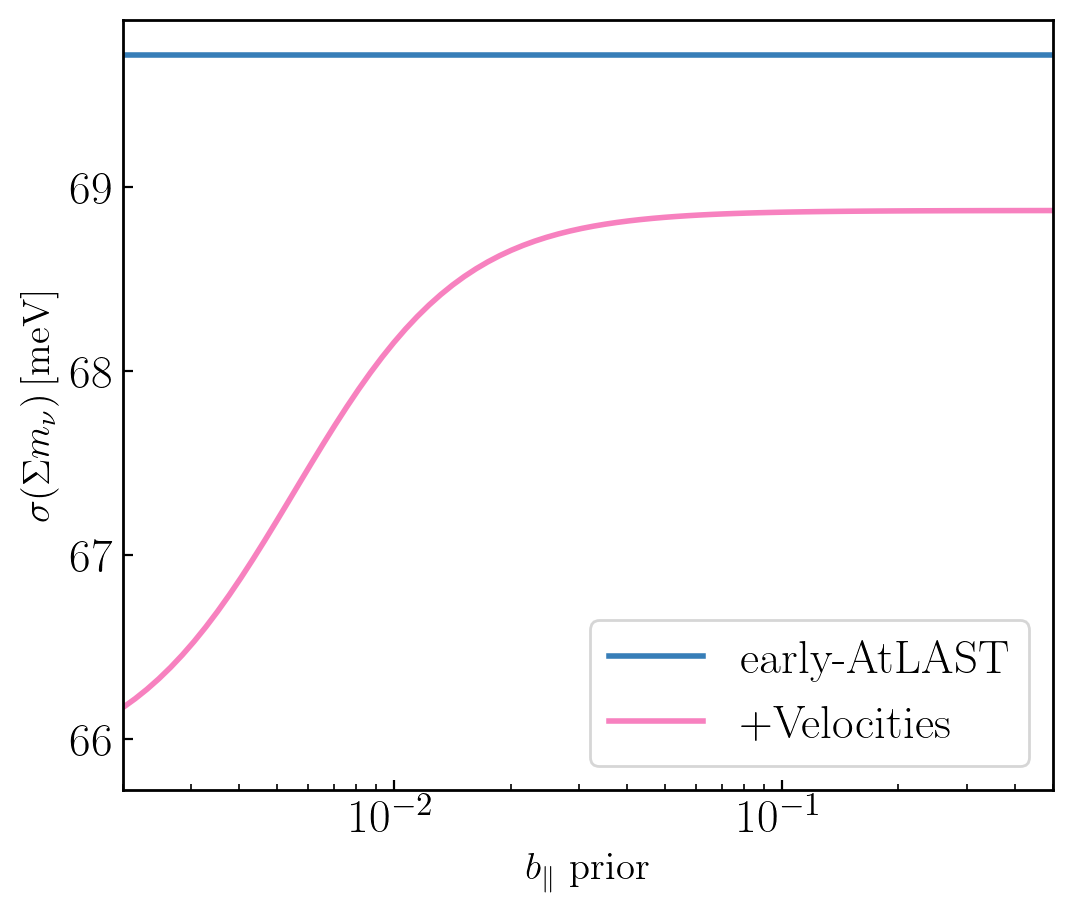

In [101]:
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_fwhm, cov_params2, [], {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_fwhm, cov_params3, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='early-AtLAST', color=palette[5])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.xlim(2e-3, 5e-1)

(0.002, 0.5)

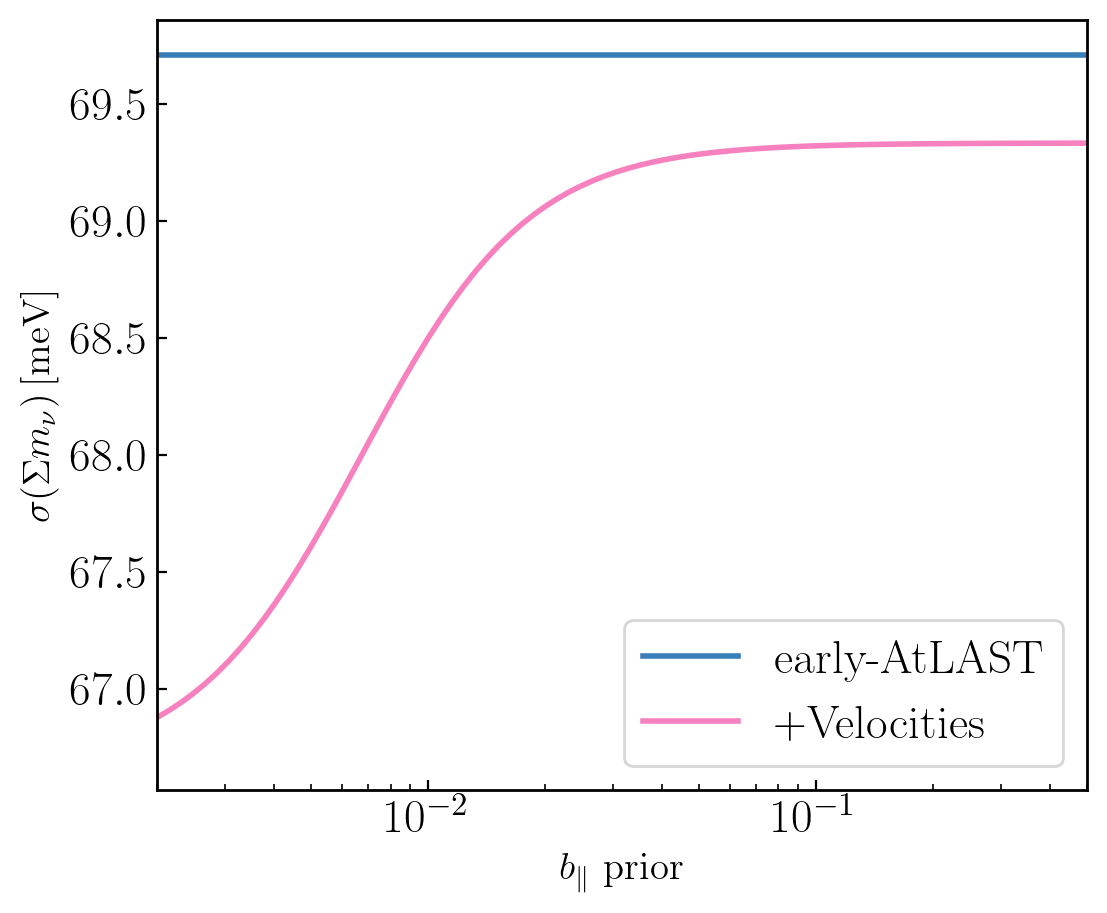

In [95]:
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_fwhm, cov_params2, [], {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_fwhm, cov_params3, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='early-AtLAST', color=palette[5])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.xlim(2e-3, 5e-1)

neutrino masses constraints as function $\sigma_\mathrm{pix}$, for single redshift bin at $z=1.5$

In [108]:

use_z = zs[0]
cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
nu, Dnu = Dnu_from_Dz(m.nu, use_z, 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]


deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

sig_pixs = np.logspace(1, 6, 10)*u.Jy/u.sr*u.s**0.5
sig_mnu_LIM_sigN = np.zeros(len(sig_pixs))
sig_mnu_LIM_vel_sigN = np.zeros(len(sig_pixs))
sigN = np.ones(len(sig_pixs))*(m.sigma_N.unit)
mnu_ind = free_params.index('mnu')

F_XX_sigN = []
F_vX_sigN = []


for i in range(len(sig_pixs)):
    obs_params['sigma_pix'] = sig_pixs[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    sigN[i] = m.sigma_N
    print(m.sigma_N)    
    vol = m.Vfield
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
#     cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
#     cov_xx = np.delete(cov_xx, -1, axis=0)
#     cov_xx = np.delete(cov_xx, -1, axis=1)
#     xx2 = np.linalg.inv(cov_xx)

#     cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
#     cov_vx = np.delete(cov_vx, -1, axis=0)
#     cov_vx = np.delete(cov_vx, -1, axis=1)
#     vx2 = np.linalg.inv(cov_vx)
    
    F_XX_sigN.append(xx)
    F_vX_sigN.append(vx)



259.8066666666667 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts 



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

(200.0, 700.0)

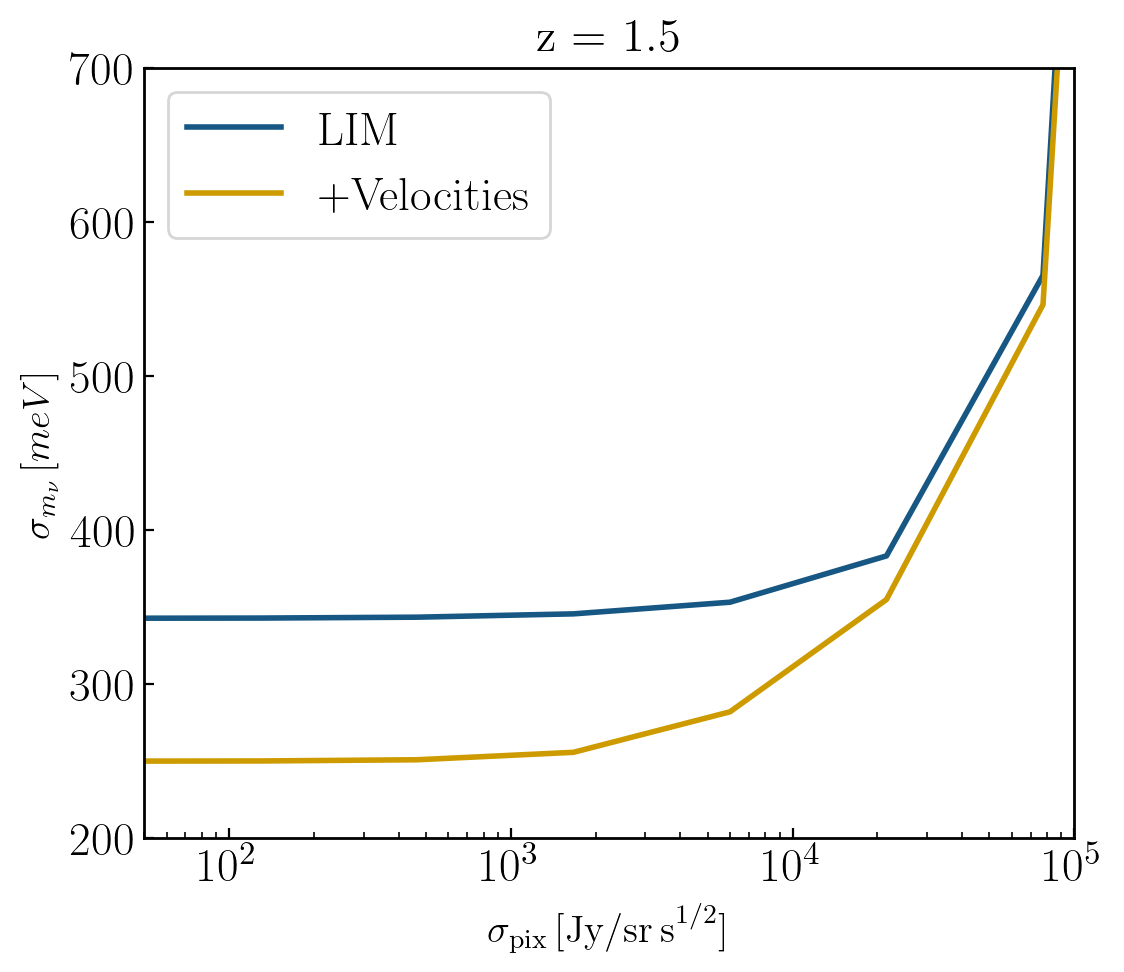

In [116]:

for i in range(len(sig_pixs)):
     
    covmat_lim_sigN, cov_params = covariance_mat(F_XX_sigN[i], free_params, fixed_params, {})
    sig_mnu_LIM_sigN[i] = np.sqrt(covmat_lim_sigN[mnu_ind,mnu_ind])
    covmat_lim_kSZ_sigN, cov_params = covariance_mat(F_vX_sigN[i], free_params, [], {})
    sig_mnu_LIM_vel_sigN[i] = np.sqrt(covmat_lim_kSZ_sigN[mnu_ind,mnu_ind])

    
plt.semilogx(sig_pixs, sig_mnu_LIM_sigN*1e3, label='LIM')
plt.semilogx(sig_pixs, sig_mnu_LIM_vel_sigN*1e3, label='+Velocities')
plt.legend()
plt.xlabel(r'$\sigma_\mathrm{pix}\, [\mathrm{Jy/sr \,s}^{1/2}]$')
plt.ylabel(r'$\sigma_{m_\nu}\,[meV]$')
#plt.grid(ls=':')
plt.title('z = %g'%use_z)
plt.xlim(5e1,1e5)
plt.ylim(200,700)